## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"This is Mary Hayes. I need you to call Intelligent Auto Solutions to make an appointment for my 2019 Chevy lumina What is the problem with the car. It is making a funny grinding noise. it may be the brakes. Is there any certain day or time you need. I would like it done tomorrow morning. The earliest they can get you in is wednesday at 10 am. That wont work. Can they do it wednesday afternoon after one pm. No, how is thursday at 11:30 am. No i have an appointment and need my car can you please ask them to work me in in the morning. What is your number so i can get back to you. 8359105473 Ok i will get back in a few. great They will work you in at 8 am in the morning they are not sure how long it will take Ok please send me the confirmation I have sent it to both your email and phone I havent got it. let me resend it. thank you tomorrow morning at 8 am you must be there on time. thank you so much i will be on time. your welcome.",auto-repair-appt-1,0
126,"Assistant, my car has a problem. I need it repaired. Which vehicle repair shop would you like to have it repaired at? Intelligent Auto Solutions What is the make, model, and year of the vehicle? It's an Insight What is the vehicle make? It's a Honda. What year is it? 2010 What problem does the vehicle have? It's completely dead and won't run. I think there's a problem with the hybrid system. Do you need to bring your car in immediately? Yes. You may bring your vehicle to Intelligent Auto Solutions as soon as possible. What name should I schedule the appointment under? Jack Jackson What phone number may they contact you at? 888-888-8888 The inspection cost at Intelligent Auto Systems for repairing hybrid systems for a 2010 Honda Insight is $100. It will be credited back to you if you decide to repair your vehicle at Intelligent Auto Solutions. Would you like to schedule your appointment to service your vehicle immediately now? Yes. Okay, your appointment has been scheduled. Thank you!",auto-repair-appt-1,0
555,"I need you to get me some movie tickets what do you want to see? Isn't it Romantic alright I'll be with family so it needs to be at the Brendan theater in Vacaville Oh, okay I think I'll need four seats four, got it. I think it's reserved seating so obviously try to get them all together Of course. What time did you want to go? There is an 8:40 showing according to my sister. Okay, if I can't get that show is there another that would work? No, but I don't think it should sell out Probably not So read back what you are doing I'm getting four tickets for Isn't it Romantic for tonight at the Brendan theater at 8:40. I'll have them sent to your phone. Right and try to get centered seats if you can No problem I really appreciate it I'll do it right now Thank you, bye Goodbye",movie-tickets-1,1
1260,I am looking for an upscale grill with a variety. Okay what date were you looking to go? And around what time did you want to arrive? I would like to go February 14th 2019 at 7:00 sharp. Okay and how many people? There will be 4 people total Okay great we have the option for a bottle of wine or roses at longhorns and availability at 7 and a 30.00$ charge for wine or roses. That sounds great could I get two bottles of wine and 2 dozen roses? Sure the total would be 234$ for the reservation Sounds great Well actually there seems to be a problem we could get you in for 730 is that okay? I guess that would be okay. Oh wait I just double checked your order and they are no longer taking tables fpr wine and roses packages. Oh okay I guess that will be okay I'll order from the bar. Okay sounds good. Well wait is there any other options with a grill in the area? Oh of course there's outback steakhouse. Well that sounda good. Do they have any availability? Actually they do for 7 and you get 2 free shots and a free appetizer. That actually sounds better to me. Its two miles closer to you as well. Oh really I had no idea. Yes I have your reservati

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"This is Mary Hayes. I need you to call Intelligent Auto Solutions to make an appointment for my 2019 Chevy lumina What is the problem with the car. It is making a funny grinding noise. it may be the brakes. Is there any certain day or time you need. I would like it done tomorrow morning. The earliest they can get you in is wednesday at 10 am. That wont work. Can they do it wednesday afternoon after one pm. No, how is thursday at 11:30 am. No i have an appointment and need my car can you please ask them to work me in in the morning. What is your number so i can get back to you. 8359105473 Ok i will get back in a few. great They will work you in at 8 am in the morning they are not sure how long it will take Ok please send me the confirmation I have sent it to both your email and phone I havent got it. let me resend it. thank you tomorrow morning at 8 am you must be there on time. thank you so much i will be on time. your welcome.",auto-repair-appt-1,0,mary hayes need call intelligent auto solutions make appointment chevy lumina problem car making funny grinding noise may brakes certain day time need would like done tomorrow morning earliest get wednesday wont work wednesday afternoon one pm thursday appointment need car please ask work morning number get back ok get back great work morning sure long take ok please send confirmation sent email phone havent got let resend thank tomorrow morning must time thank much time welcome
126,"Assistant, my car has a problem. I need it repaired. Which vehicle repair shop would you like to have it repaired at? Intelligent Auto Solutions What is the make, model, and year of the vehicle? It's an Insight What is the vehicle make? It's a Honda. What year is it? 2010 What problem does the vehicle have? It's completely dead and won't run. I think there's a problem with the hybrid system. Do you need to bring your car in immediately? Yes. You may bring your vehicle to Intelligent Auto Solutions as soon as possible. What name should I schedule the appointment under? Jack Jackson What phone number may they contact you at? 888-888-8888 The inspection cost at Intelligent Auto Systems for repairing hybrid systems for a 2010 Honda Insight is $100. It will be credited back to you if you decide to repair your vehicle at Intelligent Auto Solutions. Would you like to schedule your appointment to service your vehicle immediately now? Yes. Okay, your appointment has been scheduled. Thank you!",auto-repair-appt-1,0,assistant car problem need repaired vehicle repair shop would like repaired intelligent auto solutions make model year vehicle insight vehicle make honda year problem vehicle completely dead wont run think theres problem hybrid system need bring car immediately yes may bring vehicle intelligent auto solutions soon possible name schedule appointment jack jackson phone number may contact inspection cost intelligent auto systems repairing hybrid systems honda insight credited back decide repair vehicle intelligent auto solutions would like schedule appointment service vehicle immediately yes okay appointment scheduled thank
555,"I need you to get me some movie tickets what do you want to see? Isn't it Romantic alright I'll be with family so it needs to be at the Brendan theater in Vacaville Oh, okay I think I'll need four seats four, got it. I think it's reserved seating so obviously try to get them all together Of course. What time did you want to go? There is an 8:40 showing according to my sister. Okay, if I can't get that show is there another that would work? No, but I don't think it should sell out Probably not So read back what you are doing I'm getting four tickets for Isn't it Romantic for tonight at the Brendan theater at 8:40. I'll have them sent to your phone. Right and try to get centered seats if you can No problem I really appreciate it I'll do it right now Thank you, bye Goodbye",movie-tickets-1,1,need get movie tickets want s

In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['assistant car problem need repaired vehicle repair shop would like repaired intelligent auto solutions make model year vehicle insight vehicle make honda year problem vehicle completely dead wont run think theres problem hybrid system need bring car immediately yes may bring vehicle intelligent auto solutions soon possible name schedule appointment jack jackson phone number may contact inspection cost intelligent auto systems repairing hybrid systems honda insight credited back decide repair vehicle intelligent auto solutions would like schedule appointment service vehicle immediately yes okay appointment scheduled thank',
 'need get movie tickets want see isnt romantic alright ill family needs brendan theater vacaville oh okay think ill need four seats four got think reserved seating obviously try get together course time want go showing according sister okay cant get show another would work dont think sell probably read back im getting four tickets isnt romantic tonight brendan the

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5903
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('pm', 6), ('want', 7), ('order', 8), ('one', 9), ('thank', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['mary', 'hayes', 'call', 'intelligent'] -> Target (Y): need
Context (X): ['hayes', 'need', 'intelligent', 'auto'] -> Target (Y): call
Context (X): ['need', 'call', 'auto', 'solutions'] -> Target (Y): intelligent
Context (X): ['call', 'intelligent', 'solutions', 'make'] -> Target (Y): auto
Context (X): ['intelligent', 'auto', 'make', 'appointment'] -> Target (Y): solutions
Context (X): ['auto', 'solutions', 'appointment', 'chevy'] -> Target (Y): make
Context (X): ['solutions', 'make', 'chevy', 'lumina'] -> Target (Y): appointment
Context (X): ['make', 'appointment', 'lumina', 'problem'] -> Target (Y): chevy
Context (X): ['appointment', 'chevy', 'problem', 'car'] -> Target (Y): lumina
Context (X): ['chevy', 'lumina', 'car', 'making'] -> Target (Y): problem
Context (X): ['lumina', 'problem', 'making', 'funny'] -> Target (Y): car


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 2, 2, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 4, ..., 1, 1, 0],
       [0, 5, 5, ..., 0, 0, 0],
       [0, 6, 5, ..., 0, 0, 1]], dtype=int64)

In [19]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,okay,ok,yes,pm,want,order,one,thank,time,tickets,please,get,...,nodumb,dumber,geniusyou,bend,wasting,dacula,throught,dec,perfectly,paper,copies,macedonia,winchells,towncar,anyhow
0,0,1,1,0,2,0,1,0,0,1,2,3,0,2,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,2,1,0,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,2,0,0,0,2,0,0,1,1,2,0,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,3,10,0,2,1,1,2,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,4,7,2,0,2,0,2,3,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,2,5,0,0,0,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,1,4,3,0,2,0,0,0,0,1,1,0,1,3,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
998,0,5,5,0,11,3,2,2,0,0,0,0,9,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5903)
(250, 5903)
(250,)


#### Define Model Builder Function

In [21]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()

    return cm, pred, f1, report, accuracy

## Bag of Words Feature Benchmarking with Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
cm_nb_bow, pred_nb_bow, f1_nb_bow, report_nb_bow, accuracy_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [28]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes All Features", f1_nb_bow, accuracy_nb_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70


In [29]:
from sklearn.metrics import confusion_matrix

cm_nb_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  3,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  7,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  2, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 13,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9, 10,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  8]],
      dtype=int64)

In [30]:
from sklearn import metrics

print("Label" + report_nb_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.90      0.47      0.62        19
 coffee-ordering-2       0.60      0.94      0.73        16
      movie-finder       1.00      0.82      0.90        11
   movie-tickets-1       0.83      1.00      0.91        20
   movie-tickets-2       0.70      0.73      0.71        22
   movie-tickets-3       0.80      0.67      0.73        24
  pizza-ordering-1       0.53      0.64      0.58        14
  pizza-ordering-2       0.75      0.65      0.70        23
restaurant-table-1       0.72      0.59      0.65        22
restaurant-table-2       0.36      0.59      0.44        17
restaurant-table-3       0.70      0.44      0.54        16
       uber-lyft-1       0.69      0.73      0.71        15
       uber-lyft-2       0.67      0.62      0.64        13

          accuracy                           0.70       250
         macro avg       0.73    

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MinMaxScaler().fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

#### Iterate through number of features and get benchmark results

In [32]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

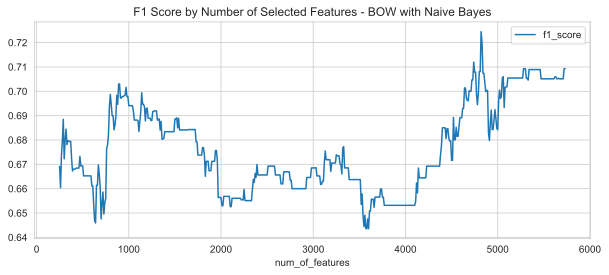

In [33]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [34]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

4770 4870 1


,num_of_features,f1_score,accuracy
457,4820,0.72,0.72
458,4830,0.72,0.72
449,4740,0.71,0.71
547,5720,0.71,0.71
548,5730,0.71,0.71


#### Get a more fine-grained look at the optimal number of features region

In [35]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

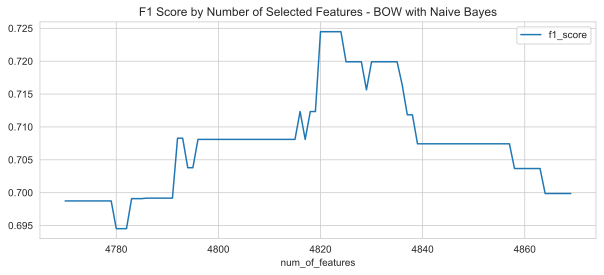

In [36]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [37]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
50,4820,0.72,0.72
54,4824,0.72,0.72
51,4821,0.72,0.72
52,4822,0.72,0.72
53,4823,0.72,0.72


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [148]:
model_nb_bow_opt = MultinomialNB()
cm_opt_bow, pred_opt_bow, f1_opt_bow, report_opt_bow, accuracy_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow_opt, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test)

In [149]:
print(cm_opt_bow)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11 14  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 16  5  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 15  7  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 16  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6 17  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  1  0  0  0]
 [ 0  0  0  0  0  1  0  0  0 14 12  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  4  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 14  8]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  5]]


In [150]:
print("Label" + report_opt_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.80      0.42      0.55        19
 coffee-ordering-2       0.56      0.88      0.68        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.70      0.80      0.74        20
   movie-tickets-2       0.58      0.68      0.62        22
   movie-tickets-3       0.94      0.67      0.78        24
  pizza-ordering-1       0.57      0.57      0.57        14
  pizza-ordering-2       0.74      0.74      0.74        23
restaurant-table-1       0.88      0.32      0.47        22
restaurant-table-2       0.33      0.71      0.45        17
restaurant-table-3       0.58      0.44      0.50        16
       uber-lyft-1       0.64      0.93      0.76        15
       uber-lyft-2       0.83      0.38      0.53        13

          accuracy                           0.67       250
         macro avg       0.72    

In [41]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72


## Bag of N-Grams Feature Extraction

In [131]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(doc_lst)
bv_matrix = bv_matrix.toarray()
bv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [132]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

,abbott ok,abbott yes,ability host,able access,able accommodate,able book,able come,able cook,able day,able diagnostic,able fit,able fulfilled,able get,able help,able later,...,zeldas pizza,zelos april,zelos info,zelos owner,zermatt resort,zero fat,zero ok,zesty italian,zip code,ziti pasta,ziti perfect,zone way,zoo type,zurich cinema,zylck phone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [133]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

(750, 37872)
(250, 37872)
(250,)


## Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [134]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
cm_nb_bong, pred_nb_bong, f1_nb_bong, report_nb_bong, accuracy_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [135]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes All Features", f1_nb_bong, accuracy_nb_bong])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68
7,Word2Vec Naive Bayes Optimal Features Selected: 93,0.68,0.68
8,Word2vec LinearSVC All Features,0.66,0.66
9,Word2Vec LinearSVC Optimal Features Selected: 99,0.67,0.67


In [136]:
from sklearn.metrics import confusion_matrix

cm_nb_bong

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 18,  4,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  2, 11,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  6, 18,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4, 18,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  5,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  9,  9,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  4,  7,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  8,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  8]],
      dtype=int64)

In [137]:
from sklearn import metrics

print(report_nb_bong)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.90      0.47      0.62        19
 coffee-ordering-2       0.60      0.94      0.73        16
      movie-finder       1.00      0.45      0.62        11
   movie-tickets-1       0.69      0.90      0.78        20
   movie-tickets-2       0.58      0.50      0.54        22
   movie-tickets-3       0.69      0.75      0.72        24
  pizza-ordering-1       0.67      0.71      0.69        14
  pizza-ordering-2       0.82      0.78      0.80        23
restaurant-table-1       0.50      0.23      0.31        22
restaurant-table-2       0.26      0.53      0.35        17
restaurant-table-3       0.54      0.44      0.48        16
       uber-lyft-1       0.57      0.53      0.55        15
       uber-lyft-2       0.62      0.62      0.62        13

          accuracy                           0.64       250
         macro avg       0.67      0.63      0.63       25

## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Iterate through number of features and get benchmark results

In [138]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

#### Plot f1-score by number of selected features

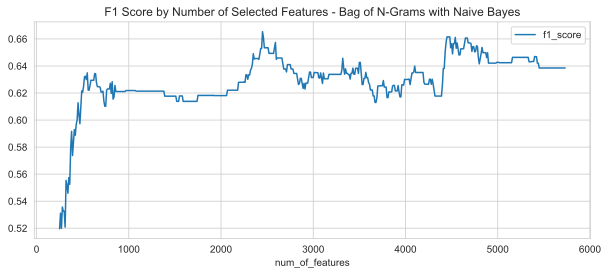

In [139]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [140]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

2400 2500 1


,num_of_features,f1_score,accuracy
220,2450,0.67,0.66
422,4470,0.66,0.66
420,4450,0.66,0.66
421,4460,0.66,0.66
423,4480,0.66,0.66


#### Get a more fine-grained look at the optimal number of features region

In [141]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

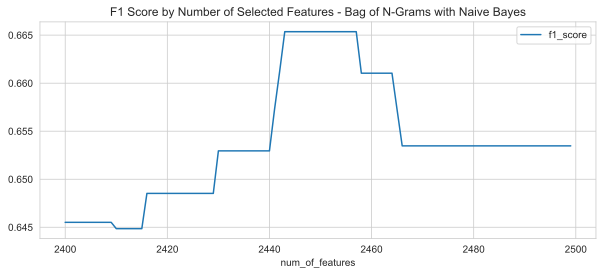

In [142]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [143]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
50,2450,0.67,0.66
43,2443,0.67,0.66
56,2456,0.67,0.66
55,2455,0.67,0.66
54,2454,0.67,0.66


## Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [144]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat

2450

In [145]:
model_nb_bong_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test)

In [146]:
print(report_opt)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.79      0.58      0.67        19
 coffee-ordering-2       0.60      0.75      0.67        16
      movie-finder       1.00      0.82      0.90        11
   movie-tickets-1       0.71      0.75      0.73        20
   movie-tickets-2       0.68      0.59      0.63        22
   movie-tickets-3       0.73      0.79      0.76        24
  pizza-ordering-1       0.62      0.71      0.67        14
  pizza-ordering-2       0.77      0.74      0.76        23
restaurant-table-1       0.78      0.32      0.45        22
restaurant-table-2       0.34      0.65      0.45        17
restaurant-table-3       0.53      0.50      0.52        16
       uber-lyft-1       0.62      0.53      0.57        15
       uber-lyft-2       0.50      0.62      0.55        13

          accuracy                           0.66       250
         macro avg       0.69      0.67      0.67       25

In [147]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68
7,Word2Vec Naive Bayes Optimal Features Selected: 93,0.68,0.68
8,Word2vec LinearSVC All Features,0.66,0.66
9,Word2Vec LinearSVC Optimal Features Selected: 99,0.67,0.67


## TF-IDF Feature Extraction

In [42]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 5087)
(250, 5087)


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [43]:
clf = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_tfidf, pred_nb_tfidf, f1_nb_tfidf, report_nb_tfidf, accuracy_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [44]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 5087)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [45]:
from sklearn.metrics import confusion_matrix

cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 18, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7, 20,  7,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0, 14,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  1, 15,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8, 21,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 21, 13, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  9]],
      dtype=int64)

In [46]:
from sklearn import metrics

print("Label" + report_nb_tfidf)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.05      0.10        19
 coffee-ordering-2       0.47      1.00      0.64        16
      movie-finder       0.00      0.00      0.00        11
   movie-tickets-1       0.57      1.00      0.73        20
   movie-tickets-2       0.61      0.64      0.62        22
   movie-tickets-3       0.79      0.62      0.70        24
  pizza-ordering-1       0.75      0.43      0.55        14
  pizza-ordering-2       0.72      0.91      0.81        23
restaurant-table-1       0.00      0.00      0.00        22
restaurant-table-2       0.30      0.76      0.43        17
restaurant-table-3       0.67      0.38      0.48        16
       uber-lyft-1       0.69      0.60      0.64        15
       uber-lyft-2       0.60      0.69      0.64        13

          accuracy                           0.59       250
         macro avg       0.58    

In [47]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes All Features", f1_nb_tfidf, accuracy_nb_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59


In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

def SelectBestModelFeatures_Chi_sparse(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MaxAbsScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

## Feature Selection - TF-IDF with Naive Bayes Multinomial

In [49]:
rows = []
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

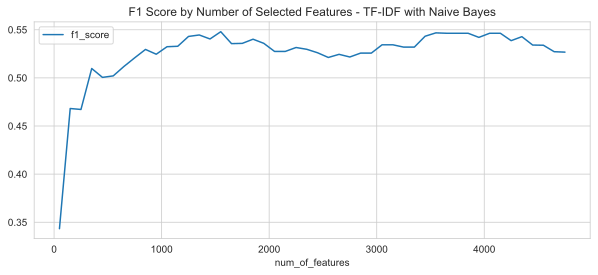

In [50]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [51]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

1500 1600 1


,num_of_features,f1_score,accuracy
15,1550,0.55,0.60
35,3550,0.55,0.59
38,3850,0.55,0.59
40,4050,0.55,0.59
37,3750,0.55,0.59


#### Take closer look at region around 1150 features

In [52]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

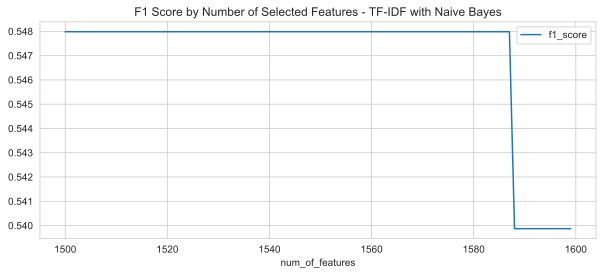

In [53]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [54]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
0,1500,0.55,0.60
45,1545,0.55,0.60
65,1565,0.55,0.60
64,1564,0.55,0.60
63,1563,0.55,0.60


## Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [55]:
cm_tf_nb, pred_tf_nb, f1_tf_nb, report_tf_nb, accuracy_tf_nb = SelectBestModelFeatures_Chi_sparse(clf, Opt_no_of_feat, X_train_tfidf, y_train, X_test_tfidf, y_test)
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_tf_nb, accuracy_tf_nb])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60


#### Metrics For Each Class

In [59]:
from sklearn import metrics
print("Label" + report_svc_tfidf)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.86      0.63      0.73        19
 coffee-ordering-2       0.70      0.88      0.78        16
      movie-finder       0.91      0.91      0.91        11
   movie-tickets-1       0.70      0.95      0.81        20
   movie-tickets-2       0.69      0.41      0.51        22
   movie-tickets-3       0.76      0.79      0.78        24
  pizza-ordering-1       0.50      0.57      0.53        14
  pizza-ordering-2       0.73      0.70      0.71        23
restaurant-table-1       0.64      0.32      0.42        22
restaurant-table-2       0.31      0.53      0.39        17
restaurant-table-3       0.50      0.50      0.50        16
       uber-lyft-1       0.62      0.67      0.65        15
       uber-lyft-2       0.58      0.54      0.56        13

          accuracy                           0.66       250
         macro avg       0.68    

In [60]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF LinearSVC All Features", f1_svc_tfidf, accuracy_svc_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66


## Word2Vec Feature Extraction

In [61]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

{'pizza': ['sausage', 'large', 'dominos', 'johns', 'toppings'],
 'terminator': ['abyss', 'judgment', 'avatar', 'sigourney', 'weaver'],
 'star': ['wars', 'return', 'jedi', 'recommendations', 'directed'],
 'east': ['broad', 'chicago', 'forever', 'dinein', 'malleys'],
 'korean': ['lauderhill', 'bbgo', 'pig', 'bbq', 'manna'],
 'playing': ['pet', 'sematary', 'boyfriend', 'billings', 'friend']}

#### Visualizing word embeddings

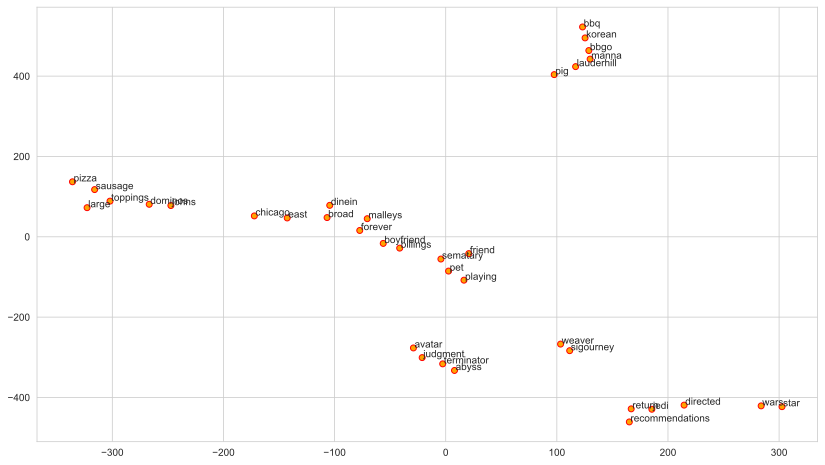

In [62]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [63]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [64]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [65]:
w2v_model.wv['jedi']

array([-0.21528454, -0.2183996 , -0.6863806 ,  0.32335994, -0.71575594,
       -0.5611143 , -0.13003011,  0.6774485 , -0.26205665,  0.24326679,
       -0.05325946, -0.8844338 , -0.6706337 ,  0.32274657, -0.07184087,
        0.1394435 ,  0.17480716, -0.56352776, -0.1611486 , -0.7818358 ,
       -0.5824635 , -0.57081324, -0.5142546 ,  0.13806653,  0.42424068,
       -0.12776943,  0.43001324,  0.14888896, -0.53246045, -0.7586357 ,
        0.19238532,  0.36693767,  0.14177825, -0.34765673, -0.54235184,
       -0.31330848,  0.01902863, -0.4452451 ,  0.32028723,  0.39204285,
        0.07200889, -0.10471772,  0.13888413,  0.50455314, -0.8138573 ,
        0.16433136, -0.04615086, -0.4698859 ,  0.29107395,  0.37953413,
       -0.17057876,  0.4968336 , -0.44933686, -0.3083114 , -0.6872747 ,
       -0.02182364, -0.09699851, -0.4063729 , -0.2521875 , -0.15851036,
        0.00165312, -0.31540573, -0.01531952, -0.3876694 , -0.36673182,
       -0.45755008, -0.08885116,  0.35978472,  0.13722345,  0.88

#### Build framework for getting document level embeddings

In [66]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [67]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.15,0.64,-0.13,0.75,0.40,0.47,-0.47,-1.02,-0.23,0.34,-0.16,1.34,-0.28,-0.84,0.30,...,0.03,-1.80,-0.17,-0.60,0.56,-0.49,-0.14,0.27,0.22,0.46,-0.95,0.32,-1.11,-0.15,-0.50
1,0.21,-0.47,-0.69,-0.15,0.02,-0.23,-0.43,-0.04,0.37,0.04,0.50,0.85,-0.43,-0.43,-0.95,...,0.75,0.48,0.04,-0.20,-0.66,0.73,0.37,-0.27,-0.70,-0.06,0.38,0.11,-0.50,0.60,-0.04
2,0.09,0.05,0.78,-0.73,0.54,-0.74,-0.92,-0.22,0.78,0.62,0.56,0.27,-0.26,-0.50,-0.33,...,1.26,0.63,0.24,-0.61,0.01,-0.71,1.37,0.86,0.49,0.69,-0.17,-0.19,-0.02,0.36,-0.13
3,0.39,1.32,-0.21,-0.06,-0.47,-0.07,0.80,-0.24,-0.05,0.37,0.20,0.69,0.49,-0.51,0.81,...,-0.77,0.96,-0.16,-0.97,-0.38,-0.73,0.44,0.28,1.11,0.13,-0.07,-0.95,-0.26,0.59,0.07
4,0.83,0.87,0.08,-0.40,-0.01,-0.18,0.42,-0.13,-0.22,-0.32,0.24,0.78,0.49,-0.34,0.26,...,-0.34,0.61,-0.50,-1.08,-0.01,-1.02,0.30,-0.06,1.14,-0.06,0.22,-0.72,-0.68,0.47,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.18,-0.20,0.52,-0.78,0.22,-0.48,-0.80,-0.11,0.46,0.19,0.56,0.08,-0.59,-0.40,-0.00,...,0.95,0.84,0.02,-0.58,-0.00,-0.45,0.70,0.34,0.10,0.59,-0.13,0.10,-0.21,0.39,0.04
746,0.06,0.89,0.44,-1.08,-0.19,-0.88,0.70,0.15,1.26,-0.18,-0.22,0.58,-0.10,-0.58,-0.21,...,0.34,0.00,-0.27,-0.75,0.54,-0.37,0.56,-0.61,0.62,0.05,0.95,-0.53,-1.55,1.37,1.02
747,-0.31,0.30,0.69,-0.66,0.12,-0.35,-0.69,0.28,0.54,0.02,0.18,0.33,-0.76,-0.65,-0.19,...,0.37,0.41,0.34,-0.23,0.36,-0.52,0.76,0.46,0.12,0.23,-0.17,0.00,-0.23,-0.26,-0.50
748,0.84,0.69,0.39,-0.30,-0.23,0.12,0.07,-0.13,-0.10,0.01,-0.64,0.94,0.06,-0.21,0.26,...,0.26,0.29,-0.34,-0.69,-0.20,-0.63,0.34,0.64,0.25,0.77,-0.32,-0.48,-0.04,0.06,0.19


In [68]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


## Word2vec Feature Benchmarking with Naive Bayes Classifier

In [69]:
from sklearn.naive_bayes import GaussianNB

#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes All Features", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68


In [70]:
cm_nb_w2v

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  6,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4, 10,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  5, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 13,  5,  1,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  5,  8,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4, 12,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 10]],
      dtype=int64)

In [71]:
print("Label" + report_nb_w2v)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.67      0.63      0.65        19
 coffee-ordering-2       0.59      0.62      0.61        16
      movie-finder       0.91      0.91      0.91        11
   movie-tickets-1       0.64      0.70      0.67        20
   movie-tickets-2       0.59      0.45      0.51        22
   movie-tickets-3       0.76      0.79      0.78        24
  pizza-ordering-1       0.53      0.57      0.55        14
  pizza-ordering-2       0.73      0.70      0.71        23
restaurant-table-1       0.65      0.59      0.62        22
restaurant-table-2       0.47      0.47      0.47        17
restaurant-table-3       0.60      0.75      0.67        16
       uber-lyft-1       0.79      0.73      0.76        15
       uber-lyft-2       0.71      0.77      0.74        13

          accuracy                           0.68       250
         macro avg       0.69    

## Feature Selection - Word2Vec Features with Naive Bayes Model

In [72]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

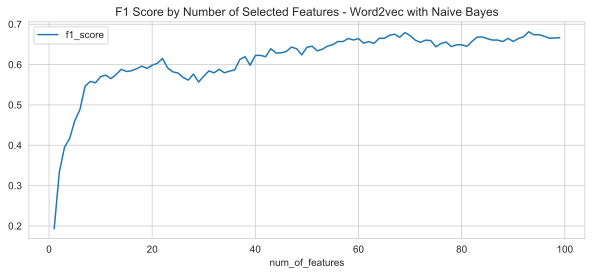

In [73]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [74]:
Opt_no_of_feat = int(sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
92,93,0.68,0.68
68,69,0.68,0.68
66,67,0.68,0.68
94,95,0.67,0.68
93,94,0.67,0.68


In [75]:
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, Opt_no_of_feat, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68
7,Word2Vec Naive Bayes Optimal Features Selected: 93,0.68,0.68


## Word2vec features Extraction with Fastext Model

In [86]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [87]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['digital', 'reviews', 'im', 'showings', 'children'],
 'pizza': ['pepperoni', 'large', 'sausage', 'pizzas', 'cheese'],
 'terminator': ['nevermind', 'salvatores', 'many', 'sorry', 'bar'],
 'star': ['wars', 'recommendations', 'episode', 'recommended', 'empire'],
 'audi': ['grinding', 'noise', 'jones', 'inspection', 'mechanic'],
 'east': ['springs', 'atlanta', 'screening', 'oak', 'side'],
 'korean': ['bbq', 'p', 'md', 'honey', 'taste'],
 'playing': ['movie', 'tickets', 'showing', 'theater', 'ticket']}

#### PCA on Fasttext Model

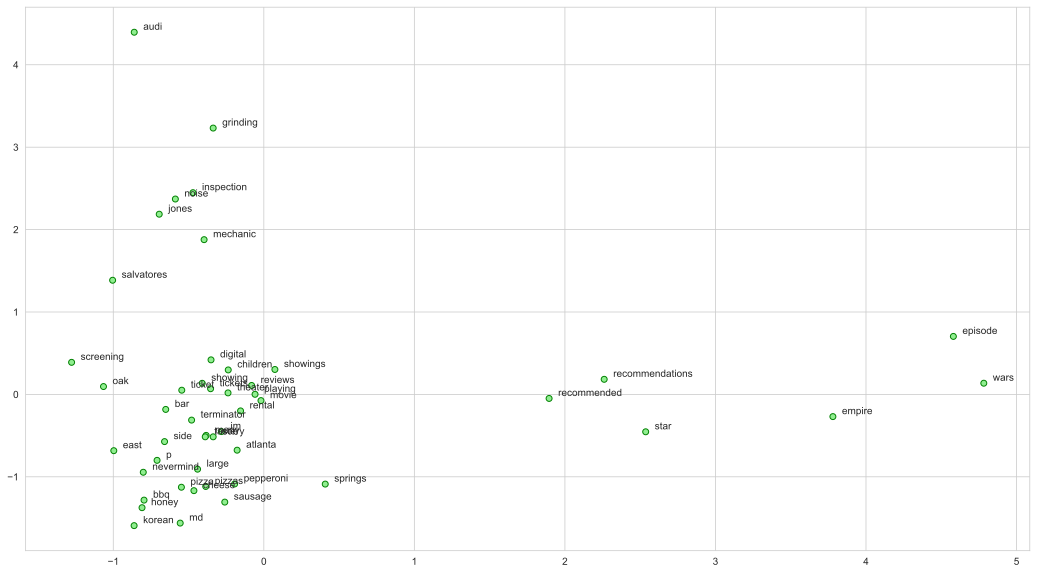

In [88]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [89]:
print(P.shape)

(48, 2)


In [90]:
ft_model.wv['rental']

array([-0.16769359,  0.45008457, -0.144921  ,  0.20845631, -0.1678899 ,
       -0.07299867, -0.01188535,  0.63050485,  0.21560492, -0.1694426 ,
        0.09492289, -0.03705627,  0.02677821, -0.16302627, -0.05672526,
        0.10073252, -0.20901814,  0.16465674,  0.24547526, -0.01762121,
        0.42929226,  0.05436523,  0.24464475,  0.08509216,  0.05497326,
       -0.20584153, -0.26351434,  0.24314101, -0.40304205, -0.04970707,
        0.05346126, -0.02908296, -0.2984213 , -0.3033675 , -0.35495746,
        0.34511518, -0.47013304,  0.00980695, -0.34183487,  0.19714466,
       -0.16892783,  0.22406547,  0.29757378,  0.12429767,  0.23871072,
        0.21962696,  0.20848843, -0.0314231 ,  0.07704728, -0.0961678 ,
       -0.11437391, -0.08381934, -0.09765354,  0.09898819,  0.16216844,
        0.02983818,  0.02290992,  0.13312507, -0.10261803,  0.09142522,
       -0.55698556,  0.04838785,  0.04811804, -0.30202448,  0.39239883,
        0.30186802,  0.06303129, -0.01597748, -0.19237654, -0.24

In [91]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.26132235
0.7431152


In [92]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies


#### WOrd2Vec Features from Fastest Benchmarking with Naive Bayes Model

In [93]:
w2v_ft_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.15,0.64,-0.13,0.75,0.40,0.47,-0.47,-1.02,-0.23,0.34,-0.16,1.34,-0.28,-0.84,0.30,...,0.03,-1.80,-0.17,-0.60,0.56,-0.49,-0.14,0.27,0.22,0.46,-0.95,0.32,-1.11,-0.15,-0.50
1,0.21,-0.47,-0.69,-0.15,0.02,-0.23,-0.43,-0.04,0.37,0.04,0.50,0.85,-0.43,-0.43,-0.95,...,0.75,0.48,0.04,-0.20,-0.66,0.73,0.37,-0.27,-0.70,-0.06,0.38,0.11,-0.50,0.60,-0.04
2,0.09,0.05,0.78,-0.73,0.54,-0.74,-0.92,-0.22,0.78,0.62,0.56,0.27,-0.26,-0.50,-0.33,...,1.26,0.63,0.24,-0.61,0.01,-0.71,1.37,0.86,0.49,0.69,-0.17,-0.19,-0.02,0.36,-0.13
3,0.39,1.32,-0.21,-0.06,-0.47,-0.07,0.80,-0.24,-0.05,0.37,0.20,0.69,0.49,-0.51,0.81,...,-0.77,0.96,-0.16,-0.97,-0.38,-0.73,0.44,0.28,1.11,0.13,-0.07,-0.95,-0.26,0.59,0.07
4,0.83,0.87,0.08,-0.40,-0.01,-0.18,0.42,-0.13,-0.22,-0.32,0.24,0.78,0.49,-0.34,0.26,...,-0.34,0.61,-0.50,-1.08,-0.01,-1.02,0.30,-0.06,1.14,-0.06,0.22,-0.72,-0.68,0.47,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.18,-0.20,0.52,-0.78,0.22,-0.48,-0.80,-0.11,0.46,0.19,0.56,0.08,-0.59,-0.40,-0.00,...,0.95,0.84,0.02,-0.58,-0.00,-0.45,0.70,0.34,0.10,0.59,-0.13,0.10,-0.21,0.39,0.04
746,0.06,0.89,0.44,-1.08,-0.19,-0.88,0.70,0.15,1.26,-0.18,-0.22,0.58,-0.10,-0.58,-0.21,...,0.34,0.00,-0.27,-0.75,0.54,-0.37,0.56,-0.61,0.62,0.05,0.95,-0.53,-1.55,1.37,1.02
747,-0.31,0.30,0.69,-0.66,0.12,-0.35,-0.69,0.28,0.54,0.02,0.18,0.33,-0.76,-0.65,-0.19,...,0.37,0.41,0.34,-0.23,0.36,-0.52,0.76,0.46,0.12,0.23,-0.17,0.00,-0.23,-0.26,-0.50
748,0.84,0.69,0.39,-0.30,-0.23,0.12,0.07,-0.13,-0.10,0.01,-0.64,0.94,0.06,-0.21,0.26,...,0.26,0.29,-0.34,-0.69,-0.20,-0.63,0.34,0.64,0.25,0.77,-0.32,-0.48,-0.04,0.06,0.19


In [94]:
w2v_ft_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=ft_model,
                                             num_features=feature_size)

In [95]:
model_ft_nb = GaussianNB()
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, 100, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Fastext Naive Bayes All Features", f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68
7,Word2Vec Naive Bayes Optimal Features Selected: 93,0.68,0.68
8,Word2vec LinearSVC All Features,0.66,0.66
9,Word2Vec LinearSVC Optimal Features Selected: 99,0.67,0.67


## Word2Vec from Fastext Model Feature Selction with Naive Bayes Model

In [97]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_ft_nb, i, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_ft_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

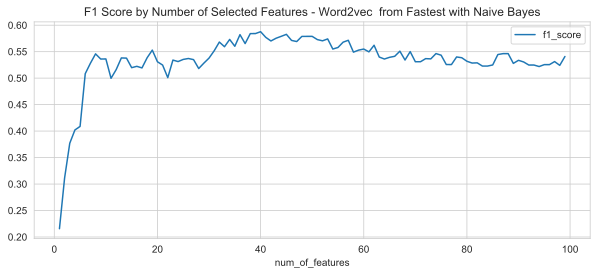

In [98]:
sel_nb_ft_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec  from Fastest with Naive Bayes", figsize=(10, 4))

In [99]:
Opt_no_of_feat = int(sel_nb_ft_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_ft_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
39,40,0.59,0.62
38,39,0.58,0.62
37,38,0.58,0.62
44,45,0.58,0.62
35,36,0.58,0.62


## Benchmarking Word2Vec Fastest with Naive Bayes on Optimal number of Features

In [100]:
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, Opt_no_of_feat, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec from Fastest Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68
7,Word2Vec Naive Bayes Optimal Features Selected: 93,0.68,0.68
8,Word2vec LinearSVC All Features,0.66,0.66
9,Word2Vec LinearSVC Optimal Features Selected: 99,0.67,0.67


## Feature Extraction: Glove Word Embeddings

#### GloVe Embeddings with spaCy

In [101]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [102]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
township,-0.07,-0.05,0.02,-0.75,0.62,0.12,0.46,-0.73,0.14,2.65,-0.56,0.03,-0.33,-0.05,-0.79,...,0.09,0.27,0.10,-0.40,-0.04,-0.24,0.36,0.44,0.61,-0.53,-0.34,0.32,-0.40,-0.60,-0.50
target,-0.35,0.20,-0.50,0.33,0.32,-0.43,-0.27,0.58,0.00,1.80,-0.46,-0.14,-0.27,0.09,0.31,...,-0.31,0.02,-0.18,0.32,0.25,0.02,0.17,0.13,0.34,-0.12,-0.14,-1.23,-0.77,-0.42,0.11
knows,-0.09,0.51,-0.27,-0.11,0.12,0.17,0.06,-0.33,-0.05,2.94,-0.11,-0.12,-0.20,-0.02,-0.20,...,-0.01,0.23,0.12,0.02,0.02,-0.00,-0.18,-0.40,0.14,0.42,-0.27,-0.02,-0.10,0.23,-0.27
blvd,0.59,0.53,0.35,-0.63,0.96,0.09,-0.12,0.70,0.50,0.34,-0.13,-0.32,0.01,-0.43,-0.40,...,0.67,0.44,-0.18,0.25,-0.67,0.04,0.37,-0.29,0.41,0.54,0.57,0.33,-0.71,-0.12,0.36
hawaiian,0.06,-0.01,0.24,-0.16,0.97,0.20,0.26,0.22,0.01,-0.10,-0.27,-0.36,-0.26,-0.02,0.30,...,0.11,-0.30,0.19,0.59,-0.14,0.55,-0.41,0.55,0.38,0.21,0.39,-0.42,-0.18,0.76,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
shes,0.15,0.43,-0.11,0.02,0.09,0.19,0.08,-0.35,-0.11,2.72,-0.30,-0.06,-0.14,-0.39,-0.18,...,0.03,0.11,0.31,-0.00,0.09,0.42,0.10,-0.03,-0.11,0.45,-0.13,-0.01,-0.14,0.32,-0.43
damn,-0.49,-0.17,-0.22,-0.31,-0.08,0.25,0.24,-0.56,0.13,1.50,0.10,-0.11,0.23,-0.19,-0.04,...,0.22,0.13,-0.51,-0.00,0.24,0.17,-0.15,-0.09,-0.28,0.11,-0.11,0.18,0.02,-0.07,0.20
dinning,0.34,-0.59,0.55,-0.85,0.51,0.32,0.38,-0.25,0.01,0.45,-0.31,0.09,-0.45,0.15,-0.22,...,0.13,0.91,0.34,-0.02,0.45,0.59,-0.40,-0.11,0.11,-0.34,0.61,0.36,0.06,0.31,0.12
cocktails,-0.05,-0.18,0.70,-0.52,0.16,0.21,0.14,0.36,0.05,1.22,0.08,-0.04,-0.61,-0.03,0.51,...,0.27,0.66,0.28,0.04,1.03,0.43,-0.03,0.01,0.19,-0.42,-0.23,0.09,-0.56,0.09,-0.15


In [103]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(5103, 300)


#### GloVe Embeddings with Flair

In [104]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [105]:
from flair.embeddings import Sentence

# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')
# embed the sentence with our document embedding
document_embeddings.embed(sentence)
# now check out the embedded sentence.
print(sentence.get_embedding())

tensor([ 2.6582e-01,  1.6299e-01,  1.2293e-01, -7.3254e-02, -5.0829e-02,
        -2.6267e-02, -3.2614e-01, -3.2971e-01, -3.4237e-01, -3.5421e-01,
        -1.8439e-01, -1.1112e-01, -2.2238e-01, -1.9264e-02,  3.3659e-01,
        -9.7605e-02, -1.9163e-01, -1.7008e-02, -3.7130e-02, -1.9043e-01,
        -1.1676e-01, -7.3546e-02, -2.4993e-01, -2.5366e-01, -7.2428e-02,
        -2.2510e-01,  1.2419e-01, -2.6605e-01,  1.0084e-01,  3.2849e-01,
        -1.1656e-02,  2.0859e-01, -1.2907e-01,  5.0421e-01, -1.3695e-01,
         3.7458e-01, -1.0491e-01, -4.7057e-02,  9.7394e-02,  1.5690e-01,
         2.4604e-02, -4.2693e-01,  8.6353e-02, -8.8026e-02,  3.7808e-01,
         6.9695e-02,  1.3650e-01, -3.1272e-01, -3.3535e-01,  1.7029e-01,
         1.5868e-01,  2.7704e-01, -2.0976e-01, -1.0481e-02,  9.7110e-02,
         3.1421e-01,  1.2756e-01,  2.3649e-01,  1.2944e-01,  1.3394e-01,
        -1.0227e-01,  6.9444e-02,  1.0937e-01,  2.1286e-02,  2.6678e-01,
        -1.2288e-01,  2.1465e-02,  8.9795e-02, -5.1

In [106]:
from nltk.tokenize import word_tokenize

def Get_Glove_Features(corpus):
    dataset_size = len(corpus)
    X = np.zeros((dataset_size, 128))
    for iter in range(1, dataset_size + 1):
        text = corpus[iter - 1]
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        X[iter - 1] = sentence.get_embedding().detach().numpy()
    return X

In [107]:
x_train_glove = Get_Glove_Features(X_train)
x_test_glove = Get_Glove_Features(X_test)
print(x_train_glove.shape, x_test_glove.shape)

(750, 128) (250, 128)


In [108]:
pd.DataFrame(x_train_glove)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.27,0.30,0.38,0.21,0.07,0.23,-0.34,-0.07,-0.38,-0.32,-0.25,0.24,-0.11,-0.16,0.40,...,0.54,0.23,-0.13,-0.07,-0.17,-0.28,0.42,-0.07,-0.16,-0.06,-0.19,0.04,-0.14,0.02,0.13
1,0.29,0.04,0.21,0.14,0.07,-0.03,-0.12,-0.33,-0.42,-0.09,-0.22,0.04,0.01,-0.04,0.34,...,0.41,0.28,-0.27,-0.06,0.21,-0.42,0.06,0.03,-0.09,0.04,-0.08,0.19,-0.16,-0.10,0.07
2,0.10,0.20,0.17,0.12,0.28,-0.24,-0.26,-0.13,-0.51,-0.20,-0.27,0.04,-0.01,0.11,0.22,...,0.31,0.17,-0.31,0.16,-0.01,-0.28,0.05,0.06,-0.19,0.14,0.03,-0.08,-0.38,0.10,-0.09
3,0.28,0.30,0.18,0.18,0.00,-0.07,-0.32,-0.33,-0.37,-0.15,-0.17,0.15,-0.15,-0.19,0.24,...,0.32,0.10,-0.14,0.03,0.09,-0.13,0.12,-0.07,-0.01,-0.16,-0.28,0.15,-0.29,-0.12,-0.02
4,0.25,0.19,0.30,0.16,0.16,0.13,-0.20,0.01,-0.27,-0.25,-0.13,0.01,0.06,-0.02,0.19,...,0.39,0.11,-0.20,-0.04,-0.08,-0.21,0.37,0.06,0.00,-0.03,-0.23,0.01,-0.11,-0.10,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.07,0.10,0.19,0.25,-0.02,0.01,-0.08,-0.11,-0.12,-0.24,0.08,-0.01,-0.24,0.06,0.29,...,0.28,0.19,-0.28,-0.03,-0.04,-0.24,0.24,0.06,-0.11,0.03,-0.04,0.26,-0.06,0.18,0.01
746,0.21,0.37,0.32,0.18,0.24,-0.21,-0.22,-0.13,-0.42,-0.21,-0.22,-0.07,-0.01,-0.09,0.12,...,0.33,0.14,-0.15,0.13,-0.12,-0.11,0.20,0.05,-0.15,0.14,0.01,0.01,-0.33,0.13,-0.17
747,0.14,0.49,0.36,0.11,0.30,-0.30,-0.16,-0.17,-0.41,-0.18,-0.18,-0.15,-0.03,0.01,0.07,...,0.31,0.11,-0.19,0.16,-0.02,-0.12,0.16,0.20,-0.20,0.26,0.16,0.06,-0.36,0.13,-0.25
748,0.18,0.31,0.33,0.15,0.22,0.17,-0.23,-0.03,-0.38,-0.38,-0.08,0.12,-0.15,0.05,0.21,...,0.52,0.21,-0.18,0.03,-0.05,-0.29,0.40,0.02,-0.03,0.03,-0.21,0.10,-0.16,0.06,0.03


In [109]:
model_glove_nb = GaussianNB()
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove = Build_Model(model_glove_nb, x_train_glove, y_train, x_test_glove, y_test)
# Save benchmark output
rows_benchmarks.append(["Glove with Naive Bayes All Features", f1_nb_glove, accuracy_nb_glove])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68
7,Word2Vec Naive Bayes Optimal Features Selected: 93,0.68,0.68
8,Word2vec LinearSVC All Features,0.66,0.66
9,Word2Vec LinearSVC Optimal Features Selected: 99,0.67,0.67


## Feature Selection on Glove Features with Naive Bayes Model

In [110]:
rows = []
for i in range(1, 128, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_glove_nb, i, x_train_glove, y_train, x_test_glove, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_glove_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

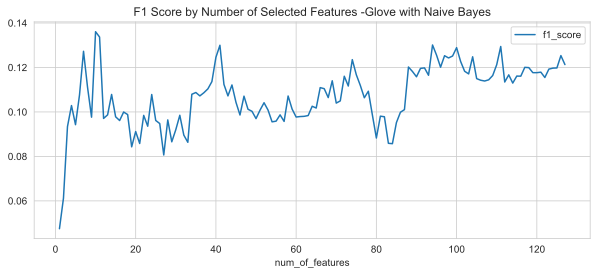

In [111]:
sel_nb_glove_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -Glove with Naive Bayes", figsize=(10, 4))

In [112]:
Opt_no_of_feat = int(sel_nb_glove_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_glove_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
9,10,0.14,0.15
10,11,0.13,0.15
93,94,0.13,0.14
40,41,0.13,0.14
110,111,0.13,0.14


In [113]:
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove  = SelectBestModelFeatures_Chi(model_glove_nb, Opt_no_of_feat, x_train_glove, y_train, x_test_glove, y_test)

# Save benchmark output
rows_benchmarks.append(["Glove Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_glove, accuracy_nb_glove])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.63,0.64
1,BOW Naive Bayes All Features,0.71,0.70
2,BOW Naive Bayes Optimal Features Selected: 4820,0.72,0.72
3,TF-IDF Naive Bayes All Features,0.54,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1500,0.55,0.60
5,TF-IDF LinearSVC All Features,0.66,0.66
6,Word2Vec Naive Bayes All Features,0.68,0.68
7,Word2Vec Naive Bayes Optimal Features Selected: 93,0.68,0.68
8,Word2vec LinearSVC All Features,0.66,0.66
9,Word2Vec LinearSVC Optimal Features Selected: 99,0.67,0.67


In [114]:
cm_nb_glove

array([[3, 1, 2, 0, 2, 0, 2, 3, 0, 0, 0, 1, 2, 2],
       [0, 1, 4, 0, 0, 0, 1, 1, 4, 1, 1, 0, 1, 0],
       [2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 1, 0, 0, 3, 2, 1, 1, 0],
       [0, 1, 1, 2, 8, 4, 1, 0, 0, 1, 1, 1, 1, 0],
       [3, 1, 2, 0, 3, 5, 6, 4, 6, 2, 0, 4, 3, 1],
       [7, 7, 4, 3, 4, 4, 7, 1, 2, 5, 6, 6, 2, 4],
       [1, 2, 2, 0, 0, 4, 0, 2, 4, 1, 0, 0, 1, 2],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0],
       [0, 1, 0, 4, 0, 0, 0, 1, 0, 3, 3, 2, 1, 0],
       [1, 1, 0, 0, 0, 1, 3, 0, 2, 0, 3, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2],
       [0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2]], dtype=int64)

In [115]:
print("Label" + report_nb_glove)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       0.17      0.17      0.17        18
 coffee-ordering-1       0.07      0.05      0.06        19
 coffee-ordering-2       0.00      0.00      0.00        16
      movie-finder       0.18      0.18      0.18        11
   movie-tickets-1       0.38      0.40      0.39        20
   movie-tickets-2       0.12      0.23      0.16        22
   movie-tickets-3       0.11      0.29      0.16        24
  pizza-ordering-1       0.11      0.14      0.12        14
  pizza-ordering-2       0.00      0.00      0.00        23
restaurant-table-1       0.29      0.09      0.14        22
restaurant-table-2       0.20      0.18      0.19        17
restaurant-table-3       0.08      0.06      0.07        16
       uber-lyft-1       0.08      0.07      0.07        15
       uber-lyft-2       0.25      0.15      0.19        13

          accuracy                           0.15       250
         macro avg       0.15    

## Feature Engineering, Extraction and Selection Final Results

#### Best results were produced from the BOW Features with 4820 Features selected using a Naive Bayes Multinomial Model

#### Confusion Matrix Heat Map of the Predictions fron the Best Resulting Features

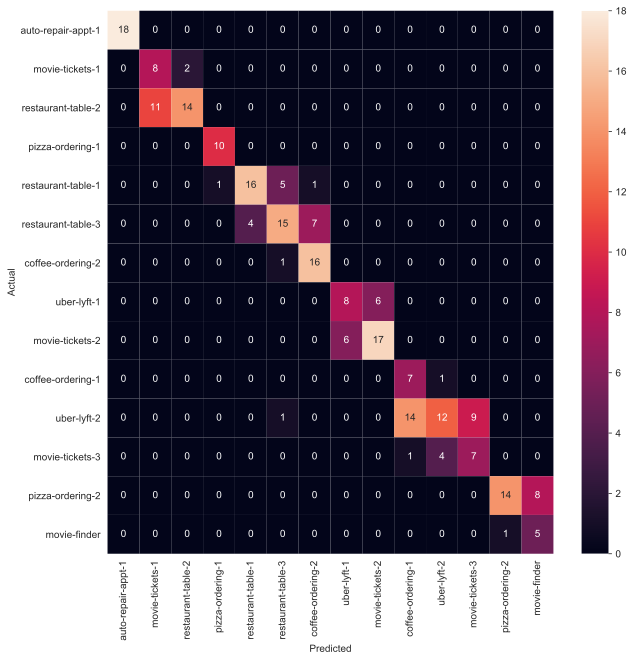

In [151]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_opt_bow, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [120]:
from flair.data import Corpus
from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask


#columns = {0: 'id', 1: 'text'}
columns = {0: 'text'}

sentences_train: List[Sentence] = NLPTaskDataFetcher.read_column_data(X_train, column_name_map=columns)

e john dunn tonight maya restaurant awesome youre best', 'hello sara need book couple rides tomorrow evening ok details first trip wil staying holiday inn oceanside virginia beach need ride amc towncenter hampton virginia ride preference yes would like take uber maximum amount wanting spend trip ok spending ok book uber holiday inn oceanside amc towncenter sounds perfect details second trip second trip need ride amc towncenter pf changs across town need transportation others joining dinner need transportation associates total people want use uber yes uber fine want go cheapest uber option trip since us traveling dinner lets go nicer uber isnt much difference price price range wanting respectful fine paying ok let sure everything correct want uber holiday inn oceanside amc towncenter hampton virginia willing pay part trip second part trip need ride amc towncenter pf changs across town want take nicer uber willing pay everything correct yes everything sounds correct book trips billed acc

FileNotFoundError: [Errno 2] No such file or directory: "['would like order coffee drink mt afternoon break sure coffee shop l order starbucks building fine particular drink mind im mood something sweet chocolatey caramel cloud macchiato cinnamon dolce latte maybe cinnamon latte sounds great hot cold definitely hot size grande fine kind milk want options whole nonfat coconut almond soy ill almond milk whip whip anything else yes add extra shot espresso please okay problem order made drink ready minutes perfect receipt sent mobile phone via text message great thanks', 'hey alice find movie watch sure right home want find movie rent one stream either one fine mmm well maybe would prefer something could stream romance movie dont think im mood romance science fiction really action think im mood something lighter comedy yeah go comedy something sounds fun mind planes trains automobiles doesnt john candy steve martin great ill watch thanks alice problem want suggestions let know', 'hello want buy ticket see glass located today newport oregon okay see one theater newport cinemas yes perfect alright day want see movie want ticket tomorrow night got see two showtimes tomorrow night one pm one pm prefer showing would great okay let check ticket availability showing alright appears tickets available many tickets want purchase two alright options location movie standard showing okay yeah thats fine okay confirm want two tickets pm showing glass newport cinemas thats right tickets purchased total great thank tickets sent mobile device text message okay thanks youre welcome bye goodbye', 'help amount time ride take final destination madison square garden need get station ride estimated minutes cost ride type car would like personal car preferrable fee ride share option ride share available much rideshare fee depending amount people car wait time estimated wait time minutes much would wanted go street subway station fee depending traffic get car take subway station need download app thank get ride anything else help great day', 'need see uber help going sfo need ride fairmont preference car cheapest another passenger besides much luggage carryon economical pool would sharing ride yes need somewhat flexible time wont work whats next choice uberx economy car sounds awesome thanks need car asap car minutes okay put account okay confirmation number gclqvbwmvl thanks', 'hi would like godfather pizza im sorry currently green peppers anything else help make without peppers sure big would like large please im sorry looks like extra large pizza dough would like offer discounted extra large much discount makes price large yeah ill take great special requests yes would like pizza cooked well done pie cut anything else yes also would like extra onions currently enough top pizza none extra ok would ok total anything else would like yes italian beef combo ok yes ok new total even ok pick minutes ok look show reciept ok get send via email text ok ill take text ok send great nice day', 'hello would like place order drink starbucks starbucks store would like order would like order dublin ohio location perimeter drive okay would like would like white chocolate mocha okay size would like grande size would like whipped cream would like white chocolate mocha whipped cream type milk would like made would like drink made nonfat milk modifications drink thank would like order placed would like order placed okay placed order dublin starbucks perimeter drive order ready pickup shortly receipt sent mobile device via text message thank youre welcome nice day bye bye', 'would like get lyft okay wheres location e center ave mooresville nc destination mooresville boulevard mooresville nc usa okay type vehicle shared shared isnt available ok regular fine ok estimate long trip minutes thats fine okay let get scheduled cool ride arrive soon okay get receipt one messaged thanks thank using service', 'hey id like order quick ride jax supposed pick got stuck traffic sure boss tell exactly going im las vegas starbucks downtown im trying get office building nearby big meeting hold let get addresses sure thing okay addresses plaza rd langdon ave suite let know get may ask prefer lyft uber doesnt matter whatevers quicker matter fact let get uberx okay im getting fare estimate uberx starbucks one lambda headquarters office building sound fair little steep check much would lyft order whatevers cheaper quicker one moment okay way intern assistant sorry forgot mention oh thats three people traveling might recommend uberxl instead itll make easier get seating time yeah okay find cheaper uberxl plaza road landon avenue seats mins less discount available company great order ordered im sending dispatch details right minutes wait app phone cant chem yes youre logged company account yes okay cool able see details trip time uber app thanks problem boss good day meeting bye later', 'much coffee cost name coffee starbucks vanti coffee much coffee two tastes white brewed liked order white chocalate mocha white chocalate mocha vanti size rate ok whats amount freshley brewed coffee size liked coffee tall size freshly brewed coffee freshly brewed coffee tall size rate ok order coffee highest cost starbucks pumpkin spice latte limited time vanti size cost coffee vanti size price lowest cost starbucks coffee caffe latte tall size coffee cost caffe latte tall size coffee please list coffee coffee starbucks frappuccino refreshers iced coffee sizes many vereity ice coffee ice coffee us four sizes vereity milk without milk name sizes rates ice coffee tall size grande size venti size trentza size ok order two caffe latt tall size three iced coffee milk venti size ok come take order common quickly thank thank', 'hello need pizza please cassanos location cassanos west chester ohio ok pick delivery pick please would like pick minutes possible would like today want triple pepperoni extra cheese pizza size extra large please type crust thin crust ok thin crust extra large triple pepperoni extra cheese pizza yes correct name would like beau proby ok xlarge thin crust triple pepperoni extra cheese pizza ready beau proby minutes thats perfect card charged receipt texted great good bye good bye', 'think id like take friends steakhouse tonight friends friend dan wife town atlanta thats nice long couple days well want go whats best steak place well theres cypress east bay good steaks yes havent forever check reservations yes please say party four okay ask booth instead table hate sitting middle everything okay would little earlier later work booked sure either suppose whats good place broad near east bay oak yeah thats good place would rather try try cypress first theyre booked try oak okay great thanks well cypress take booth tables open thats later wanted see oak thanks well oak cant take give nice private booth sounds good think eating late ill never get sleep well havent booked either want try somewhere else nah thats okay ill take another time okay', 'would like order ridehsare ride please ok pickup drop locations would like picked house dropped hockey arena hockey arena would like dropped arena nhl team nearest ok got many people party ok would like ride soon possible level service would like whats available area uber uber select lyft lyft lux one would cheapest believe would normal lyft ok please send normal lyft ok would like make stops way stops straigh arena ok ready yes ok sending lyft pick long gets approximately minutes', 'want watch dumbo perfect showing tonight pm movie support alright would still like order tickets yes would want add ons id like credit popcorn alright perfect total price price order two tickets please adjusting two tickets total price perfect needed today yes mam alright order set tonight pm perfect great day', 'need make appointment car looked particular repair shop yes intelligent auto solutions want make appointment soon possible opening tomorrow morning nine um ill need little sooner anything today dont care late theres opening first thing morning nine open thats soonest alright guess ill go one seems trouble vehicle turn corner making clicking sound sound like coming left side think happening turn left alright name phone number appointment melissa number alright ill put information get appointment scheduled thank much problem anything else help thats thank youre welcome', 'hiim thinking reservations restaurantdo guys private seating available hellowelcome nobu yes sir private seating availablewould like reserve table us yeswill march th pm people good yes sir ill glad set youis requests would like include reservation yes siri would like request seated table chair setup versus booth setup apologize sirbut table chair setups groups ok thencan table chair setup outside area im sorry sirbut outdoor seating arrangements unavailable remodeling worrieslets scrap reservationill try another placethank time though alrighti thatsorry couldnt meet needshave great day hello hiwould like book reservation craigs tonight yesbut lets make reservation march th pm peopleis viable yes sir iswhat type seating arrangement would prefer table chair setup private possible yes sir absolutely one thingcan make outdoors absolutelydo requests noall needs met awesomewell well see guests days look foward giving guys best servicehave great day thank youyou', 'book table restaurant course restaurant marakesh st street please problem many people going party four people okay seating preference rounded table please want table tomorrow night pm okay let set thanks turns theyre booked completely tomorrow night would like try someplace else yeah guess toro bravo russell street would like keep details yes please im sorry rounded tables time slot pm available either okay ill wait another day sure yeah okay apologize great evening', 'hello book uber yes travelling destination im going embassy suites greensboro nc pti airport ok problem check options available thank currently request uber x uber xl uber black think uber x fine sure many people requesting ride two people ok great request ride give estimate price fare yes uber x estimated much would uber xl lot luggage uber xl estimated cost ok go ahead order uber xl dont want order car small bags request uber xl transport embassy suites pti airport thanks estimated time arrival yes driver arrive location within ten minutes set account associated phone number sure ride requested check status mobile phone', 'ok need find getting ride ok need get picked going hi need get lyft joes crab shack ann arbor crows nest ann arbor ok let see ok take time ok regular lyft approximately ok get around pm long would take get driver looking look like would take abour minutes get ok well bad longer time due prime time pick ok well thats still fine go trying get placed set ready ok well lets set get ready ok placing lyft joes crab shack crows nest ann arbor yeah thats correct thats people ok add also ok thanks ok set give confirmation email get texts messages driver way ok cool thanks problen glad help', 'hey im going need tickets lego movie second part ok theatre would like see movie want see movie regency village theatre westwood los angeles many tickets would like order im going need two tickets friend showtime thinking going lets pm showtime tonight would like see movie lets ok current prices per ticket adult thats fine book two tickets showtime ticket available would like book different time today yes showtimes available one two tickets available lets showtime would like front row seat seat back id prefer closest seats get ok closest seats available row c ok grab anything else need showtime order tickets please order confirmed tickets sent mobile phone via text message receive shortly great thank much', 'hi able request uber sure wynn las vegas vegas north premium outlet please sure kind car would like lets uberx oh looks like theres uberx around want switch lyft choose different kind car lets uber black great plan go right possible sure lot uber black around wait minutes thats fine want use card account add different one one fine awesome fair okay sounds good okay ive requested uber black fron wynn north outlet las vegas fair driver john minutes awesome track see driver show app phone receipt emailed yes ok thank bye bye', 'hi id like order pizza dominos family sure help request would like order dominos would like memphis bbq chicken pizza ok size pizza would like large ok kind crust would like handtossed crust ok would like make customizations memphis bbq chicken want remove onions onions got would like extra cheese thank complete memphis bbq chicken pizza yes would like add items dominos order thank one pizza ok problem total today acceptable yes im ready place order perfect confirm wanted order large memphis bbq chicken pizza onions dominos correct yes correct awesome pizza order complete pizzas ready pickup minutes receipt sent mobile device via text message thank youre welcome enjoy meal', 'hi id like book table dinner tonight okay city located flint michigan okay type food mood thinking mexican okay preferences somewhere thats cheap good food okay one moment thanks la azteca taco house la familia morales options fit preferences hmm okay higher ratings online la familia morales okay ill book reservation one pm tomorrow many people people okay ive booked table tomorrow pm people thank youre welcome help anything else nope thats thank wonderful day goodbye', 'hi name vickie caufman phone number im calling place order coffee tomorrow morning ok coffee service prefer starbucks peets oh absolutely love starbucks coffee ok kind starbucks coffee want order starbucks store important meeting tomorrow morning thinking espresso macchiato would trick pick union deposit starbucks store oh sounds good special milk types want kind expresso almond coconut soy whole milk milk nonfat milk ill take double shot almond milk size want order sizes offer doppio triple solo quad quad largest size yes believe ok ill take quad size alright im ordering speak union deposit starbucks want pick tomorrow morning ok ive ordered quad sized expresso macchiato double shot almond milk pick tomorrow morning great great thank help problem pleasure im confirming starbucks drink order union deposit starbucks ready pickup receipt sent mobile device via text message good bye', 'know good fine dining restaurants nearby yes houstons south city kitchen excellent please book table houstons course day time would like reserve lets friday evening pm many people two people please indoor outdoor bar seating outdoor patio seating would great special requests make reservation yes birthday celebration please make sure appropriate dessert cake bring table dinner course sir make reservation right away thank please put calendar well im sorry sir houstons outdoor seating pm would prefer another time thanks please try south city kitchen course specifics correct yes thank well take care thank sir reservation south city kitchen confirmed friday pm thank assistance', 'hey assistant theaters showing spiderman spiderverse tonight okay want theaters playing movie san francisco yes find closest theaters times okay amc metreon closest want movie regular one lets go regular showing sure single showing need something later amc van ness showing tonight yes lets need two tickets got two tickets spiderman spiderverse tonight much two tickets want buy yea use fandango account theater accept purchases fandango want order snacks refreshments ahead time ill pass alright ive purchased tickets ill text receipt thanks send directions theater yes ill okay good send carl text showtime location okay sending text carl', 'hello assistant need assistance purchase tickets new dragon ball movie yes course city would like see paramus dont think many people watching okay range options bad news great tell seats available paramus sold guess popular movie showings nearby cities hold let check page loading okay great thanks okay showing movie theater wayne arent sold great tell times showing think would best dont want late tonight okay great im make purchase okay please order two tickets showing wayne yes processing okay great thank much tickets confirmed sending phone display theater thank much good night enjoy movie', 'hey really craving coffee starbucks lexington kentucky could pick something way could would great problem tell want two give second sure thing many options tough pick one sure think gonna go black white mocha sister gets one time good choice thanks make tall whole milk got want whipped cream whip cream please yea dont ever get whip cream something always gives drink odd flavor yea know mean appreciate ordering coffee pleasure nothing gets day going cup coffee starbucks mine either would lost without burst gives know mean alright order placed coffee soon', 'assistant streak houses near options houstons micheal jordans ruth chris make reservations houstons please date time tonight clock many dinning six anyother request one child high chair ok checking sorry houstons opening tonight make reservation micheal jordans clock checking micheal jordans opening tonight make reservation ruth chris clock checking ruth chris openings many seats six still need high chair yes please confirming restaurant set thank welcome goodbye', 'id like place order lyft ride please going picked dropped want picked nsu hpd building going dropped want taken madison street service looking take get shared ride minutes closest minutes lyft ride thats time shared ride ok ill take shared ride ok put shared ride lyft originate nsu hpd building drop madison street sounds correct minutes great ill waiting ride yes today call get place call thank bye bye', 'interested seeing movie us works city location movie theatre th th street works set okay great thank times looking go looking go pm pm okay check dates let know asap unfortunately dont really times available times may pm pm late yes understand tickets left unfortunately tickets left unfortunate yes gonna cancel okay', 'need order lyft heck day need drink ha thinking going hotel breweryive heard good things roy pitz remind hotel youre sureits doubletree still airport city city think called doubletree city center ah yeah ok see one great headed brewery sure let see whats area someone telling place would likei think called roy pitz hmmone secyeah ok roy pitz barrel house yeah sounds right said north expressway yep thats im seeing map great lets yep got one secdo care kind car whatever gets fastest looks like minutes sure whatevers cheapest regular lyft shared one half price might well regular ok ive requested lyft way keep eye phone awesome thanks', 'hi would like book table dinner tonight help type restaurant wanting go mood either mexican italian okay found two eateries high reviews another preference would like add yes want something outdoor area one isnt crowded okay anything else would like something affordable menu items okay looks like mexican restaurant best bet okay name called gonzales outdoor area well high reviews okay take reservations yes many party us dinner okay go ahead reserve thank time would like go around pm sorry nothing available time pm work yes fine okay table gonzales ready pm people thank youre welcome', 'hello siri need help buying tickets watch split help city want movie ill rolling hills area tonight somewhere close theres amc rolling hills let check movie showing location would perfect okay split showing location want standard imax dolby digital think standard good okay showtimes best option okay many tickets want need tickets okay order tickets want purchase person yes please order online okay order amctheaterscom okay great pick tickets box office let order see options okay thank okay ordered emailed link scan theater okay great email yes email receive confirmation minutes youre set split amc rolling hills pm tonight', 'hey lisa need ride airport airport wanting go im fdr international wisconsin avenue im needing get conference ramada oasis address th street northwest stand would prefer uber lyft whats difference personal preference mostly mean difference cost range depending options wicked cheapskate heart desires ok get companies provide pool group ok uber xl taxilyft xl lux mean means would solo rider either van suv gotcha wanna feel like big shot looking spend minute ride uber black suv thats still little high think well always look classier black agree uber black sounds great set charge account wish miserable pain ass', 'id like order pizza help sure tell kind youd like order want large coney dog pizza za pizza gaylord michigan ok let make order thank looks like hot dogs theyre able make coney dog pizza tonight something else order large pepperoni pizza extra sauce cheese ok let place order thank ok order one large pepperoni pizza extra sauce cheese placed wonderful pick pizza minutes great anything else tonight dont think ok good night thanks good bye good bye', 'need get starbucks want order one east chicago avenue chicago want starbucks want one latte macchiato size grande type milk almond anything else drink want whipped cream top currently almond milk type milk want instead whole thats one grande latte macchiato whole milk whipped cream top got total order yeah go order please placed order ready pickup starbucks east chicago avenue shortly receipt sent mobile device help anything else thanks im good enjoy drink', 'book reservation italian restaurant yes specific one olive garden great would like reservation tomorrow night wonderful time pm oh im sorry availability time another time work yes sure many people two great preferences yes get booth window available get table window get booth away window yes one remaining close entrance might get drafty many chairs table get one great take table near window perfect table two nice evening', 'hi want see mule times available tonight hi mule pm pm ill take pm want front row back row something middle ill take anything anything well sure ill take back middle alright ive got great fine yes thats fine thank ok ive got pm sounds good thats one person right yes one person ok please remember come least minutes show begins easily get seat ill sure anything else need thats thank alright enjoy show thanks', 'assistant id like order uber asap pickup dropoff locations im hotel colonnade coral gables need get wynwood convention center uber multiple riders type ride prefer alone shared economical options use pool shared ride others oneway trip least expensive uber take youll alone uber x uber xl large groups would almost oneway took route oh im fine pool option got im booking pick immediately actually need finish getting ready set pick time minutes alright know standard rider initiated cancellation fee understood thanks total tip arranging ride around sounds perfect next front entrance doors hotel ride details show account mobile phone app looked able look ride details thanks ride way check status phone', 'google pizza night sounds like fun take want order pizza got right pizza hut one near house yes ok pizza want lets make large pepperoni mushrooms peppers mean green bell peppers yeah bell peppers type crust want stuffed want extra cheese time want flavored crust flavors garlic butter toasted parmesan garlic butter parmesan italian herbs make garlic butter crust want extra pepperoni yeah extra mushrooms extra peppers ok want order large stuffed crust pepperoni mushroom bell pepper pizza extra pepperoni garlic butter crust thats one baby ill put order oh oh looks like location garlic butter sauce want change crust toasted parmesan make plain ok pizza ready minutes pickup texted receipt phone', 'hey cars acting funny schedule appointment intelligent auto solutions yes make car honda civic ok name leave john smith phone number ok problem ready breaks squeaky ok anything else yes wipers working ok inform urgent yes schedule asap please ok next appointment open hour book hour actually make two ok appointment final yes appoint scheduled car intelligent auto solutions pm ok thanks problem anything else ok', 'think need see someone car schedule appointment sure let get right try new place intelligent auto solutions heard great reviews place sure set currently trying go check engine light keeps going sometimes hear grinding noise sure exactly oh thats definitely good vehicle driving im chevrolet malibu thanks plan bringing guess tomorrow morning alright one moment get set actuallyits bit urgent need car ready monday openings today around lunch time ah actually theres slot open sound thats perfect take lunch break catch ride back alright get set looking bit information confirm thanks youre life saver one thing want give business contact information since company car give name john smith company information great thank ive submitted information set pm appointment intelligent auto solutions check engine light mechanical grinding noise also inspection fee appreciate help ill drop right meeting thank youre welcome im also emailing confirmation sending text reminder great day', 'watch spiderverse city san francisco time want go pm many tickets tickets want watch reald imax imax would wonderful price limit ticket okay found tickets show pm amc newpark movie theater would like order tickets prices snacks amc new park offers full service meals could find price okay would still like confirm order tickets yes would confirmed tickets see spiderman spiderverse amc new park thank welcome goodbye', 'order pizzas papa johns papa johns would like order would like look closest one sure closest one chicago il sounds good ok order papa johns division st would closest many pizzas want order want order large handtossed pizzas ok got kind toppings want want pepperoni green pepper pizzas want sides yes want side hot wings got anything else yes actually add small order cheesy bread sure anything else make order get l bottle coke got thatll pickup yes pickup ok order large handtossed pizzas pepperoni green pepper pizzas order hot wings small cheesy bread l bottle coke papa johns division st chicago il confirmed great thank problem anything else help tonight thats thanks ok details order sent mobile phone via text message order ready pickup minutes bye', 'would like order pizza fired great finding number would like order large pepperoni sausage would like extra cheese would like add anything else get name bob dylan phone number great event much total great ready pick minutes perfect receipt sent via mobile phone text confirm large pepperoni sausage yes place order sir', 'hi want tickets missing link ok missing link showing various locations would like see movie options spokane wa missing link showing different locations spokane ok closet theater northtown mall regal theater closest northtown mall would like tickets location yes want tickets afternoon showing ok please wait check availability ok ok missing link tickets available showing ok anything earlier please wait check request ok unfortunately tickets available earlier times would still like purchase tickets showing today yes please ok tickets saved purchase pm showing missing link ok would like pay location purchase location ok confirm would like tickets missing link pm showing regal theater spokane correct yes ok tickets waiting location name make purchase service window availabe anything else help thanks goodbye goodbye', 'hi assistant get tickets spiderman spiderverse sure city going fresno going fresno ca another fresno fresno ca ok theater would like regal manchester great time would like watch show want pm showing ok got many tickets need seniors children two standard adult tickets alright book two seats theater must reserve seats would prefer seats front middle back want two near middle would prefer center near aisle near center possible ok book tickets pay using credit card thank anything else get unless order popcorn sorry order popcorn soda ok great time movie tonight thank', 'hello want watch spiderman spiderverse ok help many people seeing ok let see whats available thanks playing beverly center would like watch sure showtimes pm pm pm pm lets go pm ok ticket price ok thats fine watching tonight yes ok place order one ticket spiderman spiderverse pm tonight great thanks billed ticket service already perfect thank youre welcome anything else assist thats thanks goodbye', 'car seems please make appointment mechanic ok shop mind yes intelligent auto solutions great cars year make model mazda lx ok name make appointment david pumpkins got phone number reach ok seems problem car overheating puddle coolant car left house morning yikes thats good looks like intelligent auto solutions opening tomorrow afternoon thats going work today available anywhere pmpm lets see whats available noise looks like openings pm pm pm would like schedule appointment one times yes please would prefer today pm ok youre set intelligent auto solutions waiting david pumpkins mazda lx pm today look overheating problem inspection fee due reception anything else thank youre welcome', 'hello get uber course im samosa house culver city ok headed need get egyptian theater hollywood need bigger vehicle theres two us want suv ok uber xl black suv exactly ok checking app thank get black suv culver city samosa house sixteen minutes ok great drivers name derek plate number ok hell driving black cadillac escalade check progress phone via uber app great eta egyptian theater total cost terrific thank much help always pleasure enjoy night', 'hey make dinner reservation nice steakhouse sure preferences location doesnt matter long restaurant upscale serves really good steak ok sounds good ill research get right back thanks ok two best steakhouses recommend argyle carlsbad ruths chris del mar oh wow ive heard great reviews ruths chris business park type area right freeway argyle overlooking lagoon golf course oh wow argyle sounds like going one make reservation ok date time prefer make saturday pm problem many people husband great would prefer private dining room regular table inside table outside well since dark theres point sitting outside lets go private dining room really want impress ok let give call thanks call back confirm dont private dining rooms available another time works ask times available yes opening pm pm put pm slot hang bar reservation great ill call back set reservation', 'would please book tickets see lego movie course city wish view movie las vegas movie theatre prefer book regal summerlin luxury many tickets would like book four please would like book name yes please showtime interested pm showing date would like tickets friday please okay im looking friday showings location dont available showings movie time would like check time slot locations um yes thats fine theres pm showing regal village square stadium would work shall keep looking keep looking dont particularly care location sure okay theres showing regal texas station stadium showing gallery cannery one would prefer galaxy fine ok tickets booked receiving confirmation text soon help anything else okay great thank much youre welcome great night', 'hi place order starbucks sure want pick yes ready counter would great absolutely starbucks want order new one main telegraph thanks okay would like americano please okay americano size order would like grande want hot iced hot please grande americano want room cream yes put little bit steamed almond milk top normally could currently almond milk type milk want substitute kinds nondairy milk also soy milk coconut milk take steamed coconut milk top thanks okay order grande americano steamed coconut milk top placed order ready minutes great thank time receipt texted shortly enjoy', 'hey id like get coffee starbucks okay located near pearlridge mall okay theres store located inside mall yep thats one would like grande flat white kind milk whole milk toppings nope sorry seems whole milk okay please one grande flat white milk toppings yep thats total itll ready pickup minutes great thanks anything else today nope great enjoy coffee', 'id like order food lunch would like eat today decided wanted get pizzas want order want place order anthonys coal fired pizza would like order want start salads order arugula salad burrata classic italian salad else would like go want two pizzas go sizes would like want get two larges one fresh mozzarella sliced tomato basil pizza got one next one want paulies pie hot peppers would like anything else thats order address delivered delivered office ft lauderdale ill paying use chase debit card last four total everything came order within minutes thank thats youre welcome', 'hey able book tickets see shazam sure near house oh well portland please find tickets around area cool plan go friday th sure lot avaiable slots want go night evening evening please dinner pm sound thats little late anything earlier theres one pm oh sounds good lets go theater regal lloyd center imax awesome oh pm ones youre getting imax oh thats gonna work want actually one pm well lets go one okay tickets shazam pm friday april th regal lloyd center imax portland correct awesome total sounds good great ive booked tickets youll receive online tickets email confirmation soon', 'need ride today lyft please wish travel wish travel radisson hotel harrisburg camp hill bypass camp hill pa pennsylvania state capitol complex north rd street harrisburg pa check type vehicle would like id like get suv preferably supersized ride im sorry dont suv offer supersized ride xl options also lyft personal ride much little less expensive sounds pretty good long ride ride minutes sounds great book card file yes please booked ride coming soon way great check mobile phone updates thanks nice day', 'hello wanted order coffee starbucks help sure thank account saved computer want order one house okay let look thank se santiam hwy albany thats correct okay would like wanted americano size large please anything else want splash almond milk stevias please okay let put okay thank order placed itll starbucks santiam thank long ready minutes anything else need thank help good day thank', 'could set lyft sure ronnies lindbergh maplewood walmart okay anyone else going riding okay would like ride come get minutes please ride type would like standard one basic lyft option yes okay thats gonna right thats fine would like driver meet side lot movie theater anything else need confirm want basic uber ride ronnies maplewood walmart minutes thats correct okay ride confirmed', 'want order drink starbucks sure thing location would want one close office picking yes using regular account yes use one kind drink would like want pumpkin spice latte said dont thanksgiving christmas shame really like give moment sure want another kind coffee would want order lets get caramel macchiato size would want largest one hae order place drink ready pick soon receipt sent phone thank welcome', 'want make restaurant reservation friday night okay would like reserve robert columbus circle okay friday nd yes many people need table time would like pm special request yes want park view unfortunately robert availability pm pm availability friday pm late try landmac time warner center yes landmarc friday yes pm special request yes id like table window many people table okay landmarc reserved table pm friday thank receive email conformation shortly great bye bye', 'haley need two pizzas dominos ok one closer us yes summer st boston ok size toppings want pepperoni olives one mushrooms bell peppers crusts would like regular one extra crispy one mushrooms bell peppers inch mean regular hand tossed large one thin crust yeswhat come need pick sauce cheese regular got pick yes please ok promo comes ok want coke garlic bread thats ok order pepperoni olives mushrooms wirh bell peppers different crustsbilled card file ready minutes thank see receipt phone hear text must bye bye', 'hey favor request uber sure going im little tokyo right want go beverly hills specific address beverly hills beverly hills general im going shopping sure kind uber would like im hurry lets uber pool oh looks like theres uber pool around want switch different kind lets uber black okay exact current location im miyako hotel little tokyo going beverly hills correct yes want picked right yeah im ready go okay uber black miyako hotel little tokyo beverly hills correct yes cool fare get uber minutes', 'would like order something bosses pizza put order sure let know want need order like location fort worth look menu real quick okay take time problem okay okay bosses lake worth blvd fort worth tx okay sounds good okay would like want small thin crust pizza black olives pepperoni green olives moment okay yes okay also add extra cheese please okay problem thanks much okay putting order thank much okay done okay thats great name yes name ready go anything else thats perfect thank much help thank lovely day', 'hi need tickets watch dumbo movie yes city vallejo please course many movie dumbo sorry today okay pet cemetery okay preferred time pm sorry available okay dont want tickets today im sorry anything else alright change mind let know okay sounds good sorry thanks good day', 'hi id like reserve table tonight pm hi would glad help unfortunately nothing available ok perhaps come bit earlier ok let check reservation list great pizza yes would like reserve table ok great many people party four one child ok need highchair child ok would like sit outdoor seating yes would like fine wine byob provide wine glasses ok reserve table pm yes fine great tell crowded friday night generally quite busy ok wait long even reservation maybe minutes ok fine guess ok would like know anything else make reservation oh wait fresh fish menu fish dishes sounds great see seven thanks calling', 'two tickets lego movie please city want watch movie los angeles california preference theatre arc light theatre please time would like showing pm please would like see feature thanks capacity theatre getting full would like try different time theatre whats capacity still want see show time yeah thats fine okay bring tickets tickets sent send mobile number okay tickets sending thanks tickets sent anything else today thanks great nice day enjoy movie', 'assistant need order coffee starbucks store want neil st champaign ok picking yes would like first drink grande iced cinnamon cloud macchiato ok else second drink grande cinnamon dolce latte ok anything else know think ill take bagel cream cheese toasted yes got anything else nope total going charged account thats fine ok ready pickup minutes thanks send receipt email got thanks', 'hey need coffee asap okay want starbucks n monroe st franklin st yes n monroe get grande iced caramel macchiato milk extra pump caramel okay lady informed caramel would like instead ugh um im drive need make mind else could get frappuccino nah oh theyve got iced skinny mocha whatcha think hmm sure alright milk yeah sounds good okay make sure spell name right kinda yelled haha nice got drink im leaving okay thank problem', 'hey jose ben well hello mr ben mrs ben night thought would take kids go see captain marvel tonight wow sounds like alot fun help well driving get tickets reserved oh yeah course canso tickets assuming idea time yep children tickets id prefer showtime sometime around ok look tickets theater mind hoping silverspot cinema miami ok checked shockingly showtimes close time close location sorry oh wow thats bummer well give next best option looking like regal cinemas south beach imax imax showing work yes shold fine ok tickets going together regal south beach stadium imax imax showing captain marvel correct yes sounds fine adress lincoln rd miami beach fl anything else need reschudle next showing yes one hour grace period ok wow great thank much jose welcome hopr wonderful time wonderful night', 'please order starbucks caramel machiatto starbucks would prefer pickup starbucks peachtree st closest size would like make large size thanks sweetener yes two packets cane sugar side thanks standard milk lowfat standard works whipped cream yes thats best part definitely whipped cream called place order told unavailable youre kidding right sir may order something else instead suppose caramel cloud machiatto instead size options yes please placed order ready pickup minutes thank appreciate assistance youre welcome sir pleasure', 'hey howre morning listen ive decided definitely need great cup coffee get day started sure im fine thanks location would prefer order today im thinking coffee local starbucks inside kroger marketplace location need sure place order online right away thatd great need strong coffee lots flavor caffeine would like order usual coffee drink actually think id like try one new seasonal coffee options time oh according website currently offering caramel brulee lattes black white mocha wow sound great think id really like try caramel brulee latte okay size would like venti course bigger stronger better type milk want would like extra flavoring whipped cream top would like whole milk definitely lots whip top extra shot espresso possible please sugar honey would like either drink side thanks venti caramel brulee latte whole milk lots whip top extra shot espresso ok got credit card already file location ill go ahead place order great cant wait try thank much drink order starbucks location requested ready shortly expect receive text message phone receipt soon thanks really appreciate problem welcome anything else get nope thats thanks pleasure enjoy coffee', 'need schedule car appointment asap im serious car issues right whats happening boss car honestly fire smoke coming engine pulled let cool started driving thing okay auto shop want call intelligent auto solutions booked today try somewhere else place take car dont rip honest pm tomorrow dont know want wait though tell car fire get always asking car tell white toyota camry year okay asking time would want bring right cant see right need options see squeeze damn emergency car fire pm even pm cant pm wont give enough time anything today pm said work whats best number reach tell emma gray number scheduled intelligent auto solutions today pm white toyota camry evaluated smoke coming engine said quote rough estimate looking dang seems like lot look said apply whatever repairs costs nice awesome thanks good luck stay safe', 'buy tickets fighting family would like see charlotte north carolina tonight please tonight studio movie grill epicentre regal phillips place stadium ayrsley grand cinemas amc carolina pavilion cinema would like see studio movie grill epicentre fighting family pm pm time would like go pm please many full price adult tickets would like would like type ticket would like reserve seats yes middle back row seats together book standard seats row luxury seats row n row standard seats please confirm want standard adult tickets see fighting family studio movie grill epicentre charlotte north carolina pm tonight yes thats right pay credit card debit card credit card please tickets fighting family charged credit card total cost thanks text confirmation tickets sent phone thanks bye', 'hey us playing tonight look chicago yes us playing tonight pm pet cemetary pm ooh pet cemetery sounds good one book pet cemetary id like popcorn buy ticket popcorn actually think would rather see us book ticket popcorn us pm yes terrible ok booked pm actaully stop cancel reservation yes please cancelling reservation got call work gota cancel laura call laura text pls texing laura tell im sorry movies tonight texting laura thanks thing else', 'hey google buy ticket captain marvel ok location want watch amc new york ok thats amc new york new york right yes place us prime yes course thats prime right yes friend yes christine ok thats two people right yes two tickets ok available time pm ok yes ok pm sit want watch movie im thinking middle mostly section e f section available sit available sit right wont separated friend f f one would like hmmm real vacancy time would pm yes couple sits available real time want order tickets real instead hmmm go back prime instead ok got sit want watch movie im thinking ok make sure thats right yes thats correct thats decided ok amc new york new york time sits correct yes text message couple minutes ticket bought recipe ok thank problem thankful use google assistant thank great time watching movie', 'show itialian restuarants ok found italian restaurants bertollis make reservation bertollis wednesday pm people making reservation pm available would like pm pm available pm also available ok cancel reservation okay would like next show itailan restaurants near okay next restaurant olive garden next one okay next restaurant marzillis please make reservation marziliis wednesday pm people yes okay reservation booked marzillis pm wednesday guests thank pleasure anything else assist thank great evening', 'would like order large pizza stone oven pizza okay type pizza would like would like smokehouse pizza okay anything else want add yes smokehouse pizza tell onions instead want extra bacon alright anything else want add yes add another large pizza order okay would like type pizza want classic cheese pizza would like add yes alright stone oven pizza plaza parkway yes sounds good input order long take take approximately minutes pizza ready okay thank youre welcome anything else get thank okay receipt sent via text message', 'hey get pizza pizza hut real quick sure kind pizza want large pan pepperoni pizza extra cheese large pan pepperoni pizza extra cheese yes mean like personal pan large pan large pan okay would money yes would paying cash credit card credit card one capital one card alright want pizza want asap take minutes drive nearest pizza hut probably take minutes make pizza alright sounds good ill let know finish order alright thanks problem completed order ill able pick pizza minutes', 'think could order pizza pick dominos sure tell size youd like lets see still large topping actually toppings yes let get sure thing would like toppings hmm give spinach chicken jalapenos okay thing else yeah tell garlic parm sauce instead regular also add cheddar cheese itll additional thats fine okay let make sure correct want get large topping deal yes hand tossed thin hand tossed okay large hand tossed garlic parm sauce chicken jalapenos spinach cheddar cheese correct yep got fantastic ordered account name receipt sent via mobile ready minutes thank help time thing else help nope youve helped quite enough thanks great night problem good night well goodbye bye', 'hey id like order pizza lunch marcos sounds good ok ill order want think ill pepperoni green peppers make sure get garlic butter parmesan crust ok size pizza want regular pepperoni small ones hmm lets go medium definitely small pepperonis alright let find number ah go guess green peppers want onion instead yeah would ok guess ill let know ok want medium pizza mini pepperoni onion garlic butter parmesan crust yep set said total send receipt via text oh thats cool ok say long yeah ready pick minutes perfect havent marcos know long time since ordered hey thanks taking care problem ill see half hour sounds good thank youre welcome', 'want buy tickets pet sematary ok theater prefer want one serves alcohol movies reclining loungers malco movies reclining loungers doesnt serve alcohol fiesta serves alcohol recliners doesnt movies right ok lets go fiesta ok many tickets want need two showing prefer want pm showing im sorry sold still tickets available ok ill take ive booked two tickets pet sematary showing good need address driving directions address fine fiesta square w college ok total tickets texted great bye goodbye', 'order coffee peets please sure would like pick se mill plain blvd vancouver wa please okay problem would like would like medium almond mild caramel macchiato please okay great oh half sweet please okay want medium half sweet almond milk caramel macchiato yes please sounds good get ordered right away thanks picking mill plain location yes okay great anything else get thank time okay great ready pick shortly thank much nice day', 'would like reserve table red lobster okay details need friday night many people four okay time make around pm would prefer table booth would prefer table booked times okay pm instead also booked time okay would like go olive garden instead okay sounds good want details requests okay request reservation okay thank reservation set okay thank problem', 'hi want book table two burrito dungeon table must outdoor seating high chair kid reserve pm march sir im sorry burrito dungeon doesnt outdoor tables available time thats okay get indoor table high chair im sorry sir thats also available sure id really like go burrito dungeon positive sir even tried little low grade bribery effect drats okay try seafood bonanza time must get table outdoors high chair well sir booked seafood bonanza march th pm youre sure required options available table yes sir checked twice excellent goodbye one question sir fond burrito dungeon hate admit think shark tank shark tank yes miles fully grown hammerhead shark dont ask might expect find seafood bonanza instead sir come think youre right seafood bonanzo come table sing spanish birthday well thats strange go figure nice job miles pleasure sir', 'im interesting general american fare seafood location im san diego area moment many party two time would like eat around pm restaurants mind id like see something available juniper ivy ok let see whats available problem unfortunately arent seats available time requested ok another restaurant water grill san diego theres seating available restaurant either thats shame think ill hold getting reservations problem need anything else ok im sorry couldnt help ok good day', 'need try get car intelligent auto solutions asap ok seems problem well car making loud clunk turn well thats good lets see get ok lets start make model year car ok nissan rogue ok case color black ok want try get shop id like try soon possible ok checking availability seems try get tomorrow ok works ill drop able see yes get inspected ok good dont wanna drive much since sounds bad understandable ok charge inspection yes fee inspection rolled final bill choose get vehicle repaired ok well thats fine long get fixed asap ok set get phone number get case contact ok set tomorrow ok thank problem goodbye', 'jane think order medium caramel frappe starbucks want caramel frappe starbucks say correct maybe order couple pizzas beggars well okay caramel frappe starbucks pizzas beggars yes fine kind pizzas sizes good question vegetarians vegans office believe okay safe side get three sounds good pizzas mind sausage pepperoni plain cheese pizza alright sizes make family sized pizzas okay want medium caramel frappe starbucks thats right family sausage family size pepperoni family size cheese pizza beggars correct correct would like paid information file great place order thank order placed ready minutes pickup also receipt sent via email sound good thank go get shortly', 'would like make restaurant reservation place mind would like go bricks reno ok many people need tomorrow pm people anything else yes must booth sorry sir available problem booth people ok lets try another place ok thanks restaurant rapscallion also reno would like specifics yes sorry sir anything available tomorrow night would like another night nevermind going cancel ok sorry could help find reservation goodbye', 'hi amy need set dinner sure boss give details would take wife dinner friday night lost kitchen freedom maine sounds good time would like eat anytime would great understand lets make sure details wife would like eat lost kitchen freedom maine friday sometime correct special request see moment please thanks minutes pass sorry boss lost kitchen freedom available reservations friday well guess eat little later please see lost kitchen table available certainly try please wait problem thanks sorry tables available time requested well lets see different restaurant wanting try please call frontier restaurant see get table two friday anytime okay try thanks success reservation frontier restaurant brunswick maine table two friday wonderful thanks amy help happy help please enjoy dinner', 'hi may help looking reservation tomorrow okay many peopletime resturant please people pm want bbq restaurant close okay let look hold ok lucilles smokehouse dickeys bbq pitt ok good choices lets try dickeys okay darn booked okay lets try lucilles smokehouse okay open reservation want deposit oh thats good sorry well much deposit yes dollar hold oh yeah sorry well reduce people party better going price okay want try another place sure yes well help let know alright good one', 'hello need request uber heading im heading kayne prime nashville heard place amazing heading best steak house must go next time nashville im staying sheraton downtown nashville bad ride particular uber car prefer usually get uber black super nice always get great drivers care wait depends long dont want wait long car pm reservation understandable uber blacks available right joke must concert hockey game happening city available theres uberxl available minute wait anything shorter wait uber minute wait figures cost plus surcharge since one busiest times makes sense dont really choice cant late dinner reservations ill go ahead book thank car way check status cell awesome', 'hi john could look tickets movie hi sure ill look online want see im going buffalo evening ok let look theaters available buffalo want see movie would prefer tickets evening possible ok ive found tickets maple ridge market arcade amc theaters prefer lets maple ridge one alright showings pm pm pm lets pm one alright get tickets guests one person alright pm showing one ticket left would pm pm showing work yes lets go pm showing pm showing would like find showing yes please alright looks like pm showing maple ridge theres pm showing market arcade thats prefer lets go market arcade one great go ahead book tickets unless theres anything else wanted specify thats ok youre booked pm showing amc market arcade one guest details texted phone shortly anything else need thats thanks john youre welcome bye goodbye', 'id like buy tickets avengers endgame tonight city buying tickets want get pembrooke pines theater pembrooke pines amc pembrooke lakes mall many tickets looking get im looking get two tickets pm showing imaxd dont showings time imaxd one pm pm showing imax dont either pm showing time ill take pm showing imaxd anything else tickets get vip section reclining chairs food thats sold serve beers alcohol yes allowed get adult beverages ok well two tickets se avengers endgame tonight pm imaxd amc pembrooke lakes mall correct yes use amc gift card pay tickets ok order processed', 'hi thinking going see shazam today buy two tickets see together oh thats nice movie city going see pheonix ok great theater think want go amc arizona center time pm much bad price wan see movie think see regular movie probably special effects worth seeing probably right think try book movie thanks oh looks like sold pm shazam want see another movie darn booking movie captain marvel pm heard good movie try book movie thanks ok movie also booked pm want see something else oh never mind kind frustrating wanted see movie pm oh sorry hear well least tried thank trying welcome', 'hey im looking movie watch okay want watch im sure yet want something funny type comedy looking mean different categories choose romantic comedy parodies dark humor name think want watch romantic comedy great actor mind im thinking sandra bullock movie cant remember name else movie think ryan reynold think narrowed looking proposal starring sandra bullock ryan reynolds thats one perfect anything else help thank im glad help', 'hello sam hey well really need help help need find restaurant week okay day hoping well friday okay need reservation either bjs pf changs okay let look see find something date time would like reservation around pm okay make pm okay problem would like us room possible alright well bjs booked p f changs openings good well would perfer bjs okay would like try different day yeah move saturday pm okay saturday pm bjs available awesome would like anything else okay reservation bjs pm yes guest yes got guest okay thanks allrighty set going fee reservation details sent phone good day', 'want go see glass weekend cacn find tickets sure city would like see want take roaadtrip find tickets lansing mi got many tickets looking well itll son two please sounds fun day would like go im thinking probably sunday january th got specific timeframe would like go anytime pm pm would work ok sounds good theater requirements would like check would really like place reclining seats possible oh sounds relaxing anything else look think covers got ok option ncg lansing cinema starting pm celebration cinema lansing imax pm would like info either yes please much tickets place ncg cinema purchase tickets imax theater slightly higher information really meet requirements though yes would like purchase tickets either places yes go ahead purchase cheaper ones ncg please use debit card ending complete purchase yes please ok tickets purchased sent email along receipt containing confirmation code thank youre welcome', 'hi want book movie tickets fighting family okay city seeing movie itll lincoln ne great many tickets need two either senior childrens tickets adults looking day time evening evening theater preference marcus lincoln grand cinema looks like options showing showing showing awesome lets pm showing okay confirm want two adult tickets showing fighting family marcus lincoln grand cinema yep thats right great looks like two tickets sounds great thank help problem wait get tickets sort confirmation yes get text code ticket taker scan thanks enjoy movie', 'get caramel machiado upside sure starbucks peets starbucks ok size please get grande ok starbucks whilshire okay sure stop get way home forgot ask would like hot iced iced please frapuchino iced dont like whipped sounds good anything else pastries thank drink ok called caramel would like different drink yes please cinamon dolce latee grande well yes grande whip cream please hold whip cream ok set repeat order sure grade cinamon dolce latte whip cream perfect receiving text receipt well order confirmation got thank', 'hello help order pizza dominos sure want want xlarge pacific veggie pizza dominos shop prefer want one douglas road problem second let check want brooklyn style hand tossed hand tossed please sorry pacific veggie pizza stock today want something else please order philly cheese steak pizza also xlarge hand tossed okay confirmed order one xlarge hand tossed philly cheese steak pizza great please use dominos account pay bill sure pizza order complete excellent pizza ready pickup minutes got receipt sent mobile phone via text message problem anything else help thank welcome', 'hey sarah need two tickets see dumbo tonight ummmokay heck miami beach even want know playing right yeah everywhere time seven dinner five seven good time okay theres seven seventhirty seven good many two wife uhme friend see okay im going buy two tickets dumbo sevenregal cinemas south beach wait right didnt say theres imax seven wants wants see okay theres show pm damn um okay make pm well dinner later okay im buying two pick door great thanks whats place regal cinemas south beach lincoln rd cool pm said yes thats correct anything else ship box condoms really funny good night thanks bye', 'thinking going movies tonight help sure movie mind thinking going see alita battle angel nice choice seeing town greensboro lets seedefinitely town time interested seeing movie anything specific yeah dont get pm run errands lets go something late night surelets seeand many accompanying ill taking one friend want pay ticket go ahead purchase tickets alright special arrangements accommodations searching think thats find latest showing theaters pm since weekday fine yes thats perfect work great one moment confirm everything great thank alright tickets greensboro theater booked pm movie alita battle angel great youre best assistant aw thank total texting confirmation receipt details mobile device way look everything set reminder great thank much wonderful day goodbye', 'hey need table nice restaurant th preferably variety seafood meat options see flemings downtown table youd like yes please okay time pm okay special preferences requests yeah make sure give us high top table okay dont high tops available night fine well take booth apparently available option standard table fit six remaining available booths wont work forget make table j alexanders instead okay people correct yes thats correct raised booth youd prefer option yes high top booth book one okay anything else long accommodate time table request okay j alexanders fulfill requests additional requests correct thats correct thank okay welcome table booked people high top booth th j alexander', 'good morning renee would like make reservations couples linos would pleasure would like book private room couples friday pm ok call linos reserve table thanks mr john doe called linos private room table available pm friday night ok think okay call back reserve space okay thank okay let go details would like table couples private room friday night pm ok thank trying something extra special close friends understand anything else yes could ask could bring cake celebration sure thanks mr john doe called linos reserved table private room five couples friday night pm also asked bringing cake celebration said bring cake would without renee thank much thank mr john doe welcome enjoy time friends great day thanks help great day', 'hey johnny need book appointment intelligent auto solutions sure thing let see open user interface okay issue brakes grinding need fixed immediately oh dear let see pull soon possible please making awful sound afraid stop working second okay interface asking make model year could tell please car toyota camry okay also need contact information asking name email address phone number name darlene sigsby number email darlenesygsbyaolcom need get car immediately hopefully today okay information entered availability would rather get done sooner later since form transportation okay earliest see website would tomorrow afternoon booked morning today could please please please call see could get earlier booking emergency see okay back said could drop car afternoon make pm going work today said issue something take long today need new calipers might wait tomorrow oh thank much would like verify appointment intelligence auto solutions pm today driving toyota corolla name darlene sigsby email darlenesygsbyaolcom number okay inspection fee dollars correct except fact car toyota camry ah apologies okay correct information thank much help problem see', 'im looking great new italian restaurant would like go would like go friday th anyone accompanying yes im going fiance time would like go need somewhere pm anything else oh yea need private booth ive found highly rated restaurant near barcelones eatery near home regular tables booths available night okay booths available earlier day im sorry arent available friday okay find different place found one even better reviews called guiseppes also private booth available friday perfect well one ill go ahead book reservation thank problem', 'hey im heading home bit im going grab pizza pizza zone way wife kids order ill grab way yeah location going pick one freeway forgot name street let look locations real quick one branson street yeah thats okay want order deals right well many pizzas want probably large pizzas okay buy one get one half deal unlimited toppings okay alright toppings want one veggie bell peppers onions tomatoes olives get pepperoni sausage extra cheese crusts stuffed crust right yes okay one stuffed crust one hand tossed want stuffed crust pepperoni sausage one okay sides sauces yeah get couple marinara garlics dont sides okay large pizzas one stuffed crust pepperoni sausage extra cheese hand tossed crust bell peppers onions tomatoes olives plus marinara garlic sauces yep alright ordered itll ready minutes theyll text receipt great thanks much youre welcome', 'hey pete whats good man chance could call starbucks order iced vanilla bean coconutmilk latte terrence yeah sure thing one want set lol yeah guess kind matters lets go one across street mcdonalds sounds good need anything special going vanilla rofl nah actually think going try soy milk time ive really pushing coconut lately okay sounds good ill put order thanks lot pete know dont want hear drink thank god dont soy left oh thats bad ways drink cat sure ive heard one want swap well looks like starbucks gods smiled upon mean sir ill take standard said vanilla rendition oh oh think forgot ask size ahh yeah lets go venti go big go home right yeah right okay thats venti iced vanilla bean coconut milk latte yup thatll add something ohthanks looks like ill make double sounds good ill let go chao', 'mandy favor schedule appointment car sure problem car want take would like let intelligent auto solutions take look get squeeling noise put foot brakes repair shop merury drive campden township blue harbor thats one would like take car basically free right see could get someone get office around pm basically pick car morning shall need car meeting tomorrow pm see get soon possible pm today ok make note pickup driver car parked driveway home keys front seat well make model car volvo x suv whats address pringle lane harrisburg pa initial inspection fee thats ok confirming pm car picked pringle lane harrisburg repair due squeeling sound put feet brakes keys front seat car location car volvo x suv thats correct thank great day', 'id like get uber xl ride going want picked club euro dropped johnson street estimated fare dollars fine long im going put see uber xl available right would like something else uber x available anytime soon yes one club euro within next minutes ill take one many passengers accompanying going going paying money left gift card balance use remainder card charge rest debit card ok let book ride ok thank ride set uber x picking club euro taking johnson street within next minutes yes nice evening', 'craving sushi sushi always nice want pick want book reservation want book reservation dinner restaurant would want book want book reservation imanas tei many ten time oclock let contact take time talk fully booked time dont take reservation lets try another restaurant restaurant thinking gakus also fully booked know lets cancel booking table throwing sushi party house invited honored last time attended sushi party place amazing cooking time well one guest mine friend trained sushi chef told prepare tonights dinner see see', 'hey order pizza papa johns im buddy tonight think want pizza sure kind pizza want well im actually really sure likes pizza sausage ham pepperoni know like classic cheese could order half toppings half cheese oh yeah youre right thinking might order two pizzas one split middle would perfect half sausage ham pepperoni half cheese could get meat lovers friends half would easier order would add bacon oh yeah seem easier meat better size want get think large would good sure know put away pizza extra larges yeah might well get extra large love leftover pizza anyways want regular crust right thin crust stuffed crust actually love good stuffed crust extra large stuffed crust half meat lovers half extra cheese yeah sounds right im looking website actually deal get two medium pizzas want instead actually saw something said get pizza large pizza two medium pizzas something area something know never good math ill stick extra large okay ill order right get receipt sent phone text sounds good order complete go pick minutes thanks ya know talk pizza made hungry really cant wait eat', 'want really nice seafood restaurant sounds good want eat brigantine la mesa yes brigantine good would like go friday march ok time pm many party us ok people pm friday march yes want sit outside nice weather looks like available tables outside pm ok change time tables available outside pm oh lets try bo beaus ok bo beaus pm people friday march yes still want sit outside yes ok looks like availability day great would like book reservation yes please ok set thank', 'hi need taxi service yeah pleasure thank pickup sir pick harvest many taxis want sir need taxis special formal occasion yes delegated occasion offering scheme events choose brand car want ride awesome brand car want sir brands offering yeah sure sir top brand carsincluding bentley thats fabulous book bentley cars destination sir birmingham date sir coming friday time pick sir think around ok sir arrive time sir cost per vehicle per vehicle please time yeah sure sir thank thank sir come', 'hey could pick latte peets starbucks peets coffee starbucks wards road lynchburg va would like hazelnut raspberry latte hot cold hot size grande kind milk whole milk regular sweet half sweet half sweet would like ready minutes whipped cream anything else youd like order thanks latte would like ready pick minutes okay drink order ready pick starbucks wards road minutes receipt texted device thank', 'hey im thinking going movies friend tonight order tickets course want go riverfill pikeville kentucky movie interested shazam problem many tickets need two need late showtime pm im sorry looks like latest showing pm okay yeah make work want see well im sorry showtime actually pm okay theres way want see different movie maybe yes captain marvel captain marvel playing pm thats late thats perfect alright two tickets captain marvel pm much tickets theyre total came sounds good thanks problem theyre sending tickets phone via text awesome good night enjoy movie', 'boylston area order two pizzas dominos size toppings large pepperoni mushrooms one olives tomatoes type crust type sauce regular sauce hand tossed crust ok cheese mozzarella regular ok toppings green olives tomatoes one green olives available black ok trying come delivery pick comes special tax yes ready pick mins ok thanks bye gotten email get text ready app shows pie assembled thanks itbye haley', 'hi assistant id like order coffee starbucks hi location works best one cupertino stevens creek de anza boulevard ok drink would like caff latte please size biggest one whats called venti yes one ok type milk would like soy milk ok placing order thank im sorry ran soy milk another type milk youd like almond milk yes ok lets go ok ordering venti caff latte almond milk thanks ok order ready ten minutes starbucks stevens creek de anza receipt sent mobile device via text thank youre welcome nice day', 'book tickets movie shazam location amc river east amc river east e illinois st chicago il correct yes time want watch movie pm standard many adult tickets many kids tickets many senior tickets show available pm shall book time check anything earlier standard show available pm shall book time yes sorry pm show enough seats available try pm pm book pm confirmed tickets shazam amc river east pm standard show tickets sent mobile device text message thank', 'weve caffe americano two please sure sir location hotel oh really nice like sit fresh air place one get table window please sure one unreserved oh nice would like something start weve two caffe americano starters starters thank ready order main course sir ya youve special day like place sir dont special day ok problem weve want cake small medium large medium please dishes sir would like two portions chocolate cake way large portions two portions would fine two would recommend anything else specialty place would recommend thin crust apple pie quite popular ok please get portion well split two sure sir yeah make fast get anything else thank stuffed oh nice sir please get us bill check thank pleasure serving', 'hi help book table next friday sure id like table big buck brewery gaylord michigan ok tell requests six us wed like table friday night pm would prefer high top table instead booth let see arrange thank cant get time theyre booked different restaurant sure mind arrange table alpine tavern sure requests yes hold minute ill check thank looks like theyre booked guess try plan another day anything else thanks im going check friends see think ok good day', 'id like put order pick starbucks location plan using im davie want use location nsu ok want order want order venti iced white mocha frappuccino type milk want want use soy milk would like whipped cream yes want extra whipped cream yes dont soy milk almond milk yes almond milk get almond milk instead soy want pay gift card debit card use gift card empty order put thank one venti iced mocha frappuccino extra whipped cream almond milk ready minutes pick', 'would like coffee starbucks okay city charlotte nc sure thing referring n tryon st charlotte nc yes okay would like order venti lattee whip cream okay kind milk almond please unfortunately almond available soy fine okay anything else everything okay get order ready get receipt send receipt information message ok sounds good get alert coffee ready pickup good thank thank using service', 'want book table teds march time pm pm many people party adults kid sorry anything available time sorry available ok id like make reservation another place restaurant would like reserve table bears tavern yes help day march pm many party adults kid yes time available great need high chair kid yes note anything else need thats ok book reservation thank', 'hi would like make reservation would like make reservation restaurant restaurant would like make reservation blue boar inn midway ut day would like make reservation one year today im sorry cannot make reservation restaurant one year advance ok set reservation march th instead yes many people sorry restaurant allow group bookings made using system need call would like phone number thank another restaurant accommodate group midway utah let check group reservations available midway inn zermatt resort spa one would like reserve midway inn ok reserving table midway inn party march th prefer indoor outdoor seating indoor ok made reservation midway inn party march th confirmation code anything else help ok great day', 'hey sally hey rain whats need order car im jersey need get brooklyn ok give minute alright ok exactly newark airport going brooklyn heights promenade didnt catch flight laguardia fare going super expensive relevant ive got family flew see first anyway lets get back task whats cost ok weve got shared ride lyft thats pool uber im bringing fam wont work going need space okdo want fancy normal normal haha im made money hah right ok uber x lyft xl dollars cheaper ok lets go lyft cool plugging details way thanks sally problem enjoy family time rain thanks bye bye', 'im wanting make reservation chop house would like make reservation tonight pm im sorry need make reservation hours advance make reservation tomorrow night pm sure get reservation name put ray sure many people party ill people party im sorry party accommodated restaurant fine make reservation different steak house one longhorn chop house famous daves mancys lets mancys location airport highway main street lets main street time would like reservation pm tonight name ray confirmed youre reservation mancys main street pm people', 'would like tickets little would like see neport levy amc tonight yes please many tickets two please time pm ok tickets little pm newport levy amc correct im sorry seats available showing ok lets see hellboy many tickets time showing two tickets im sorry seats available showing nothing would like try another show time get movie tickets tonight ok anything else good bye good bye', 'pa id like watch movie okay video service wish use netflix opening netflix thank kind movie wish see something scifi selected scifi scifi movie wish find give recommendations recommended scifi movies include star wars episode iv new hope star trek blade runner mystery science theater alien starship troopers movies harrison ford scifi movies starring harrison ford include blade runner star wars episode iv new hope star wars episode v empire strikes back star wars episode vi return jedi scifi movies directed james cameron scifi movies directed james cameron include aliens abyss terminator judgment day avatar scifi movies starring sigourney weaver scifi movies starring sigourney weaver include alien aliens alien ghostbusters ghostbusters galaxy quest think ill watch galaxy quest', 'hello would like order caramel macchiato hello sure happy take order thanks whats name preferred location jane kay would like pickup coffee ne zac lentz pkwy victoria tx awesome size would like grande please would like would like try coconut milk instead regular one alright problem would also like add cinnamon powder brown sugar top thats okay sure problem thanks anything else get today think would great gonna plus tax receipt sent phone awesome minutes coffee ready thank bye beautiful day', 'would like two tickets see shazam tonight city peachtree corners time pm want regular would prefer regular sold movie hellboy would prefer regular prefered want standard sound digital digital please time prefer prefered sorry selection sold isnt good guess wont going movie tonight sorry help anything else great day', 'hey need appointment made car sure would like appointment want book intelligent auto solutions intelligent auto solutions great online page shall call phone go right online everything need okay one moment please okay go website open need take auto information okay auto information want make model year new audi luxury vehicle audi brand new luxury contact info john smith cell number okay cell number john smith entered okay let tell problem past week hearing grinding noise brand new okay grinding noise audi got want check make sure safe want appointment pm tonight want car back morning checking times appointments pm tonight okay fine pm tonight okay booked grinding noise noted audi set pm tonight fee initial inspection repairs okay thanks much good luck appointment', 'jessica go get tickets see frozen sure want see movie somewhere close okay whats zip code zip code okay let look tickets available near okay thank good time see movie fine okay give one second sure okay tickets available cinema thats miles away great time movie starts okay works buy tickets please many tickets would need need tickets okay actually want join us well plans tonight okay fun thanks', 'hello please get uber cars shop need get work walmart sure thank account saved computer work address okay walmart going supercenter one southside okay option would like normally use uberx okay let see whats available thank uberx would youd wait minutes could come options let check thank even little dont want wait long uberxl could minutes sweet much would time money ill take okay booked anything else need thank help problem great day', 'hi id like get pizza order sure restaurant order pizza hut please okay type pizza would like large twotopping pizza pie sure two toppings would like red onions tomatoes oh red onions okay ill take green bell peppers sure thats available would like anything else thats enough food beverage soda home okay ordered large pizza green bell peppers tomatoes total thank pizza ready minutes thanks youre welcome receipt arrive text thanks', 'think want eat italian restaurant tonight olive garden good idea make reservation people tonight course time would like make around pm make sure theyre still running bottomless stuffed pasta special ill call right thank arent running bottomless stuffed pasta special anymore hmm still never ending soups salads bread sticks least ill check thanks rock actually dont anymore either still want make reservation really craving stuffed ziti pasta check maggianos something similar sure thing thanks maggianos still stuffed ziti perfect make reservation set reservation maggianos pm great sorry hassle problem', 'hey could book appointment auto repair shop car sure problem car want book appointment car place could see room tomorrow auto shop main street park sure would want appointment ideally tomorrow would great morning possible ok problem want check weird noise car makes turns corners sound like sounds like someone knocking inside hood knocking sound yes accelerate becomes faster ok seems availability tomorrow could work great tell type car brand etc toyota prius year ok name phone number lou reed excellent theyre estimating cost bad set yes tomorrow morning place main park toyota prius makes knocking sound turns estimate initial visit fantastic thanks youre welcome', 'hey need americano starbucks meeting ok meeting downtown ok order one congress thanks get throw extra shot bet let call let know ready great thanks im dying ha shouldnt stayed watching game know left late swing way hey want milk straight americano please ok give second ill ready great meeting ok shouldnt problem great im going nap office time go size want grande course going believe espresso machines broken fine make regular coffee black grande ok ready texted receipt awesome thanks', 'hey im thinking getting asian foods recommendations sure thing carry dine dine please alright would like book restuarant today yes time pm fine emerald main street open would like information yes sit people outside sitting im sorry biggest table pm sit also indoor sitting hmm sucks restuarant choices yes rice rd stree open pm awaiting reservations would like info yes need table im sorry pm biggest open table sits hmm sit outside party outside sitting patio currently full wont aviable pm need book dinner pm hmmm asian restuarants area stir fry quite distance away opening pm take mins average travel would like information think make dinner home tonight thank bummer would like update anything changes thanks problem great dinner', 'hi id like purchase tickets spiderman spiderverse tonight sure theater prefer area yeah actually usually go harkins theaters chino hills watch movies great looks like two showtimes tonight pm pm either imax dont want pay extra movie looks like showtimes standard viewings much standard showtimes harkins tickets looks like per ticket happen discounts students looks like give dollar discount show valid student id awesome looks like pm right could probably make either showing traffic getting able make time left minutes traffic area theater take approximately minutes arrive think doable ill take tickets pm many tickets planning purchasing two one friend one okay looks like choose general area sit looking seat near front middle back would prefer middle thats possible theater seem full todays showings middle completely possible great set yes booked pm showing harkins theatres chino hills theater center seating aisle confirm correct anything else needed yep thats exactly place thank much thank enjoy movie', 'wanna order starbucks would like want coffee drink kind drink want blonde roast would like toppings yes whipped cream want chocolate chips cream well yes noticed drink available take caffe mistro okay toppings yes whipped cream add sugar okay yes forwarded item phone order ready soon thank bye', 'dinner tonight im thinking ordering personal pan pizza oasis pizzeria know one east main street lawrenceburg kentucky sounds yummy great want special pineapples pepperoni okay said wanted personal pan size small thats correct going tax okay yes thats fine want extra toppings well thought wanted pineapples pepperoni changed mine okay would like get sausage instead pineapple shouldnt problem easy work right thank im sorry dont pineapples right oh really craving know anything else think okay cant pineapples see mushrooms mushrooms sausage yes thank pizza order mushroom sausage small personal pan pizza complete pizzas ready pickup minutes receipt sent mobile device via text message', 'hey im mood italian food think make reservation somewhere tonight sure thing restaurant mind maybe olive garden highway e colonial many people dining time requests lets pm people adults two high chairs table inside okay ill give call sounds great appreciate unfortunately full requested time cannot accept reservation might able two tables wouldnt work try kobes steakhouse street sure time also yes please alrighty il give call thanks call able get reservation time due seating restrictions grill accommodate adult kids per table might able get two tables next layout tables close eachtoher let double check okay thanks called back tables grills feet away oh wouldnt ill see places sound good group ill get back okay ill waiting', 'hey need favor order online two pizzas absolutely whats pizzas friends son turning obsessed pizza wanted surprise thats sweet hes going love favorite pizza joint loves papa johns place order got kind pizzas want order one large pepperoni sure kid eats pepperoni sandwiches wild thats really funny okay one medium pepperoni pepperoni large whoops sorry need clean ears worries second pizza going medium veggie types veggies want believe hates mushrooms make sure mushrooms anything make sure would ruin birthday sure really would lets make veggie pizza onions peppers banana peppers sure want banana peppers dont know many kids like banana peppers youre right banana peppers peppers onions lets keep simple think crowd pleasing kids like onions peppers agree lets get medium cheese want make sure enough everyone go place order pm pick also add two sides garlic knots love okay confirm im order one large pepperoni one medium peppers onions one medium cheese sides garlic knots yep sounds great order complete ready pickup minutes everyone going love bring party thanks bunch sure hope receipt sent mobile via text message case need order number pick got', 'hello need vehicle serviced absolutely first make model vehicle volkswagen jetta ok service need need mile service performed help may city located denver colorado okay several appointments avaialable would prefer weekday weekend appointment weekend appointment would work better sure thing appointments saturday pm pm one would like please schedule saturday yes may please contact information schedule appointment name joe fakename phone number thank joe schedule appointment saturday confirmation number thank anything else need give directions mechanic text directions phone number perfect thank great day', 'want make reservation japanese restaurant town see several town koto otaku popular lets try koto sure date time tonight okay problem many people us booth see booth tatami room time tables oh case lets try otaku okay let check availability okay thanks tatami room booth oh thats fine please book okay reservation pm tonight people otaku sounds good parking yes free parking site perfect thanks welcome', 'hi id like tickets see star born encore hello help would like look theaters monterey california ok cinemark monterey acceptable theatre yes great time would like see star born encore sometime evening available cinemark showings sounds good great many tickets would like show tonight two tickets please ok tuesdays discount day cinemark monterey tickets piece online fee per ticket together total acceptable yes sounds great one question though theater arcade yes cinemark monterey arcade great thank youre welcome would like go ahead purchase tickets yes im ready great ive purchased tickets using information file tickets sent mobile device text message thank calling thanks appreciate help today youre welcome nice day', 'showtimes tonight movie men wants starts movie theather would like see would like see americans mall greenbrook city movie showtimes tonight pm pm pm would like purchase tickets type tickets buying tonight would like buy adult tickets would like buy movie tickets im looking buy standard adult tickets raws teather would like seat prefferered middle seats back raws found seats back rows middle pm showtime movie perfect paying tickets tonight using amex tonight perfect let look account information ok wait thanks waiting take second problem found account great purchased adult tickets movie ment want pm show great tickets sent email got great today yes good know thanks welcome im assist', 'hello mind ordering pizza dominos sure many one pizza size large please crust hand tossed yeah type sauce whats red one tomato sauce marinara yes sauce toppings hmm pineapple spinach dont spinach ran okay bell peppers instead spinach yes large hand tossed marinara sauce pineapple bell peppers exactly alright order itll ready pickup minutes thanks receipt youll get receipt text message thank bye good night', 'ok google get uber okay getting uber type service would like list services say list services list services uber offers following types service uber pool uberx uber xl uber black type service would like uber xl okay finding uber xl want go hinode im finding hinode restaurant congressional ln rockville md correct yes would like picked current location say pick pick scheduling pickup current location time would like picked soon possible say pick pick scheduling pickup via uber xl current location congressional lane rockville maryland correct yes im sorry uber reports uber xl vehicle available requested route please pick different type service hear list available service types say list services uberx revised route using uber xl estimated cost well arrive minutes okay yes scheduling pickup via uberx current location congressional lane rockville maryland correct yes', 'need tickets lowes theater avengers dumbo city phoenix let check make pm let check also movie please check well thank unfortunately sir neither available please check sure thing sounds good unfortunately available tickets marcus theater pm phoenix unfortunately sir available neither ok lets get movie tickets ok purchase tickets try later sounds good sir nice day', 'need get car repairs done get appointment intelligent solutions yes make appointment intelligent auto solutions car would honda year model honda please crv name phone number would like appointment made husband town week ill taking care even though car okay remind name phone number please sara mickleson car might already system ken mickelson okay ill make appointment referrencing names indicate repair idea wrong failed emission test hard time starting like time start multiple times takes old car okay opeining next wednesday noon im worried problem serious flunking emissions test plus would convenient fix husband town needing car get tomorrow first thing morning date time available however opening tomorrow afternoon could still drop work get shuttle ride work yes may drop anytime shuttle begins service would work dont suppose estimate cost look assessment fee hour dianose issue okay car repairs always painful seems fair okay confirm ive made appointment honda crv name sara ken mickleson tomorrow expecting drop car morning ive alerted shuttle service youll needing courtesey ride thank welcome', 'hi would like make dinner reservation yakyudori convoy sure date mind tomorrow night unfortunately booked day sorry booked ok check one mira mesa good news availability location days great get pm pm sure many people coming five five got adults actually one kid assume need kids chair right thanks prefer sitting outside inside definitely inside got last time didnt beef left save us sure problem thank see see', 'hey sup im trying see alita tonight okay alita battle angel looking yeah thats one dallas tx okay unfortunately showings movie would like see something else okay two recommended movies moment captain marvel us would like know either ive seen captain marvel us horrorthrillermyster movie directed jordan peele created movie get wow sounds pretty cool showings tonight pm sadly however showings thats cool get tickets dont mind theather okay im making booking alamo drafthouse place great thanks okay ive booked tickets seats first come first serve thats cool anythinge else today nope thats hope enjoy movie thanks great night', 'could please get caramel macchiato starbucks yes would happy store location would like pick starbucks size want grande please would like food thanks time would like ready soon possible ready minutes thanks ok using starbucks prepaid card certainly would like leave tip yes ok thank help pleasure serve tell hours open certainly', 'hi need two tickets men want tonight ok theater regal warrington know show time yeah want sure thats pretty soon yeah ill make im close alright need two tickets two adults yeah adults ok im ordering great much going around total ok send confirmation email yes bought tickets receipt sent email thank talk later problem', 'get appointment get truck fixed please would like done id like intelligent auto issue truck brakes need changing name would like put hindershot please phone number put would nice great model truck chevrolet c okay get tomorrow afternoon pm id like bring morning okay leave anytime sounds fine anything else help finished ready end day tomorrow sounds fantastic thank welcome', 'hi give hand ordering coffee sure problem starbucks okay yeah thats problem want please order salted caramel mocha frappuccino got size grande please ok whipped cream sure okay charge account yes please okay ordering thanks bad news cant make frappuccino right want anything else ill take thing latte size yes grande please okay thank im going get', 'like order pizzas dominos much two pizzas kind chicken pineapple size first one large second make small thats large small right yes got drinks pizzas okay placing order sent confirmation please confirm everything looks correct order ready minutes yay thanks worries enjoy pizza cant wait bye', 'id like get two tickets movie us atlanta ga thursday pm sorry tickets available time showing another city youd like look pm friday let check times ok found following show times movie us atlanta friday pm pm either options work tickets dumbo atlanta thursday yes tickets atlanta pm thursday great get please many two tickets atlanta amc east dumbo pm purchased two tickets time show thank sent mobile phone please confirm number great one moment thank two tickets dumbo pm thursday amc atlanta east sent phone thank anything else good bye', 'hi want movie tickets many two please okay movie dumbo please alright theater cinerama seattle okay time pm seats available okay switch movies shazam okay tickets yes theater yes okay pm yes also available go thanks bye', 'hi would like order pizza rossatis pizzaria yes help give address pizzaria yes address n milwaukee ave ok thank type pizza would like would like large size cheese pizza ok type toppings would like half pizza onions half wirh green peppers ok also would like know souce would marinare yes ok thanks also offer dollars liters pop yes would like one coke diet coke sprite would like diet coke ok adding order thanks ok iam contacting store thank would like pay card cash delivery cash delivery fine thanks ok reviewing order large size cheese pizza half onions half green peppers dollars liters diet coke extra correct thank sure waiting store reply ok thanks total order ok sure thanks ok around time pizza delivered address delivery please oh yes sorry w lawrence ave thank receive pizza approximately minutes contact store time thank order', 'would like go starbucks get coffee east fowler ave tampa florida think want large cofee ok many suagars wow thats lot yes like coffee sweet ok cream yes give sure matter fact make safe ok anything else yes grab sugar packs case ok would bring sharon iced peppemint mocha size medium sure make large ok made order large coffee creams two sugars large peppemint mocha', 'need japanese food please okay nubuo japanese restaurant need make reservation tonight time pm many people table people okay table available time people suppose okay seating near bar actual bar nubuo forget try another one yaso sishi house perfect table four pm tonight yes please reservation available shall book yes oh table two forget', 'hey donna im dragging order coffee sure thing turker want starbucks usual starbucks want one century boulevard germantonwn next safeway sounds good would like id like grande latte extra shot espresso one pump cinnamon dulce syrup kind milk would like regular fine alright im mobile ordering looks like cinnamon dulce syrup available location another youd like darn get vanilla syrup one pump available one pump additions think alright grande latte milk extra shot espresso one pump vanilla yes correct perfect want use reward account might well ok reward free ready minutes germantown starbucks century blvd perfect thanks donna problem turker see info pop starbucks app havent already got thank nice day', 'order drink starbucks sure starbucks want order one garden grove blvd city garden grove okay want order order black white mocha size want medium size think called grande okay different options milk know kind milk want options soy whole nonfat coconut almond milk fine got want whipped cream yeah change milk nonfat okay nonfat mild whipped cream anything else thats want pick ill go pick want order ok order placed ready time get theyre going send receipt via text message phone great thanks youre welcome', 'id like see movie missing link location im san diego california many tickets would like two time would like see movie pm would good theres standard showing film would prefer think ill version let see whats available thanks unfortunately showtime available alright saw train dragon showtime theres time available movie either ok im going buy tickets right problem need anything else sorry couldnt help today problem good day', 'want two tickets see movie dumbo city seeing movie im currently plantation want see theater broward mall sounds good far time wanting get tickets want two adult tickets p showing anything else want add want see rpx reclining chairs movie available rpx p watch movie standard closes time p showing p p ill take p reclining chairs ill put order came dollars place charge card file alright two adult tickets see movie dumbo p broward mall plantation reclining seats sounds perfect thank youre welcome', 'hi id like order coffee starbucks please okay located port huron michigan okay would like black white mocha im sorry black white mocha seasonal special longer available okay cafe latte okay size venti okay type milk whole milk okay anything else nope okay ill place order thank order placed ready minutes thanks help anything else nope thatll okay great day', 'hi id like buy single ticket dumbo tonight ok help city traverse city mi ok let look theaters ok ok usually go amc classic cherry blossom yes ok let look times ok pm tonight ok maybe one hmm looks like sold oh would like go pm showing wont work im working til im sorry perhaps another day another day likely weekend ok sorry couldnt get ticket tonight ok probably go saturday thank help youre welcome goodbye', 'need tickets tonight see movie pet sematary would like go see movie oneil cinema littleton many tickets would like please time would like see movie pm understood check thanks ticket available show understood would like check different time movie yes could check tickets available cinema movie us pm unfortunately show sold stinks another movie theater would like check thank ive decided go movies anything else help thank good night thanks well', 'want go see captain marvel movie want see pine grove theater yes need two tickets okay time thinking look times please okay call prefer pm looks like captain marvel isnt playing pine grove theater anymore playing anywhere else next closest theaters miles away reading area like th street highway theater okay pm yes two adult tickets okay th street highway adult tickets pm later captain marvel yes okay looks like show times pm would perfect okay already applied account adult tickets awesome thank youre welcome', 'hello need ride today home address sprouts farmers market sounds great pick around pm looks like pm booked unfortunately available noon well anything pm available noon okay pick know much itll let look sounds good cost based mileage thats great cant wait confirm today noon picked yes correct alright well see thank much youre welcome', 'id like buy tickets see us located san francisco would like see us alamo drafthouse cinema alamo draft house mission st san francisco california yes us playing pm pm pm pm earlier showing like times today pet sematary playing earlier pm maybe something else movie would like see apollo apollo playing vogue theratre vogue located sacramento st san francisco times apollo playing pm pm shazam playing imax pm pm pm pm looking would like see anything else imax would like see something outside san francisco maybe berkeley marin county anything else help time thank calling im sorry couldnt find something accommodated needs please call', 'hello need ride hello hi im whiskey bar san pablo avenue would like go want go apartment pool available four us need suv service get one group options uberxl long wait twenty minutes sounds good get one want use credit card file yes please okay information texted thank know driver gets check uber app driver text okay thank good bye youre welcome good bye', 'taking friend see pet sematary tonight check movie times would happy going see sacramento um yeah okay theater century arden time seven pm uhoh isnt time available okay times available close seven six fifteen eight wont work us seven twentyfive need movie nine long us almost two hours one hour fiftysix minutes means would likely nine thirty yes maam okay guess forget thanks anyway sure check another theater another movie fine alright let know anything else thank', 'need reservation star mexican restaurant tomorrow night nashua nh ok ill check thanks found matching request cazadores restaurante tequilas mexican grill ok need table tomorrow night pm cazadores ok ill contact sounds good unfortunately dont reservations available party pm could check unfortunately times available pm pm neither work would like check tequilas yes unfortunately dont reservations available party pm im luck im afraid checked well neither available understood would like try find different restaurant thanks ive decided make reservation understand good night', 'plan see movie tonght recommend theater boss go ahead daytona better believe cobb daytona luxury sounds ood movie id like see captain marvel tonight yes many tickets two ill take friend time id like see seven would like see yes would like dbox problems available time well go six fifteen two seats available dbox see see youll go thats okay ive ordered two tickets captain marvel daytona cinema specified starts tickets texted', 'hi order drink starbucks sure starbucks using today one mt moriah road ok drink order would like cafe mocha please size drink grande tall venti would like venti please sure want iced hot want iced today ok kind milk would like coconut milk ok let call order im sorry coconut milk present oh types milk almond milk soy whole nonfat almond milk ok want whipped cream top yes please ok ordering venti iced cafe mocha almond milk whipped cream sounds good let know ready called starbucks mt moriah ready minutes charged account great thanks enjoy drink receive receipt smart phone shortly', 'hey google good day hmm hectic head ache thats bad order coffee ohthats awesome thank much coffee definitely work wonders headache yes sure order coffee starbucks already account sure let pull menu ok prefer caffe macchiato yes would love favourite knew past orders hence made suggestion nice milk additional addons order double size cup zero fat milk less sugar also whipped cream top ok got also order cookies preferably italian cookies mouth watering ordered previous time sure thanks order placed caffe macchiato costed payment done ewallet okthat great order details texted mobile yep got anything else help nothank thanks good rest day', 'hey book movie tickets us tonight yeah sure city im denver conference visiting old college girlfriend theater preference none one close city particular show time id love see show drinks friend would ideal ua meadows stadium pm wont work going new cocktail bar pm make reservations flight showing way late let check another theater nearby check see see well none locations looked different theaters oh dang okay well try get around showing amc arapahoe crossing showing tonight perfect lets many tickets order two please total two tickets awesome best assistant ever thanks im sending tickets receipt via text message cell phone thanks', 'id like get tickets shazam city erie pennsylvania specific place mind yes tinseltown usa ok would like go tomorrow night friend want reserved seating sorry shows sold tomorrow night thats bad want check another movie yes pet sematary sorry thats available either bummer didnt expect check something else dont want go ok sorry didnt work fault ok bye', 'hello would like book movie ticket two hello sure would love assist booking great thanks first would like know first last name check account problem jayme newton thanks jayme theater want go amc cinema great movie planning watch time avengers pm two upon checking looks like already sold still available free seats alright dont mind good alright perfect let book thank take time thanks total perfect booked two tickets tonights movie titled avengers amc cinema yes thats right thank anything else assist thank already tickets sent mobile device text message great day', 'hi sue order lyft date tonight yes sure need get picked leaving movie tavern going red lobster street ok hampton yes one town center ok great two guest yes people would like lyft upgraded car service prblem let take look ok thank looks like around ride restaurant ok sounds good book oh looks like originallyft xl unavalible would like look lux car type yes price one lux car looks really nice especially date night ok go ahead book one instead hope worth ok give moment use card file reserve car ok thanks help call back later reserve restaurant im always help set tonight going movies red lobster hampton lyft lux car thanks best enjoy night sir', 'hello peter may help yes id like reserve table dinner large group expecting six couples would like reserve private dinning room sounds like good idea right may name sir name ron kollitz kollitz time arriving around pm right mr kollitz reserved private dinning room pm thanks calling pompas thank much okay sir bye come sir sure bye okay okay sir', 'get coffee starbucks starbucks one west virginia campus sure want want latte type latte vanilla latte size vanilla latte want tall vanilla latte hot iced iced want iced tall vanilla latte starbucks yes lattes today machine broken okay want something else tall orange mango smoothie okay thank okay got smoothie thank', 'need pretty nice bar please kind food american burgers fries beer want near orlando movie theater time pm tonight many people table two inside outside please see monkey bar okay oh sorry open late like pm lets see movie maybe midnight see opening okay works okay table four time well take bad news table indoors see aerial rooftop restaurant outdoor seeting opens pm yes table two midnight perfect book reserved enjoy', 'hi order couple pizzas lunch sure would like little caesars really nah kidding order franks sure theres locations know one nah doesnt matter wherever youre closer ok pick right yea looking well mood pepperoni one ok looking nd well recommend well youre going order recommend buffalo chicken oh sounds interesting yea best part comes homemade ranch dressing really sounds good pick one alright time want bring hour half work first yea sure great thanks wait one last question yea size want well couple clients larges yea think cuts big sounds good ill see bit bye thanks see later see ya', 'want buy pizza pizza loca referring pizza loca long beach south st yes thats one ordering today id like hawaiian style gigante pizza moment unable order hawaiian specialty pizzas case still go gigante pizza types toppings specialty pizza still available toppings would like pizza id like pepperoni sausage left side chorizo bacon right side understood anything else also whole pizza get extra cheese course complete order pizza option change sauce change amount sauce pizza sauce options case whole pizza make light sauce total pizza gigante pizza pepperoni sausage left chorizo bacon right extra cheese light sauce correct everything sounded good mistakes order pickup delivery id prefer pick total going total order would tax included sounds perfect complete order order placed please pick ready minutes', 'want order drink starbucks alright location would like pickup drink one red lion road philadelphia starbucks located roosevelt blvd philadelphia pa correct yes great drink would like want caffe latte size would like grande please would like sweeteners yes regular sugar kind milk would like whole milk fine okay confirm want grande caffe latte regular sugar two percent milk correct time would like get drink asap okay placed order made asap would like like anything else thank welcome enjoy drink', 'hi want get uber please okay want go ninos pizza street seaside park nj lucky leos boardwalk okay many people riding two would like ride soon possible okay preference kind uber could tell prices pool x xl black black suv okay id like schedule xl im sorry appears xl drivers available right want schedule different kind ride okay thats fine uberx pool uberx pool available right driver closer location uberx closer okay lets schedule one alright ride scheduled arrive approximately minutes check status phone okay thank youre welcome', 'would like tickets see pet semetary would like see spartan many tickets need time would like see movie pm screen would prefer pm available closest options pm preferable okay also available film thats fine standard okay special requests thanks okay confirm ordering tickets spartan pm see standard showing pet semetary thats right make order order complete tickets sent text message thanks nice evening', 'hey cynthia book table el farolito next thursday pm people please anniversary outside fine seating inside oh happy birthday ill book right away thank much im sorry dont tables available pm would like pick different day oh okay guess fine saturday time pm okay call make arrangements thank much im sorry busy weekend maybe try different place instead okay try el camino real fullerton time day thursday around pm ideal us call right confirm thank much said indoor seating would fine sitting outdoors heaters outside heard might cold week yes yes please make arrangement okay thursday pm okay perfect thank youre welcome happy anniversary need pick gift arrange flower delivery thank youve already done enough', 'hey rebecca need go website intelligent auto solutions see soon bring van get checked sure thing one second ms jane allow pull let know whats soonest available problem need get confirmed appointment van start case get disconnected call schedule pulled whats year make model van dodge journey check engine light came flashing stalled going need towed soon possible ok answered questions know urgent want make sure request complete name phone number want put actually could please put contact jane doe phone number ok want bring rebecca cant bring towed first available time slot please make sure providing correct information dont worry ms jane know important arrange immediate tow within hour however wont able diagnostic tomorrow morning january rd ok thats perfect much diagnostic one moment im still entering information says provide price quote final confirmation long diagnostic fee included repair cost get repaired go ahead confirm moments almost finished website fastest im going go meeting minutes almost close finishing getting appointment confirmed yes maam receiving email shortly want go everything first make sure got everything add additional details well need know brake light yes maam let edit right make sure everything ok let know stand ok confirm tow truck sent pick dodge journey diagnostic pick within hour diagnostic scheduled january rd main issue reported check engine light brake lightvan stopped started back put contact name phone number cost oh yes cost standard choose allow repairs part final invoice details correct yes details correct please proceed booking ok set confirmation email sent talk meeting', 'know lot schedule today really need cup starbucks order closest store headed ameristar casino st charles client ok head th boonslick ready order caffe mochas size milk type etc grande one one almond milk whipped cream extra small charge okay wait says wants non fat okay ready make order changes okay sending directions th boonslick coffee ready minutes th boonslick need directions disregard message need pay store used starbucks account taken care okay goodbye let know need anything else', 'find romance movie starring tom hanks popular romantic movie starring tom hanks harry meet sally would like play ive seen one another one another popular movie sleepless seattle ive seen one many times another one another movie big movie old another movie popular tom hanks movie forrest gump movie sad id like another tom hanks romance also youve got mail long youve got mail movie two hours long else stars youve got mail tom hanks stars meg ryan director director nora ehphon', 'hi would like order pizza definitely help excellent kind pizza would like order today kind pizza several kins specialty pizza also make pizza ok ill go specialty pizza one ill go chicken bbq ok let see available great unfortunately dont chicken bbq available pizza may like kinds chicken pizza chicken rotessori chicken teriyaki dont like make pizza course maximum toppings pizza ok two toppings chicken pineapple pizza yes going ahead place order chicken pineapple pizza thank order placed ready mins receipt also sent email address', 'hey id like place dinner reservation melting pot sure id glad help location would like go many people us wed like go columbus okay time would like table reserved pm tonight many courses want choose well take complete dinner experience courses sure let book thank much im sorry pm option available tonight thats bad would availability pm actually taking reservations evening okay could see long horn steakhouse wooster tables left let check want kind reservation ie table pm yes please one table left reserved okay go ahead book one okay table reserved tonight long horn steakhouse wooster pm sounds great anything else everything thanks much youre welcome', 'need order coffee pick starbucks starbucks want pick college drive henderson nv okay know want order want iced white chocolate mocha want grande tall ill take grande whipped cream yes type milk want two percent okay ill go ahead order drink thank well seems iced white chocolate mocha store right want different store different drink well ill take iced caramel macchiato grande whipped cream two percent milk alright ill order drink right thank alright drink ready pick fifteen minutes thank sent receipt phone thanks youre welcome', 'would like purchase tickets movie little indigo theator las vegas nm bridge street pm tonight movie sold time tonight last showing tonight ok pet sematary violet crown cinema alcaldesa st santa fe nm tickets pm tonight showing would ok one sold next showing pm late times check ok thanks one also sold movies would see instead let look give minutes fine aftermath theater pet semetary let check thank one earlier showings series yes later showing tonight ok im meant go movies tonight going purschase ok sorry fault maybe dinner instead great goodnite goodnite ok', 'hi im looking nice restaurant serves good steak dinner sure city looking dine looking place near city center omaha sure specific criteria youre looking im looking something fancy good ambiance specific price range mind steak dinner dollars per person drover restaurant omaha ne seems fit criteria steak dinner special two far city center miles west city center suggestions also taps fish house serves variety items steak seafood dishes far city center miles city center expensive steak dinner expensive item oz filet mignon many grades steak id like make reservation th march pm many people dining two prefer outdoor seating indoor seating know balcony seating possible get balcony spot looks like need reserve week advance spots would like change date thank would prefer outdoor seating made reservation pm th march taps restaurant outdoor seating party two thank much anything else require thank much', 'hi want see horror movie tonight ok first tell city located san francisco ok popular movies horror genre playing san francisco us pet sematary ok either sounds good playing amc metreon yes ok us showing tonight im sorry show times us tonight ok one pet sematary showings ok sounds better book would like attend show ok many tickets would like purchase purchase tickets tickets adult tickets yes ok ive confirmed three adult tickets available show would like proceed wait get senior discount senior discount applied total ok great proceed', 'im looking restaurant requires reservation type cuisine mind thinking italian really cuisine long something everyone okay make reservation restaurants come mind either olive garden fuego located fuego henderson nv olive garden north nellis blvd las vegas nv many people reservation two us time need reservation around six pm would like something outdoors possible okay outdoor seating available either restaurants preferences looking something quiet away people possible olive garden pretty busy around pm since thats dinner time schedule reservation fuego later time olive garden ill choose fuego okay restaurant doesnt open okay yes wait okay ill go ahead book reservation two fuego need tonight yes tonight okay reservation two fuego tonight thank youre welcome', 'hi angela need make appointment get car checked soon possible yes mrs monroe help whats wrong car brakes squealing think brake pads need replaced dont want wreck car thatd terrible well get booked shortly thank appreciate dont know much mechanic shops area youd recommend theres little shop th brakes per axle sale currently bogo brake jobs done march rd perfect ends per axle correct ill go ahead look realtime scheduling application see get preference today tomorrow saturday absolute latest okay slot pm tomorrow okay need pick son school anything sooner okay well hey like said realtime pm today hours cancelled slot free make across town pm free yes thats perfect useful tool really okay make reservation need bit info start give name want reservation phone number callbacks needed put name husbands well go today gary susan monroe susan monroe phone number also need make model year car need new brakes chevrolet spark go ahead replace today yes shouldnt problem let see everything thank much read back confirm course thats today across town genes auto shop th appointment today pm new brakes chevrolet spark appointment reserved susan monroe estimated fee expected showing plus taxes already reflecting discount brouht us first place anything else today maam thank great day thank maam goodbye', 'hello need reserve table restaurant tonight hi kind restaurant need reservation italian food okay specific things need restaurant needs sit bar full table service nice atmosphere okay give moment thank found two different restaurants area bertuccis brookline tonys cambridge asked yep full table service full bar classy establishments according reviewers need table people tonight either availability actually booked evening past pm ah alright want try different restaurant um actually ill order takeout us go shopping okay anything else help thats fine thank okay hope good evening thanks bunch problem bye', 'looking japanese restaurant tonight specific location mind worcester would nice theres japanese restaurants area one highest review oishi restaurant star many people going two people well oishi highly recommended hours pm today pm thats kind early yes recommend getting latest pm reservation slot today pm let give call okay thanks appears open seating apparently theres big corporate party well sucks want took different option yes please theres kenichi asian bistro serve sushi rice noodles grub time close pm fancy restaurant sucks dont want either well want ill figure thanks information problem find place let know set thanks welcome', 'would like get lyft sure thing departing th ave dr se hickory nc destination government ave sw hickory nc ok service lux okay let check ok looks like service avaliable regular okay estimate okay long car arrive ready within minutes okay sounds good anything else thats thank okay ride booked thanks thank using service', 'hey purchase two movie tickets missing link tonight yes location theater mind regal phillips place stadium charlotte favorite theater best popcorn awesome time looking see pm home put kids bed would love see movie well let know much tickets two adult tickets hate inform showing pm oh time bummer wont able make work im sorry time guess ill go see another movie idea movie would like see would like see pet sematary im huge stephen king fan heard good movie also want see heard lets look two tickets movie ideally around price want see theater yes regal phillips place stadium closest house well said pm right yes bad news regal phillips place stadium currently playing pet sematary theater must joking even possible movie promoted everywhere ughhh im sorry im shocked playing either really stinks guess wont seeing movie tonight friend forget im sorry wasnt meant guess guess thanks help', 'joel favor schedule car repair appointment intelligent auto solutions whats going car needs tune time whats name phone number anastasia bacon phone number address market street bigglersville colorado whats make model car lexus es suv ok take tomorrow afternoon pm need get earlier thant say today pm time available noon today urgent get today nada slots seem taken please check see squeeze today wait minute see break today great thats tight get time pencil thanks best thanks appointment today lexus es suv general tune ok dont forgt initial inspection fee thats ok thanks sure send details via text mobile thanks bye bye', 'order iced coffee peets location want duchess boulevard camden cold coffee option want could go cold brew fog size know many calories medium medium calories go small please request extra chicory syrup got anything else come think would like touch whole milk added okay sweetener stevia side works review want small cold fog brew little extra chicory splash whole milk stevia side perfect shall put account yes text receipt please sure thing drink ready pickup five minutes duchess boulevard location terrific thanks much welcome bye', 'find something good watch tonight sure would like see im thinking maybe star wars movie looking something current older probably older include previous preferences search yes case movies star wars series movies provide recommendations sounds good let hear star wars empire strikes back star wars return jedi rouge one movies may liking one would choose well cant go wrong empire strikes back definite fan favorite true force awakens good choice well selection would like see need choices ill go empire strikes back alrighty ill queue right away thanks bunch always youre welcome', 'need movie tickets ok movie dumbo theater amc arizona center ok time many tickets would like go close pm possible need tickets well pm showing showing regular well guess settle pm showing really want ok oh also want select seats together last row ok lets see thank well dont together back row together front row th row pretty packed ok guess th row ok get booked thank ok tickets see dumbo tonight amc arizona center showing seats row great tickets sent mobile device account charged wonderful thank welcome', 'hello sally think want get movie tickets go see dumbo pet cemetary ok theater wanting go think going go amc mesquite tx ok one want get pet cemetery dumbo lets dumbo ok time want go see movie pm show want theater experience yes please make sure one theaters okay actually looks like dumbo showing theater tonight okay pet cemetery okay time would like see one pm show ok want theater experience movie yes please make sure theater oh looks like one available theater either well stinks nevermind think something else tonight sure yes sure thank checking welcome anything else good day goodbye', 'hey id like get reservations korean bbq sure restaurant honey pig korean bbq honey pig korean bbq germantown md correct yes time pm many guests special seating requests table near belt im sorry big tables near belt lets try another restaurant restaurant ichiban gaithersburg md correct yes unfortunately big tables available pm times big table pm late nevermind cancel request', 'hey hello help would like find movie watch kind movie would like watch like action movies would recommended deadpool movie guy red consume kills bad people else saves weak grows body parts cut wow thats insane yes immortal long head intact grow part body back yes', 'hey jill need order car get dinner okay going dinner want picked house n plymouth blvd want go rosaline melrose okay car preference yes anniversary lets take uber lux fancy well fancy evening looks like dont uberlux cars available right want wait later oh need get car asap else available umm lot still want fancier car bigger car maybe like uber black yeah lets either uber black uber select okay long closest one uber black house next minutes thats doable select select wont minutes okay guess uber black okay cool plug uber account please driver way get everything sent phone okay thank problem fun thank bye', 'please call uber headed starting location im wrigley field want go pequods referring pequods pizza yes see two locations pequods pizza going pequods pizza morton grove chicago going pequods pizza chicago yes pequods pizza north clybourn avenue chicago il correct location yes great type uber would like options choose pool uberx uberxl ubercab prices uber pool uberx uberxl ubercab uber pool cheapest yes uber pool ok request uberpool im fine sharing ride great request uberpool wrigley field pequods pizza chicago', 'need ride help wanting go big lots bowling green need ride classes wku type car wanting uber pool perfect since cheap sorry uber pool available tell available options uberx uberxl wait times uberx minutes uberxl minutes much uberx price uberx ok lets go uberx please booked within app yea everything app may confirm details uber ride scheduling one yes please big lots bowling green needing uberx pick take wku campus cost correct thats right sooner gets better make ride soon recieve reciept via text message updates changes scheduled uber sent via text well', 'would like order pizza villa monte location ordering arden avenue one would like order want two pies would like first one want large regular pie half pepperoni half mushroom ok second one want large sicilian pie half grilled chicken half sausage im sorry location doesnt offer grilled chicken ok get half plain half sausage still large yes confirm first pie large regular pie half pepperoni half mushroom yes second pie large sicilian half sausage half plain yes delivery pickup pickup order complete total thank pickup minutes receipt texted phone', 'hey assistant want coffee would like order favorite peets yes kind coffee would like want iced caramel latte size medium kind milk almond milk please would like added extra vanilla please im sorry peets currently vanilla would like something else instead caramel yes caramel medium size iced caramel latte almond milk added caramel cost tax would like add order yes would like anything else thats total tax would like place order yes order placed ready pickup shortly receipt set mobile device via text message need anything else thank youre welcome', 'light cars dashboard think something wrong light check engine light motor sounds little rough want take car shop soon possible take today check yes slot available today okay yes car driving today bentley mulsanne also need name number provide shop princess elly please use number good working making appointment earlier time available car sounds worse minute ill check yes fit pm good cost per hour one hour minimum seems steep guess choice shop available short notice highway northbound mountain view heading estate atherton know estate atherton inherited grandfather last year prefer climate instead estate lafayette good appointment confirmed pm today shop inspect bentley mulsanne check engine light issue', 'hi need make car appointment intelligent auto solutions okay time soon possible bring yes okay problem car car keeps stalling jolting violently okay might transmission maybe year car make saturn model l okay bring phone number name kevin thank info sent mobile device bye', 'hey sally john coming lunch today thought would nice grab pizza could call pizza hut put order sure thing want umlets pepperoni sausage green peppers ok kind crust oh definitely pan crust best oh almost forgot like mushrooms pizza got pepperoni sausage green pepper mushroom pan crust size get extra large way theres leftovers haha send tomorrow lunch haha good idea want regular marinara sauce yes ok want parmesan cheese red peppers anything like side oh better parmesan red peppers give john heartburn got drinks said pick sodas way good ok oh need bread sticks throw order bread sticks marinara please done anything else better stop always stuff bread sticks dont room pizza ok order ready pickup minutes texting receipt awesome thanks youre welcome nice lunch john let know theres anything else need goodbye', 'need favor please set appointment mechanic shop called intelligent auto solutions sure call email actually go right website see appointment availability realtime google ohh thats awesome ok got wants know kind car mercedes benz ok year oh sorry great got wants know whats wrong well making loud banging sound everytime turn uh oh ok got put time slots put availability put see whats available quickest id like something morning though ok got says first slot available tomorrow either sounds good put ok know also says diagnostic testing costs ok got youre scheduled diagnostic testing intelligent auto solutions tomorrow february th anything else help thank youre quite welcome need anything else call thank talk soon ok bye', 'would like order coffee starbucks alright would like venti vanilla latte iced soy decaf whip ok soy want different milk different drink oh geez umm ok milks cant dairy coconut ew gross coconut sour almond milk ok yes sure extra cents um holy cow splash milk geez want another drink crapwell theyre soy cant cows almond alright ill get drink almond wait eff get grande green tea lemonade non sweet sure well really wanted coffee thisll pay much extra mixer alrightunder breath im old nothing', 'hey assistant im looking movie watch home hi preference mmm dont know maybe action movie would like recent title fine anything id prefer recent title better superhero suggest one avengers saga movies one xmen think already watched remind one last title avengers last movie infinity war released movies couple months ago im sure watched one even spiderman cast yes also black panther mmm already watched something else deadpool wow already released nd chapter yes already couple months ago movie already available amazon services demand good reviews rotten tomatoes gave nice deadpool please check price amazon stream dollars great please confirm start buffering prepare popcorn movie already way', 'hello would like request travel plans would like go id like go mall would uber lyft uber pick location nd ave hopkins mn would like go mall mall america work yes request nd ave hopkins mn mall america correct yes option vehicle would like prices uberx uber xl please select uber xl okay uber xl coming way arrival mins thank problem enjoy', 'hi problem whats problem ordered uber xl booked uber shared xl charged going wanted go movies back house long wait forced wait minutes arrive ask driver information yes drivers number iubweb okay ill follow driver thanks lot anything else done im afraid isnt much give free rides week certain number miles yes actually one give free miles us okay thanks hope helps alleviate pains experiences thanks lot okay credit account soon', 'need book uber ride destination im roseville galleria would like go paul martins roseville ok one moment thank type car would like would like uber xl people check great uber xl currently available another choice take uber x ride okay uber x available arrive minutes location great long travel time approximately minutes great lets book okay uber x picking roseville galleria minutes take destination paul martins roseville people thats perfect anything else sent info ride please uber ride info sent phone via email text', 'book couple movie tickets tonight sure thing theater want go think crest theater sacramento best okay sounds good movie want see horror movie showings us great reviews also see pet semetary showing us showing around pm unfortunately appears booked night tonight alright pet semetary fine great many tickets fine alright preference want sit like sitting towards back possible looks like section closest screen available busy theater think agree front works big deal want pm pm showing think would work best alright one second thank alright set tickets pet semetary pm booked seating info ticket im going send email right away thank much problem fun', 'hi call uber sure coming destination id like come sna airport anteatery uci okay ride type would like offered popular rides include uberx uberxl select anything else offered uber uber black uber pool two options less common could request uber select driver sorry uber select drivers available right cheapest option uber pool seems cheapest option ride expensive ride current ride estimate uber pool sna anteatery long wait wait minutes driver arrive minute trip okay thats fine sure driver arriving black hyundai tucson name name shelly license plate looking license plate car ef okay thanks ride way details appear uber app soon', 'hi would like order coffee starbucks store would like pick coffee would like pick coffee starbucks northvale nj want pick coffee starbucks northvale branch nj b livingston st northvale nj usa right yes thats correct type coffee want order want order black white mocha ok problem size want want order grande ok type milk want want milk ok problem would want whipped cream yes please add whipped cream top ok good want add special flavors good time want pick coffee starbucks b livingston st northvale nj usa want pick around hour ok issue account starbucks yes ok coffee charged account ok great drink ready pick hour starbucks branch b livingston st northvale nj usa ok thanks much', 'hi assistant need ride house movie theater movie theater one savoy gotcha want uber lyft think still credit uber lets sure thing many people uber x makes sense think ok see soonest uber x minutes away hm id like something sooner well theres uber xl uber pool minutes away lets pool best price probably ok sit tight order yup ok driver tom arrive black honda accord minutes perfect anything else thats enjoy movie', 'thinking ordering coffee sure thing would like starbucks peets starbucks theres starbucks near main street richland wa would like pick order would perfect kind coffee would like would like try iced caramel cloud macchiato good pick kind milk fine would like tall grande venti iced grande would fine sure thing would like anything else yeah add whip cream drink please sure anything else yeah also need two tall iced vanilla latte gotcha kind milk gotcha anything else okay one tall iced caramel cloud macchiato whip cream two tall iced vanilla latte milk correct yes alright ordering order ready pickup starbucks main street shortly receipt sent mobile device via text message thanks problem enjoy', 'need order car pick rideshare yes need uber need go im movie theater camino del rio need ride sheraton hotel needing ride immediately yes thats possible ill check need particular type uber need uberpool much cheaper destination youre coming going itll okay great alright ill check see theres ride available thank alright itll ten minutes okay ya thats fine alright scheduled ride using account information uber drivers name jack okay thank itll show type car licence plate account phone thanks help anything else long gets soon ill fine thank youre welcome', 'im looking nice fine dining resturant los angeles area booths corner window im sorry restaurant booths corner window greater los angeles area options restaurants greater los angeles area tend bars tables booths alright would kinds restaurants open evening yes drago chaya time chaya open sorry checked turns chaya closed alright options fine dining yes drago alright could book table saturday drago many people would like booth table table please ok would prefer indoor seating outdoor indoor ok upcoming saturday th would like book april th please alright times either open reservation one would like people alright anything else assist today thats thank much youre welcome reservation drago th april ok thanks problem anything else help today thanks', 'need dinner reservation tomorrow night westford massachusetts ok type restaurant mid priced american restaurant serves seafood within miles house time pm many people understood check thanks restaurants match request burtons grill british beer company excellent restaurant would prefer burtons grill understood unfortunately burtons grill availability tomorrow night pm also checked pm pm available either please check british beer company thanks ok british beer company reservation available tomorrow night pm would like confirm reservation yes please ok reservation eight people confirmed tomorrow night pm british beer company westford massachusetts great thank much assistance anything else help thank goodnight', 'hey need book uber ride alright right bar one bit bar arcade th st columbus ohio need ride need get home home address rd st columbus ohio ok see get home price going range dollars depending option decide go want go cheapest cheapest uber x one costs yes much next one uberxl umm think go uberx ok want get bit bar arcade residence rd st columbus ohio right yes alright booked ready ride detail sent mobile phone also check status update well thanks million welcome million', 'hello could please order pizzas mezza luna yes mezza luna location would like order springfield location ok many pizzas would like two size pizzas would like one medium one large medium pizza would like assortment toppings would like pepperoni mushrooms ok large pizza would like toppings want marge pizza ok marge pizza comes either red sauce white sauce would like id like red sauce ok would like order anything else ok confirm order ordering one medium pepperoni mushroom pizza one large marge pizza red sauce correct yes thank youre welcome place order thank order placed ready pickup minutes would like receipt text message yes please acknowledged happy service', 'order one ticket aquaman movie theater movie theater would like loews boston common boston mass day would like see movie tonight showing would like showtimes pm pm pm pm many seats would like would like pick ticket theater eletronic ticket electronic ticket would like sit near front middle back middle choosing seat g would like receipt emailed texted texted would like movie tickets movie tickets ordered thank youre welcome tickets aquaman pm showing lowes boston common ordered cost receipt texted', 'hey emily set appointment local auto repair shop sure shop mind think theres shop nearby called intelligent auto solutions good reviews okay found website looks like schedule online great lets go steps phone okay first seems issue started car morning low brake power warning light didnt let drive car restarted car oh thats good let go ahead type anything else oh yes slight rattling noise ac front right side car okay put two issues concerns think check drop car sure looks like openings next tuesday thursday morning afternoon dont want get stranded issue see earlier appointments refreshing couple times looks like spot opened today would okay yes make thats perfect next asking contact information name phone number sure put john pirelli okay next vehicle information year make model mileage sure lexus rc approximately k miles okay got appointment set looks like estimated charge inspection okay sounds good thanks', 'hey im looking make reservations table mexican restaurant wasilla alright couple suggestions would like go la fiesta hacienda hmm either bar yes rooftop seating hacienda rooftop seating great lets go hacienda looking reservation would like get table pm tonight looks like booked pm opening pm works many people attending three people okay would like seat rooftop near bar definitely rooftop great would like booth table lets go table alright reservation made awaiting arrival tonight thanks much see later anytime goodbye', 'order uber black yes grove lax ok itll around minutes make sure car trunk space car currently coming sedan request different car instead order uber xl yes works ok uber xl coming long minutes whats car black dodge caravan perfect ride around sounds good anything else thank youre welcome', 'want coffee starbucks starbucks want go one eighth avenue amarillo texas drink want want americano size grande milk soy vanilla light full full yuo want sugar nothing sweet whipped cream regular ill order much phone oh see thank enjoy coffee pick right away', 'hey set ride sure would like go well im caesars palace hotel las vegas blvd right would destination las vegas convention center okay problem much cost lowest price shared ride im kind hurry options yes solo ride options higher price would like hear thanks solo ride choice yeah guess okay ill set right awesome thanks problem driver way cool check status driver phone okay thank pleasure safe trip', 'hey need get pizza pisanos whatcha want id like two large pizzas mushrooms tuna okay let give call hopefully fish fish right oh ill change order topping would like instead guess ill go mushrooms banana peppers pizzas okay let try sizes make one medium hmmm make large okay want sides pizzas okay think work pick yes get okay order processed ready minutes thank much help receipt inbox mobile device', 'looking book reservation contemporary american restaurant see city thinking booking hickory nc many people going reserving two great specific budget mind dollars understood want book somewhere serves alcohol yes think may found place mickey mooch great sounds perfect daytime thinking booking seating arrangement next friday pm inside fine unfortunatly time available theres open slot pm fine okay anything else good get booked yes send information via message booking complete okay thank welcome', 'would like see movie tonight sure thing mind want see us many tickets ticket gina friend ok theatre preference yes would like go amc okay closest one altamonte mall fine us times pm pm standard times imax pm pm would like imax pm preference seating near back okay would like booked atom amc directly amc directly fine okay let order use card file okay booking card file okay good ok thank receipt sent via text message', 'need order lyft go game tonight need pick house destination golden center downtown lyft available hour game great kind vehicle would like sedan sedan available around time get anything van available time thats fine would prefer standard xl plan standard good minute wait pickup home wait game doesnt start awhile anyways lyft pick home minutes estimated cost great ill waiting details sent mobile device', 'hi tracey favor sure need get car repair shop problem preferred place yes intelligent auto solutions got say reason think alignment line pulling left okay want take today possible says appointments today try first thing morning earliest available nothing earlier nlo fine need make moder year car toyota highlander okay appointment intelligent auto solutions toyota highlander perfect anything else thanks sure talk later', 'friend want go movie tonight ok would like help get ticket yes would great ok seeing movie nashville knoxville ok movie would like see lego movie would like standard standard please ok lego movie playing pm regal riveria stadium think little early later shows cinebarre west town mall pm lets go one confirm youd lke two tickets yes muh tickets ok sent text message thats right booked two tickets lego movie pm cinebarre west town mall knoxville texted mobile phone great thanks help welcome', 'hello would like reserve table italian restaurant boise idaho hello help please give second worries take time thank date time want table reservation would like reserve evening pm give second check indoor yes would like indoor sorry table available time another restaurant try greek food boise idaho check please give second problem yes available restaurant many people coming people sorry table available time try later time pm indoor works indoor table people available new restaurant thank welcome', 'buy movie tickets course movie would like see new pet sematary local theater youd like see pet sematary want watch sunday orlando near airport epic theatres lee vista orlando closest theater airport miles away amc theatres nearby closest amc theater amc dinein disney springs miles away epic place reclining seats yes epic theatres lee vista offers electric reclining seating great buy tickets pm showing sunday pm showings day closest times pm pm guess work serve beer yes epic theatres serves beer wine work many tickets need one wife two tickets sunday showing pet sematary pm epic theatres lee vista sound correct yep everything good purchased tickets sent mobile device text message minutes thanks bunch welcome', 'im thinking order pizzas salvos tonight location wanting order smyrna location picking order want delivered im going picking carryout would like place order future time got would like order appetizers lets go fried calamari buffalo wings ive got fried calamari wings start quantities ok yes thats fine whats cost items fried calamari buffalo wings making total far tax ok great greek pizzas yes new york style sicilian ok let get large new york style greek extra large new york style pepperoni pizza sounds great anything else think thats gonna alright recap want fried calamari buffalo wings appetizers large new york style greek pizza extra large new york style pepperoni pizza everything sound correct yes correct cost total cost tax ok thanks pizza order complete pizzas ready pickup minutes', 'hey alexa back office afternoon hot coffee ready kind want starbucks still hot white chocolate lattes love lattes today mochas ok go white chocolate mocha size want get two venti ones second one meeting want call starbucks get two venti white chocolate mochas get part ready pm yes put tab sounds good sales calls go morning cold rainy even think morning want half dozen favorite sous vide egg bites egg white red pepper well yes dont time grab anything else meeting order side table get good least minutes get let review order sure like way always double check tasks starbucks deliver two vente cups white chocolate mocha six pieces sous vide egg bites egg white red pepper two afternoon super drive safely see soon', 'need make reservation bbq joint city kansas city mo time day looking book restaurant need restaurant tonight april pm many people reservation two people jack stack joes bq available outdoor seating available outdoor seating available jack stack joes bq lets joes bq type burnt ends pulled pork burnt end offer burnt sausage ends dont thanks need anything else want reservations great day thanks', 'want buy ticket captain marvel want see film oswego ny showing zurich cinema location downtown oswego sounds good many tickets need showing pm preferred time times preferred seating yes shows ill take tickets show party include children seniors adults ok tickets thats great price also surcharge per ticket preordering acceptable confirm adult tickets captain marvel pm zurich cinema oswego sounds great tickets sent text theater address west nd street enjoy show thank', 'hey see get car checked sure city im manhattan ok sir found shop purpose visit car pulling left braking thats dangerous would like urgent appointment yes thats need ok make model mazda miata ok let relay information ok say drop car tomorrow morning need checked today ok let check ok said squeeze appointment hours yes il take one ok sounds good thank help course reassure car moving center braking mazda miata yes correct ok youre set', 'hello need make appointment sure give second pull note problem take time thank help today would like make appointment bring car check great want done would like bring intelligent auto solutions sure works want make appointment would like soon possible tomorrow earliest work works information need give moment taken problem next available time next moment works full name best contact number peter thomas contact number sounds good include well let know need anything else make model year car toyota camry got recap appointment tomorrow intelligent auto solutions full name peter thomas contact number correct toyota camry got right thats information need set ready go thank welcome', 'want get tickets avengers would want tickets bangkok movie theater close hotel time tonight oclock let check take time movie show oclock closet hours available one playing one playing lets get ticket want hd imax regular ticket let think let know decide lets go sold time lets go big screen imax many ticket would want two tickets booked sent mobile device thank welcome', 'hi im looking movie recommendation ok kind movie looking im thinking action movie ok would like new older older fine ok movie would fine preference actors ok matrix ive seen many times ok true lies seen well ok bad boys something bit obscure fugitive saw recently ok heat dont think ive seen ill go movie sounds good let know need recommendations', 'hi need uber course located im target imola alright drop target plaza okay preference car regular pool sorry available okay lets uber x okay price right okay wait min okay sounds good okay payment card yes please okay uberx target imola target plaza correct anything else thats alright confirmation would send email thanks', 'assistant please turn search local pizza restaurants near atlanta pizzas atlanta specific deep dish pizza atlanta searching deep dish pizza places atlanta expand search yes look radius miles around atlanta please searching peachtree city deep dish pizza acceptable yes please give name pizza place called chicagos deep dish pizza wish address phone yes please give address phone address xxxx phone number yyy thank assistant look chicagos deep dish pizzas menu scanning yes able access restaurants menu inquiry special pizza sell contains pineapple please yes special pizza menu special pizza please call phone chicagos deep dish pizza order special pizza yes restaurant ai assistant communicate shall put order yes please give credit card payment price first size pizza want large pizza please special price tax yes order pizza credit card order pizza sent acknowledge anything else help yes one final question cross streets restaurant peachtree city main rd anything else help wish personal assistant thank may shutdown', 'calling reserve two tickets movie madea family funeral tonight ok theater thinking time wanted something close harrisburg pa area late afternoon show would looking ok options looking luxury seating etc luxury seating available would great ok madea family funeral playing regal cinemas great escape harrisburg mall address paxton st harrisburg pa sounds good showtimes tonight looks like pm pm let verify available time would prefer would want pm showing ok looks like available regal theaters close showing around time yes actually amc classic camp hill also showing movie whats address theater simpson ferry rd camp hill pa yes one close well yes also many options first theater like cineplex jumbo digital screens showing firstrun films opera productions sports events showtimes available amc amc showtimes pm pm ok reserve two tickets pm show amc guest alright ill confirming tickets madea family funeral sent mobile device text message ok thank help welcome bye', 'id like order coffee starbucks starbucks would like order starbucks army trail road coffee would like order caffe latte kind milk would like whole please size would like grande would like add anything else want stevia added okay would like anything else add whipped cream yes whipped cream added id like would like add flavors thanks anything else youd like add okay coffee starbucks army trail road available pickup shortly receipt sent phone via text', 'know good italian restaurants luigis good reviews yelp thanks sounds good need reservation luigis friday ok time pm sorry openings time ok saturday pm sorry also booked day ok want switch vinnys instead ok would prefer saturday friday pm ok fine anything else help today yes need know reserve seats yes available ok also need special seating one high chair ok anything else yes booths available yes booths tables booth would great thanks lot goodbye goodbye nice day', 'want order grande latte location would like pick coffee would like pick starbucks near corner south main street location approximately feet south main street address south main street buffalo speedway store want pick coffee yes okay picking south main street location time would like pick minutes okay picking coffee approximately pm south main location correct yes type drink would like order caramel macchiato would like hot iced hot size would like latte vente okay hot vente caramel macchiato type milk would like whole nonfat soy almond coconut whole milk would like whipped cream yes special directions would like add want upside stirred okay hot venti caramel macchiato whole milk whipped cream upside stirred additional instructions want extra whip cream extra caramel okay hot venti caramel macchiato whole milk extra whipped cream extra drizzel upside stirred additional instructions would like order additional drink food one hot venti caramel macchiato whole milk whipped cream upside stirred ready pick main location pm order available store drive confirmation number thank thank nice day', 'hi need get lyft ride ok need go pizza shuttle north farewell ave milwaukee need get fiserv forum vel r phillips ave milwaukee ok let look available ride types ok need something big enough four friends ok options want go cheaper fancy dont really preference splitting fare ok uber xl fits black suv luxury option fits much two options cost xl says cost black suv says cost think go black suv since thats friends prefer ok need come certain time need come bucks game get ok make sure get time awesome pick us front restaurant yes questions yes one last thing long ride minutes ok thanks', 'hi need car afternoon order sure pickup dropoff locations need picked mayfair mall need go cosmos cafe okay ill check fares need larger car im traveling three others okay sounds like might need larger car want xl lux black xl whats price difference xl lux black xl would okay thanks think xl would fine okay confirm thats xl lyft mayfair mall cosmos cafe thats right want scheduled soon possible okay ill book right thanks okay booked arrive minutes long take get cosmos minutes youre car perfect thanks let know able open lyft app see ride status thank', 'hey order uber sure need go carmax newark delaware need go martin honda across town ok ready soon available carmax longer ready wait first available uber ok maximum willing pay ride fare anymore please check lyft lyft option less please book instead ok need ride back martin honda know yet hold please grab first available ride isnt shared car mean pool yes ok ive looked uber found uber x available ride shall call car yes perfect ok book please tell vehicle expect booked ok booked ride looking ralph grey toyota camry time estimate arrive says minutes away way excellent thank anything else help please stand case cannot close deal honda dealership today may need contact another ride yes course thank welcome talk later bye', 'hi id like order pizza pinos pizza pickup delivery pickup please kind pizza would like id like large cheese pizza garlic jalapenos sausage sausage would like proceed without add different ingredient get meatballs instead sausage one large pizza garlic jalapenos meatballs would like thin crust sicilian whats difference sicilian pizza thicker square many people serve large pizzas twelve slices okay go thin crust pizza confirm ordering large thin crust pizza garlic jalapenos meatballs correct total would like pay pickup pay pickup thank order complete ready minutes great thank good night thank ordering', 'hey hello sir may help restaurants mind please check availaibility sure sir may please know name restaurant date time looking sure bombay grill vapiano restaurants want book march th pm thank let take look well party people accomodate ok sir bombay grill restaurant sorry say booked pm vapiano tables availaible something bombay grill make availaible well sir tried see options updated please check one time cahnge time pm ok sir let check thank ok good news tables availaible great please book name sure sir please confirm number people sure party name xxx thank give minute sure ok set mar pm party awesome see guys march thank sure sir good evening', 'mary hayes need call intelligent auto solutions make appointment chevy lumina problem car making funny grinding noise may brakes certain day time need would like done tomorrow morning earliest get wednesday wont work wednesday afternoon one pm thursday appointment need car please ask work morning number get back ok get back great work morning sure long take ok please send confirmation sent email phone havent got let resend thank tomorrow morning must time thank much time welcome', 'hi would like book reservation charleston th st people tonight pm hi would happy assist today let check sure problem upon checking looks like still available spot tonight awesome wonder could book table away smoking area problem let check available tables sure thanks regrettably table available patio designated smoking area apologize oh family elderly preferred far area possible tables itll open pm okay change mind think make reservation mansions make one absolutely let check sure thanks mansion lot available tables far smoking area great would like book mansions instead sure please alright tonight pm mansions people correct already confirmed booking youre set thank much youre welcome wonderful day', 'im mood eating korean bbq ill look see find sounds good city want anywhere south florida found manna korean bbq restaurant bbgo lauderhill ill take bbgo want get table p tonight booth name put alex sorry dont booth table available try restaurant manna korean bbq restaurant yes see looking spot p booth cannot accommodate people booth seems like going able want look restaurants ill another time problem thank youre welcome', 'hello would like buy movie tickets tonight sure let prepare great thanks please provide information sure would like go regal cinemas located visalia ca address theater address bridge st visalia ca thank movie cold pursuit pm please order two tickets want correct would like available sorry sounds great else need let check great please let know ticket coming along yes bought two tickets someone else great thank welcome problem', 'need schedule appointment get car looked right want take car intelligent auto solutions th avenue right issue vehicle keeps making clunking sound ever since ran tree branch road im worried something got knocked loose somewhere see urgent issue im sure something afternoon opening pm work oh im still work close close pm available tomorrow morning yeah thats soonest get yes okay please tell make vehicle um honda know model civic dont know details year car civic right honda civic correct yes much cost cost dollars initial inspection could cost depending damage find yes repairs discussed mechanic right thats fine guess would like confirm appointment tomorrow morning yes intelligent auto solutions th avenue right yes address okay thanks helping anything else assist thats thank thank goodbye', 'could order pizza place ordered last sure believe monicals ordered sound right yes ok great would like order many see specials going yes specials family pleasers awesome come drinks right yes comes l ok kinds soda coke products even better many people joining us many feed let check ok feed people ok kind dressing salad popular famous french ranch ok lets family pleasers sausage pepporoni everything ok got want breadsticks many get pack ok lets get packs got want drink cokes sprite got long think get called get back accurate time great thanks much hour', 'hello pa get two tickets black panther waht city starke florida please time evening would like go pm pm please discounts yes two one regal code special seating accomodations yes friend handicapped make two reservations showing like work need uber time would like uber pick pm please stopping dinner movie movie please uber door thank anything else thank complete thank help welcome thank appreciate help good bye', 'hi would like reserve table dinner tomorrow evening sure restaurant preference would like reserve ken stewarts grille certainly specifics would like included reservation would like outdoor table high chair baby would like pm sure let schedule thanks im sorry ken stewarts grille outdoor table available tomorrow night oh thats bad second option would like try yes try dante restaurant please okay openings available pm whatever im afraid late us im sorry inconvenience chance getting pm thats available okay think ill cancel reservation since dont time slot want okay let know assistance okay thanks time problem', 'hello like order caramel macchiato store like place order semoran blvd suite orlando fl great size like beverage like grande please type milk add almond please honey whipped cream yes honey whipped cream would awesome great order john ok john ive place order ready shortly thanks im way ive also send receipt order info mobile device saw great order ready time youre looking thank look forward seeing soon john thanks starbucks thank john', 'need reservation thursday night kind restaurant thinking something italian chicago next kind food hand made pasta fine dining flair suggestions quartinos popular place known good food great wine sounds perfect book table pm friday sorry pm available slots open pm pm pm lets book pm perfect indoor outdoor seating get booth inside make note reservation name thomas rhett get confirmation phone number sure great youre set people pm thank help time enjoy meal looking forward good bye good bye end conversation', 'hello would like schedule appointment get oil change sure type car needs oil change jeep liberty day works better saturday works time available great get info schedule appointment sure stephanie meyer number thanks also check tire pressure sure full inspection great anything else please let know anything needs fixed sure thank help welcome see saturday great see', 'hello want order pizza hut pizza problem pizza hut prefer one college heights ave fredericksburg near hospital know one would like order large pizza anchovies pepperoni unfortunately location longer offers anchovies sucks wonder pizza hut rt four mile fork anchovies looks like pizza hut locations within mile radius taken anchovies menu would like get something else try different restaurant get pepperoni sausage instead woud like sausage pepperoni pizza yes okay many would want order one today large pizza ill take medium would like add order breadsticks chicken wings today ordering one medium pizza pepperoni sausage pizza hut college ave correct correct long ready pizza order placed pizzas ready pickup minutes receipt receipt sent text message anything else help thats thank help', 'need tickets train dragon hidden world day would like see tonight alright many tickets would like id like tickets want see movie thats alright hmmm imax showing yes tickets imax showing tonight time tonight times showings pm pm pm pm sounds great excellent amc kabuki post street right correct awesome tickets train dragon hidden world tonight pm imax amc kabuki theatre post street correct absolutely thank youre tickets sent via text message moments im using credit card file absolutely ill talk tomorrow', 'hey favor sure need need see reservations available nobu dallas tonight pm many people seated okay let check sounds good seating available pm pm like wanted okay let ask partners mins longer okay check del friscos case okay okay sounds great okay del friscos available needed thank let know want okay nobu okay booked party nobu dallas location address crescent ct dallas tx okay name yes name ready go anything else thats perfect thank much help thank lovely day', 'hello please make reservation capriccio providence sure date time friday april th around pm many people party people im sorry get table people pm reservation people available pm wont work could check another restaurant siena people pm april th yes thank dont reservation people pm available reservation pm thats bad want book pm reservation thank thats going work check another restaurant thanks im going check group see want ok feel free contact change mind need check restaurants thanks good day youre welcome', 'hi want go see prodigy wondering could buy tickets playing amc aviation linden tonight know times available see showing pm checked schedule appears im free double check wife hold ok free also time going take mother ell ok anyone else party tonight three us ok confirm appropriate thats right great dinner theater sounds good also set sure three dine delivery seat perfect total comes great put american express card set thank everything anything else help great night', 'want reserve table per se okay date looking saturday april time pm many party people per se table availability april next availabilty may tables april good check cookshop table cookshop available april party time would like pm pm available pm pm dont work need reservation pm times available ok dont want reserve anything today thanks help welcome bye goodbye', 'hi car acting need book appointment get repaired okay book appointment intelligent auto systems acceptable location yes need information car first make model toyota sienna year okay sort problem experiencing really weird left turn signal inconsistent specific yeah turn left signal blinks stops okay suggesting bring tomorrow morning look day ugh really annoying get appointment today check time would like bring ideally around pm work available appointment pm would acceptable okay fine okay last question contact information provide sarah zylck phone number initial diagnostic acceptable work parts labor would additional yes great set appointment pm look turn signal issue toyota sienna initial diagnostic cost thanks', 'im grand kids tonight want order little ceasars pizza everyone order one clare mt pleasant clare thinking large meatsa pizzas id like omit sausage ground beef double bacon pepperoni place omitted items ask special price charge meatsa pizza wont aspecial price ok wont give special price still want double bacon pepperoni yes ok large pizza double pepperoni bacon think offer different types crust thats right thank reminding think thick crust square thin crust hand tossed one sounds best think thick crust square sounds great large thick crust pizza double pepperoni bacon know flavored crust dont think ask id like garlic parmesan flavored crust let make sure correct large thick crust garlic parmesan flavor avaialable meatsa pizza id like substitute sausage extra bacon substitute ground beef pepperoni ordering clare store sounds perfect ok give minutes place order thank much pizza order complete pizzas ready pickup minutes clare store great thank taking care', 'hi joe help get reservations lasur tonight sure call book going table tonight pm preferably window table lasur tonight name shall put mine jane doe please ok let see book tonight lasur thanks much called dont window tables available tonight also booked pm time slot doe want well lets seewhy dont try calling jaspers woodlands see openings tonight want pm still window table still yes please jaspers slot reservations want window table yes shall reserve yes please ok reservation tonight pm jaspers woodlands window table adults reserved name jane doe oh thank anything else need done tonight besides dinner reservations something else comes call great dinner tonight hear restaurants stars thank good bye good bye', 'good morning help ordering uber family sure id love help whole family yes us ok think need little space kids uber xl uber black suv yes thank asking didnt even think lot stuff ok put uber suv option guys actually near downtown minneapolis specific location send driver get theodore wirth regional park wonderful heading minnesota state fair kids never oh guys blast yes sure alright see fair minutes guys thought fine prices uber suv charge per mile ok sounds perfect alright get ordered driver sent right thank long expect take looks like driver park within next minutes thank much help youre welcome credit card charged text confirmation code great thank great weekend goodbye', 'hi ill need order something starbucks sure drink youll want large iced caff mocha okay milk need skim please whipped cream want sugar sugar put sweetner want flavor coffee yes hazelnut please gotcha hmm dont think iced drinks available moment oh okay regular caff mocha available checking yes regular caff mocha available order great order still want hazelnut flavor skim milk sweetner yes please okay want pick pick starbucks hillsboro blvd closest one okay ive put order pickup caff mocha starbucks hillsboro blvd thank bye', 'hi would like order uber would like uber spartanburg community college leaving pinewood dr lyman sc type car would like uberx unfortunately uberx available uberxl available ride much fare ok works requests long wait wait expected minutes okay would like confirm great ride way check status phone thank wonderful day', 'need get ride located destination home need go mall roseville okay service would like use lets go uber okay many people pickup people type uber car would like uber x fine okay schedule pickup long arrives arrive minutes home long trip travel time minutes okay much home roseville mall great thanks help welcome anything else okay ride minutes details texted phone', 'hi would like caramel cloud macchiato ready pick ok sir size grande please mild type soy sorry ran soy milk others okay would really prefer vanilla flavor soy anything similar youd recommend almond milk cinnamon shortbread latte might interest almond shortbread great flavor combination coconut milk yes hmm substitute nonfat milk instead shouldnt problem sir ok get mocha sauce cocoa powder topping yes size would like grande ok anything else total plus tax order ready minutes pickup thanks ill youre welcome see', 'check nearby pizzeria sure yes pizzeria available nearby miles average drive time without traffic minutes start possibility traffic may take minutes reach pizzeria ok check approximate wait time average wait time minutes please check dine option dine option available average wait time minutes oh check whether online ordering available telephone order available ok order one garden large pizza one extra large cheese pizza sure ordering completed one garden large pizza one extra large cheese pizza ok great ready order ready within minutes ok long take reach checked traffic take minutes reach ok order number show receipt emailed registered email id ok got order ready send email ok', 'hi order drink starbucks please hello id happy location would like order starbucks clarion university clarion pa okay drink want id like vanilla latte please sure ask size youd like short tall grande venti think id like tall please okay type milk would like order whole milk please sure special requestsdirections order standard vanilla latte whole milk please okay time want ready id say minutes pick okay go ahead order charged account sounds perfect thank welcome let order confirm okay ordered vanilla latte ready pick minutes thanks much sure confirmation order sent cell phone via text message received text thanks youre welcome good day', 'looking upscale grill variety okay date looking go around time want arrive would like go february th sharp okay many people people total okay great option bottle wine roses longhorns availability charge wine roses sounds great could get two bottles wine dozen roses sure total would reservation sounds great well actually seems problem could get okay guess would okay oh wait double checked order longer taking tables fpr wine roses packages oh okay guess okay ill order bar okay sounds good well wait options grill area oh course theres outback steakhouse well sounda good availability actually get free shots free appetizer actually sounds better two miles closer well oh really idea yes reservation set february th pm yes thats right okay late call us anything changes okay problem', 'hi wanna order pizza papa johns ok size large type crust thin toppings want want buffalo chicken unfortunately buffalo chicken available moment would like something else give supreme instead got thats one large thin crust supreme pizza correct yeah thats right delivery pick pick total place order yes place order placed order pizza ready minutes receipt sent mobile device great thanks help anything else today pizza ok enjoy pizza great day', 'hi need place order okay ordered yes name shiny robot shiny get today need large pepperoni pizza medium cheese pizza thats large pepperoni pizza medium cheese pizza kind crust want regular crust fine regular sauce okay regular sauce large fine would like light sauce cheese pizza complete order yes think thats great large pepperoni pizza regular crust sauce medium cheese pizza regular crust light sauce thats correct total cash credit ill paying credit card file great send receipt via text message sounds good pizzas ready minutes okay see thanks choosing tasty pizza thank', 'id like order two pizzas dominos pizza location store youd like order id like order pickup dominos geary street san francisco california sounds good kind pizzas would like id like order one large meatzza pizza pacific veggie size unfortunately particular shop doesnt serve pacific veggie pizza strange honolulu hawaiian second pizza fine would like sides drinks breads available theres parmesan bread twists stuffed cheesy bread parmesan bread bites id like order garlic bread twists great drinks id like one bottle coke regular diet regular coke fine confirm want one large meatzza pizza one large honolulu hawaiian one order garlic bread twists one regular bottle coke thats correct great pizza order complete ready pickup minutes excellent thank problem receipt sent via text message mobile device', 'hello mood steak make reservations course looking eleven restaurant reunion see restaurant many people ok time lets set pm ok want dine patio restaurant patio love view ok see available reservations pm patio booked evening oh pm forte reunion let check see special seating options patio checking right thanks sorry reservations pm pm tonight pm isnt available stinks know know make steak dinner home nevermind sorry help let know thank', 'id like order coffee starbucks ok would like place order starbucks located th beardsley alright want want order id like one espresso macchiato solo milk please would like additional sweeteners sure ill take teaspoon honey please alright anything else thank want pick ill arrive around minutes pm ok pickup pm go order please sure ive got one espresso macchiato solo milk pick starbucks located th beardsley thats perfect thank welcome place order great thanks anything else might need thanks problem lovely day', 'hey martha anywhere near starbucks county road burnsville chick fila yeah ill going past way oh perfect order coffee pick way work problem want want white chocolate mocha okay size grande got hot right iced correct hot okay anything else oh yeah whip got oh also going ask kind milk dont care guess yeah okay confirm thats grande white chocolate mocha milk whip got right give second get order placed sounds good alright order placed ready shortly youll get receipt text ill pick way thanks youre best', 'hey man busy whats got chicago waiting bags flight usual get uber yeah ohare kimpton grey alright let pull thanks man problem doesnt look like theyre many ubers airport doesnt make sense check lyft okay hang okay yeah plenty lyft cars around whew awesome standard lux cars around yeah ill send one way thanks got itll phone', 'need tickets grinch tonight ok home town ill longview texas many tickets need time show two tickets anytime pm today work ok one second regal cinema longview grinch showing pm tickets sound sounds good get tickets want sit reserved seating near back aisle ok thats available anything standard ok yes thats fine grinch rpx seating time frame sorry last one pm thats bad seats much better ive checked nearby regals rpx seating grinch tonight big issue order confirmed done thanks send directions tickets phone via text ok sending text message tickets directions thanks got anything else dinner reservations visiting friends ok great time thank talk soon goodbye goodbye', 'hello mary need order uber ok coming movie theater mall georgia buford drive buford ga got headed california dreaming located cross pointe way duluth ga alright type uber would like uberblack fine im sorry looks like uberblack available time second preference guess uberx fine yes maam logging account good total charge card file ok ordering ride estimated wait time looks like within minutes ok sounds good anything else thats thank youre welcome', 'need two pet sematary located huntsville yes huntsville ok time need pm ok price dollars please ok yes ok pm ok want pay yes ok total dollars ok cash credit cads debit card please ok need number please ok give date card please giver number back thank long take minute ok see pm thank bye', 'google order coffee drink ok location star bucks winchester rd temecula starbucks winchester rd temecula yes kind drink would love flat white got size grande perfect type milk added flat white grande milk anything want add yes add honey enough ok got little honeyso flat white grande milk honey correct yes unfortunately milk order right milk prefer drink ok hmm add almond milk ok got thats flat white grande almond milk honey correct yes thats perfect ok order ready starbucks winchester rd temecula ready pickup minutes ok also receipt send via text message anything help thats perfect shakira thanks problem kevin awesome time coffee drink kevin thanks', 'hi want go really nice italian restaurant tonight syracuse know anything indeed theres bambinos mall theres place called pastabilities downtown one gives best bang buck bambinos sure okay make reservation tonight bambinos seems like short notice try many people two people wanted tonight march th correct possible get pm lets see give second oh possible id like table corner okay pm isnt available tonight pm tomorrow hmm partner wont happy sure see thats available website says restaurant booked solid next week darn okay pastabilities try tonight pm sure says theyre available shall also request private table yes partners birthday write well certainly requests curious prices thirty dollars entree hmm bad think partner happy im sure reservations pastabilities tonight pm two people private corner confirmed thank', 'hi book tickets movie tonight sure movie would like see id like see men want okay woud like check time theaters near place check theaters orange county picking friend area got give minutes find theater check times available okay thank found century theater huntington beach okay area yes thats perfect times available tonight pm one would like get tickets pm show many tickets let confirm tickets right great thanks able get tickets pm tonight today discount day tickets total please charge account done tickets sent mobile device text message great thanks youre welcome enjoy night goodbye bye', 'get ride going movie theater may know location im joshua tree park okay want go want go closest movie theater location alright one movie theater closest direction yucca valley far location mins location perfect long get ride hold let book ride okay thanks got ride shell mins okay need add something ride want add need ride bank hit movie theater give specific name bank want ill go chase bank okay chase mins away joshua tree park would okay closest bank movie theater hold please give moment okay problem us bank closest bank movie theater okay ill stick chase bank alright youll set anything help im good question wont take long bank ride wait im bank wait next ride take movie theater ride wait outside youre bank driver take movie theater okay thats great wont take long bank okay thats wonderful hope good day thanks help hope wonderful day thanks', 'silas need help whats boss im looking get movie tickets able help course looking see metreon th downtown san francisco ok many tickets two shazam let check sorry sir shazam completely sold evening ah great okay let think ok pet sematary place yes silas sir problem dont nevermind long get tickets let check thank silas sorry boss completely sold youre kidding sir tickets wont work im sorry sir would maybe like look another movie nevermind thank help silas im going go bar instead cheers boss', 'hai would like buy tickets movie shazam ok tell city city whitehall ok theater name cinemark theater ok tell details movie pm tonight movie need special seats ok check tell ok currently option available theater ok would like buy ticket movie little ok check tell ok need option plus special seats special seats available sorry ok yes way interested buy tickets ok thank welcome', 'would like order tickets aquaman okay help city live springtown tx ok time would like see movie around showing pm amc lake worth would like confirm showing closer avengers showing time okay let ask friend thats okay okay okay sounds great okay great would like set time yes please go ahead okay putting order great thanks much using paypal credit card credit card please yes name ready go anything else yes thank much thank lovely day', 'apttoeiwpf hi need need order usual usual coffee yes want starbucks one wilkesbarre house order hazelnut latte skim milk ok size large ok let put hold order hurry ok ordered large latte french vanilla skim milk ready minutes said hazelnut sorry let call back keep around ok fixed said would ready minutes ok text receipt confirmation number texted get yes thanks make sure get laundry ill meet office', 'hi rita im going rushing next meeting wont time wait coffee could order coffee order starbucks please course starbucks want order think one huntington easiest grab right head meeting okay sweet time meeting meeting starts alright want pick ill grab case get caught meeting dont want get cold okay gotcha would like could order vanilla latte please ah switching form usual iced blonde peppermint mocha cold yah bit cold thought id switch today short tall grande venti tall please kind milk want kind almond coconut nonfat whole soy whole milk please want order account yes please way get points alright order placed starbucks huntington ready pickup put rewards number theyll send receipt phone okay thanks rita see later today meeting', 'hey could put order pizzas sure little want pick sent place sent dads im dinner grams tonight awesome kay whatcha want get hmmmany good specials online dominos today hold let checkyeah topping great get ham pineapple knew gonna say thats gross eats pineapple pizza heck eats mushrooms pizza everyoneduh whats wrong mushrooms like slugs mouth okay slimy nasty little buggers dont like texture get foods like almost done want add tip want take care personally go ahead add tip wanrt tip hmmmpizzas right lets sounds good checking great aw see kay order placed ham pineapple pizzas delivered dads house within hour added tip taken care awesome thanks help im headed dads get dry cleaning taken care way yes office waiting thanks appreciate problem see party tonight bye good bye', 'hello help order movie tickets absolutely would like see get two tickets star born say around let check see thats playing ok well theater showing north hollywood regency showtime tonight ouch thats good yeah sorry would like try another movie captain marvel anything around time let see captain marvel youve got options good whats howard hughes arclight culver city cinemark playa vista ok actually kid wants see options anywhere ill look ive got arclight santa monica closest unfortunately yes well guess well movie another day cant squeeze right im sorry couldnt help today fault thank checking time good rest day', 'would like reservation ruths chris two booth please ok day time march pm im sorry nothing time request anything april st im sorry would like another date try st elmos steakhouse instead let check still march pm two people booth changed mind dont need booth let check ok ill wait yes available great st elmos ruths chris correct yes st elmos two people right yes two people right march pm yes correct thank help great enjoy dinner st elmo march', 'hello mike hi paul whats would like make starbucks order sure get want chestnut praline latte okay seems seasonal item ill check available hope available good stock awesome type milk would like non fat want whipped cream yes size would like sizes grande short tall venti ill grande right want pick penn state university hub robinson right ready minutes thanks good night bye bye', 'need get pizza location los angeles pizza location like order would like order form papa johns pick delivery delivery ok addrees vendom ok get want large pepperoni mushroom pizza ok size need make large ok anything else today actually yes add peppers order yes added anything else thats ok large pepperoni mushrooms peppers pizza ready fro pick mins whats total ok thank good day', 'would like order something starbucks way home put order sure let know want need order like city things get one route home fort worth look menu real quick okay take time problem okay want black white mocha blueberry scone okay time picking pm tonight okay want anything else okay let find starbucks get info okay sounds great okay starbucks w loop fort worth tx closest okay yes pass everyday great mocha isnt available seasonal want different drink yes go venti okay venti blueberry scone ready pm starbucks w loop fort worth tx okay thats great order name yes name ready go anything else thats perfect thank much help problem great night', 'hi would like order drink pick peets coffee near house sure order want would like havana capuccino size want would like medium kind dairy nondairy options would like would like nonfat milk many havana cappuccino would like please would like cinammon yes im sorry drink available nonfat milk would like change order would like whole milk please sure option awesome would like hot please sure thats drink order peets near house ready pickup shortly receipt sent mobile device via text message would great soon thanks pleasure bye', 'hi want make reservation see wonder park sure amc dine block chicago okay awesome time many would like see imax sometime around pm today hmm well looks like showings available time around yeah ive never heard movie might newer yeah okay well nothing time today around also showing movie imax wow yeah want try another theater dinein service available movie yes movie showing dinein full service theater okay well sounds better actually yes press button bring food full service wow awesome okay tickets confirmed get confirmation text reservation sent phone anything else okay fun', 'hey id like buy tickets us sounds good city jacksonville nc alright would like kalli amc classic lets kalli perfect time want go pm alright ill reserve tickets thank unfortunately showing left time kalli later night im sorry showings sold us okay amc classic good choice let double check availability thanks great news amc classic remaining showings open many tickets need please perfect tickets purchased pm showing us amc classic send tickets phone awesome thank problem great night', 'charlene order iced white chocolate mocha starbucks would like pick order store close milburn drive mean one milburn drive thats one size toppings tall coconut milk whipped cream top coconut milk tall size unavailable lets see soy milk grande size almond milk left menu ok order grande size almond milk extra whipped cream soon ready pickup soon finished order availabe milburn road ok thats need confirming order grande iced white chocolate mocha almond milk extra whipped cream thats send receipt via text mobile convenience thanks great day enjoy drink', 'hey sue make reservation two wood fired restaurant friday night th pm also want outside seating going beautiful sure problem one one fulton drive ok anything else want thanks ok call right thanks much sue called pm available dont outside seating available ok please try brothers restaurant ok still pm outside seating yes please thanks welcome give call thanks much pm available outside seating oh gosh everyone must taking advantage fridays good weather yes suppose would like going say cancel ok wont book anything sorry trouble sue problem thats thanks', 'id like order pizzas family dinner dominos ok dominos want order order closest one ok great would like ok going order pizzas first one pan pizza ok great size pizza ok first one lets make medium beef pineapples ok kind beef meatballs cheesesteak make meatballs put extra ok great first pizza yes second pizza make thin crust ok great thin crust would like pizza lets make black olives mushrooms ok medium well yes kind sauce traditional yes thats yes ok confirm want two pizzas medium sized traditional sauce first meatballs pineapples pan crust second also medium thin crust black olives mushrooms yes thats correct would like delivered pick well pick ok pizzas ordered ready pick minutes ok great thank receipt sent via text message phone ok thanks', 'want order starbucks coffee would like want caffe mocha size venti anything else want extra whipped cream top want starbucks main yes anything else yes want bacon gruyere egg bites ok want add honey flavor drink ok got good ready ill order text receipt ok got said waiting within min great thanks good bye', 'id like order pizzas ok would like order id like order happys taylor ok would yo like order id like order happys four pack large ok four pack large want pizzas two need supreme pizzas extra sauce garlic butter crust ok two supreme pizzas extra sauce garlic butter crust yes next one need triple pepperoni extra cheese parmeasan crust ok third triple pepperoni extra cheese parmeasan crust well wait lets without flavored crust ok third triple pepperoni extra cheese yes fourth going seafood pizza alfredo sauce ok seafood pizza alfredo sauce yes also need extra large order cajun potato wedges ok extra large cajun wedges also need three liter bottles pop make sprite ok three liter bottles sprite yes ok two large supreme pizzas extra sauce garlic butter crust one triple pepperoni extra cheese one seafood pizza alfredo extra large cajun potato wedges three liter bottles sprite yes ok placing order ok total going ready pickup minutes ok thanks works well', 'hey need schedule appointment intelligent auto solutions car okay problem kind car jeep commander year alright problem overheating drive long periods time like hour okay got thats problem yes alright thursday th sound drop anything sooner need car fixed soon possible want drop today wont looked monday today thursday earliest drop okay ill bring today okay close pm bring hours leave car put keys secure drop box okay perfect need anything else thats make sure car monday okay got much going depends wrong car diagnostic though expect updated work done great perfect thanks problem', 'hey order couple pizzas sure papa johns okay kind pizzas want order custom pizza first okay want black olives banana peppers mushrooms okay size want one large okay get regular crust original crust yes okay second pizza order regular pepperoni large original crust yes okay two large pizzas original crust one pepperoni one custom black olives banana peppers mushrooms thats right okay ive ordered ready pick minutes youll get receipt email thanks', 'assistant please order one pepperoni onion pizza pizza hut okay size pizza would like order large got pepperoni ham pepperoni onion ask substitute onion instead ham please okay substituted onion instead ham want delivered office please sent office total long take get delivery within minutes ok thanks payment information sent cell phone thanks im working late tonight dont time leave office understand way save order mean future orders yes looks like yes save order reorder future save please want name onurowni cute ill thanks makes easier next time agree also please check associated email account coupons time time put list thank order delivery awesome enjoy', 'exciting movie atomic blonde square alien covenant might exciting platforms movies available amazon prime netflix among others good movies netflix might like mute black panther thor ragnarok shaun dead blockbusters coming netflix new movies might like bird box mowgli think want watch martial arts movie netflix recommend might like kung fu panda assassins ip man seen recommend others grandmaster ip man jackie chan movies available netflix right fearless hyena legend drunken master fearless hyena seen tell newer jackie chan movies skip trace bleeding steel kung fu yoga bleeding steel available available demand lionsgate premiere july tell kung fu yoga available netflix kung fu yoga netflix', 'hello wondering could order tickets see dumbo tonight yes city want see lexington kentucky okay theater cinemark fayette mall please time would like see pm want see standard possible okay looks like theres showing pm see standard lets change pm show sounds good many tickets need please uh oh looks like theres tickets available darn alright available standard show yes okay well switch one okay tickets dumbo pm done thank youre welcome theyre sending tickets phone text message awesome good night', 'hey im thinking getting uber okay headed im going house rd movie theater higgins okay soon possible please preference type vehicle yeah get luxurious ride possible sure let check okay thanks looks like luxe black uber cost theater sounds great im sorry sir looks like economy ubers running right thats shame thats fine much cost looks like alright could send car would great okay weve got car coming house recorded app right thanks lot put card attached account thank much thank mr vandelay receipt sent mobile thanks', 'want purchase tickets movie captain marvel theater thinking megaplex theaters salt lake city one ticket im taking friend two okay time thinking anything around clock theres showing captain marvel wont work maybe ill see best enemies ill see anything around time wanted ok theres showing best enemies theres times either movies times alright dont think im going see movie tonight sure try another one want im going stay tonight thank help youre welcome let know change mind thank youre welcome', 'hello javier wondering could place order starbucks sure area fort lauderdale florida area location lauderdale sea n federal hwy fort lauderdale fl thank telephone number thank types beverages expect find sure lattes tea chai style lattes citrus defenders lemonades infusions cold foam brews regular coffee iced coffee espressos coworkers dairy free tell different types milk offer kinds almond nonfat coconut whole milk soy like add flavor coffee way sure offer variety flavored syrups including vanilla available sugarfree caramel available sugarfree cinnamon dolce available sugarfree hazelnut available sugarfree toffee nut peppermint available sugarfree seasonally classic hazelnut sugar free lower fat options wow awesome wonder mix customize way like sizes offered sizes drinks short tall grande venti treinta grande medium size oz grande size drink starbucks ok would like venti pike place roast coffee hezelnut sweet cream cold brew venti regular brew whipped cream venti frappuccino espressos vanilla sounds good anything else assist thank time help ok order ready shortly lauderdale sea starbucks location confirmation receipt sent via text please keep phone handy thank talk soon problem happy help goodbye', 'hello wanted set uber ride located currently im currently outside winchells donuts headed need get movies okay problem specific theater need get would amc location thats problem see arapahoe crossing closest location work yes okay many passengers two total problem would prefer town car suv whatever cheaper option okay would much cheaper ride share someone else might take little longer get interested option wed rather vehicle problem would like schedule ride immediately yes please perfect towncar heading towards estimated time arrival minutes thank much problem anything else help thanks problem let know help anything else', 'hello need book appointment auto repair shop hello preferred shop would like nearest one prefer intelligent auto solutions ok im going need little information make car dodge ok model stratus ok year car thank name jack smith ok phone number thank reason appointment check engine light turned ok soon need appointment today possible need car able pass smog check unfortunately soonest available time bring car tomorrow morning acceptable investigate different auto shop tomorrow morning acceptable great confirm setting appointment tomorrow intelligent auto solutions dodge stratus appointment jack smith available correct yes initial inspection fee acceptable yes great appointment set done questions thank help goodbye', 'would like pick iced coffee starbucks star bucks need pick could pick location browns line lakeshore order didnt get placed app get store would like would like iced coffee milk size would like grande please kind milk would like options soy whole milk nonfat almond coconut could made almond please would like sweetened unsweetened sweetened please okay ordering alright thank oh actually almond milk moment something else would like instead soy milk fine okay drink ordered thank going way see yep back mins see soon', 'hi im car troubles need book appointment okay taking vehicle kind vehicle want book intelligent auto solutions jeep cherokee sport kind problems need replace muffler alignment checked okay appointments available soon tomorrow morning time work anything afternoon timeslot pm better yes work booking ronald mcdonald okay ronald phone number reached okay aware minimum fee looking anything alright yes fine anything else need add confirm details yes appointment ronald mcdonald pm tomorrow intelligent auto solutions replace muffler check alignment jeep cherokee sport great thank please set reminder tomorrow appointment okay reminder set anything else', 'would like order pizza papa johns dinner okay looking papa johns area found one main street many pizzas ordering two large pizzas toppings want first large pizza meat lovers special instructions nope toppings want second large pizza plain cheese special instructions add extra cheese ok add meatlovers pizza plain cheese pizza extra cheese yes correct sides drinks delivery pickup would like pick okay totaling bill would like give tip ok total okay yes ok placing order checking average time order order ready pickup mins main street order id thanks would repeat information yes order number order id anything else thanks thanks glad help', 'hello id like order coffee starbucks city located yuma arizona location want order one south th avenue see location th ave yuma az right yep get today grande iced skinny mocha okay milk want almond milk please im sorry looks like almond milk available time ill nonfat milk alright anything else get extra shot caramel syrup yes perfect okay order one grande iced skinny mocha nonfat milk caramel shot thats right order ready soon starbucks south th ave perfect thanks receipt sent mobile device alright bye goodbye', 'hey meg place order starbucks pick way meet client office minutes sure starbucks location would like pick coffee starbucks location durango elkhorn would like order would like venti caramel macchiato made nonfat milk would like hot iced blended iced whould like whip cream add flavor extra espresso shots thank options would like order food items order actually add chocolate swirl brioche order sure thing would like warmed sure would great confirm venti iced caramel macchiato made nonfat milk whip cream additives warm chocolate swirl brioche correct right perfect placing order perfect gathering things head door order ready minutes always busy like minutes awesome drive minutes thank okay sending order confirmation phone right perfect', 'need order pizza joyces work group today big pizza needs joyce work group people think extra large enough kind crust want kind regular hand tossed thick cheese stuffed pretzel crust get cheese stuffed one kind topping want kind topping usually get usually get italian sausage pepperoni bell pepper onion mushroom black olive need add ground beef well think joyce allergic mushroom take yes right make sure take mushroom need joyce continue work hard next months sure doesnt want get sick pizza okay italian sausage pepperoni bell pepper black olive ground beef else pizza ask put extra cheese okay said want place order yes ask text receipt okay ask anything else ask itll ready ready minutes good', 'hey need book tickets tonight see movie glass would like booked westminster theater amc promenade many tickets booking need two tickets time want lets go want standard dolby imax standard fine want seats reserved closed towards back towards back want end middle seats end seats preferably looks like end seats middle fine adult tickets yes ok looks like total fees okay sounds good thank youre welcome', 'hello hello sir would like watch movie certainly movie would like watch would like watch horror movie ok great kind horror movie would like watch really old horror movie great list choices great please play trailer first movie ok playing trailer didnt like one please go next movie next movie purge would like watch trailer yes please ok launching trailer purge trailer bad way filter ratings yes would like use imdb rottentomatoes rottentomatoes ok great filtering top highest rated ok play highest rated horror movie playing highest rated movie', 'hi family hungry pizza order pizza us problem get looks like pizza hut deal two topping large pizza id like order two sure kind toppings one pizza pepperoni tomatoes green peppers pepperoni order online ok placing order uh oh whaaat green peppers today runs green peppers sure ok make second pizza pepperoni one kids got placing order great ok looks like good go yay thats two large pizzas one pepperoni tomatoes second pepperoni perfect use account pay ok got receipt come phone via text message ready pickup minutes sounds great awesome always thank see morning', 'hi john would order movie tickets problem theater want cinemax theater get times bohemian rhapsody tomorrow night sure lets seebohemian rhapsody plays twice lets go two tickets okay anything else yeah check see cafe open time sure yes open midnight oh good closed last time went lucked time seen bohemian rhapsody yes really good thought would okay one thing sure anything would check times green book sunday morning sureokay green book plays sunday okayjust checking tickets everything need two tickets want put account right yes okay done tickets sent mobile device text message great thanks lot', 'would like order drink starbucks store sir one scottsdale th avenue great get mocha cappuccino size venti cream cream sugar yes sugar whipped cream yes please whipped cream unfortunately dont mocha cappuccino available ok lets order carmel latte sugar venti sounds good available ready shortly pick great receipt sent via mobile text processed sounds good enjoy drink sir', 'hi would like order cappuccino starbucks located nj voorhees township nj sure kind milk would like cappuccino made coconut milk sound cappuccino coconut milk yes sounds great size cappuccino would like whats largest size largest size would venti okay venti want special toppings caramel order caramel sounds nice great cappuccino venti made coconut milk caramel topping correct yes sounds good anything else would like would place order okay im placing order right sounds good im waiting confirmation starbucks located vorhees nj okay sounds good order successfully gone ready pick starbucks located nj voorhees township nj digital receipt sent phone via text message', 'hey id like drink starbucks okay would good location prefer one grand rapids ah okay one good service okay get vanilla latte size would like whichever cheapest money isnt problem true get new big size forgot called oh trenta sounds good yes big gulp starbucks basically okay want milk added yes would like milk sugar sugar please okay anything else get drink well size whatever want enjoy thank drink ready way starbucks main avenue okay sounds good minutes', 'hello think order two tickets shazam yes sir theatre barboursville ok sir time looking somewhere around would perfect shazam isnt playing barboursville time would ok oh thas good search cities try huntington would fine times huntington showings wonderful oclock great ok sir many tickets ok ill begin order actually see available ill check thank sir standard oh well thats fine well ok confirming tickets sent via text message great thank nice night youre welcome sir goodbye goodbye', 'get tickets batman please city looking tickets denver theatre denver would like go amc ok would like see movie tomorrow showings tomorrow pm would like attend around pm showings pm ok get tickets showing ok many tickets would like ill take tickets please theatre pretty full cant get tickets sitting together ok split together ok preference sit preferably towards back theatre ok ive got tickets near back thanks problem', 'hello could order drink starbucks nd south philadelphia sure problem drink would like would like white chocolate mocha please sure size venti kind creamer theyve got almond milk coconut milk nonfat whole soy almond milk sounds good one last thing want whipped cream top yes sounds awesome agree options available yes offer white chocolate mocha okay thats fine anything else wanted nope thats drink okay ill go ahead place order thanks bunch problem ill head starbucks okay sounds good order placed made pick starbucks nd south philadelphia minutes receiving receipt text', 'would like order pizza papa johns one chatham thats one kind pizza would like want supreme pizza pizza called works supreme toppings come works pepperoni canadian bacon spicy italian sausage onions green peppers mushrooms black olives dont like canadian bacon get ground beef instead yes size want get difference price medium large difference take large okay would like thin crust original papa johns best crust get original would like sides dessert order kinds sides get chicken wings breadsticks chicken poppers birthday cake think sides much food one large works original pizza chatham papa johns substituting ground beef canadian bacon correct yes pizza order finished pizza ready pick minutes thank welcome', 'schedule appointment intelligent auto solutions okay problem cars check engine light okay details yes also takes longer car turn okay times available tommorrow pm pm pm times work okay would like set emergency appointment yes okay today sound yes works okay please double check information provided appointment car engine intelligent auto solutions correct yes okay things okay car make ford okay model explorer alright year great ford explorer seen intelligent auto solutions today name phone number put annie smith great send information intelligent auto solutions yes thank course ford explorer seen engine problem today intelligent auto solutions', 'hey sally order pizza sure good day thank asking sorry want almalfis pacific veggie ill pick okay hang im fucking starving okay um uh dont pizza anymore argh well dammit get mushrooms peppers okay size large yes said im fucking starving okay calm sorry im hungry okay around twenty bucks want leave tip im going pick would leave tip asking order pizza okay large mushrooms peppers yup anything else nope im going press order please okay ready twentyfive minutes great far away pulling lot gonna sit car wait thanks okay bye', 'hi shelby im need relaxation today hi sara would like im sure cant seem find anything worth today go see movie alone cool go early everyone work school right shelby im okay genre interested love stories break im sad problem comedy sounds great looking showtimes right evening right okay isnt romantic said romance movies heard really good comedy awesome plot thats going make think great experience okay showtimes today evening showing pm pm okay pm showing tonight hope enjoy shelby oh ticket price okay think use company card yes great free movie im glad feeling better enjoy movie ticket sent mobile device take care', 'id like see isnt romantic city detroit many tickets would like times day prefer morning certain theater preference yes may preference id like go imagine cinemas one lakeshore yes morning showtimes try different time course time would like earliest time possible show movie playing pm another time yes time pm first showing date movie opens february get tickets ahead time may purchase tickets door think id like go ahead purchase course would like tickets yes would like tickets pm would like purchase credit card yes reserved tickets isnt romance pm imagine cinemas fun', 'want get tickets captain marvel city would like see movie rocklin california want see movie today pm possible movie theater prefer studio movie grill okay let check thank listing captain marvel studio movie grill today okay lets try different movie time movie want see shazam pm let check also need tickets showings pm shazam studio movie grill today oh well would like try another movie showtime cancel movie cancellation confirmed', 'going pizza gioninos dinner tonight place order us yes gioninos hudson yes please want pick absolutely get want white pizza hawaiian pizza ok great sizes medium think special tonight medium pizzas special one topping pizzas specialty pizzas oh dang ok well guess since special price lets go large ok one large hawaiian one large white pizzathat dollars ok sounds good actually add small garden pizza realized one guests vegeterian yes another dollars total dollars one small veggie pizza large hawaiian large white pizza pickup anything else maybe liter pepsi actually coke products ok coke fine ok bottle one lets get two alright makes grand total dollars perfect alright large hawaiian large white pizza small veggie pizza two two liters coke dollars take minutes pickup fantastic thank much swing slice oh ate thank enjoy dinner see tomorrow', 'hi looking make reservations dinner upcoming friday march sure looking go thinking fine dining american cuisine ok city would dining new brunswick new jersey time would like make reservation anytime pm two restaurants specifications available make reservations pm would like know information yes please steakhouse american steakhouse option frog peach also restaurant american cuisine restaurants offer vegan menu yes frog peach offers vegetarian vegan options great would like make reservations frog peach ok many people would reservation people would prefer seated booth please make reservation pm pm pm would prefer pm please reservation available pm would like make reservation pm pm pm please reservation people booth frog peach pm friday march th would like anything else would thank much welcome bye good bye', 'hi would like get tickets see train dragon hidden world please theater town would like go penn cinema huntington valley day going see movie tonight time pm many tickets need two adult tickets would like reserve seats yes please want sit close front middle row ok reserve two tickets center theater train dragon tonight penn cinemas correct yes thank youre welcome please book fandango get via text receiving two tickets via text minutes great thanks goodbye youre welcome enjoy show', 'hi want get izakaya tonight ok city located berkeley ok theres izakaya restaurant near called ippuku ok sounds good take reservations restaurant accepts reservations parties ok great theres us ok day would like dinner thursday confirm thats thursday april right ok time would like dinner work sorry restaurant doesnt open ok im sorry reservations available first available reservation first available reservation ok thats good book great reservation confirmed', 'hey heather think could find good restaurant city tonight something good southern yes maam special reason family town thought itd nice take somewhere theyre north thought give taste south aw thats sweet well personally love olde pink house got delicious southern food oh yes believe ive passed restaurant colonial mansion thats one yes sounds good could call make reservation tonight six people around pm sure would like sit youve whats good spot rather like spot back corner room near fireplace positioned right window lovely view warm setting well described wonderfully perfect thanks heather problem give moment put date time sure thing hows mom shes well home hospital theyre saying time want unavailable thats great hear whats next best time well pm slot table described one center room hmm give next time slot thats available table decided says pm would next slot open okay thats fine gives folks time unpack get ready okay reservation tonight pm youve decided table corner fireplace window correct yes yes thank much course ive set reservation every thing seems squared away give name get thanks lot time tell dinner goes good night certainly', 'help find movie watch home sure genre movies interested seeing im mood scifi movies okay kind scifi themes like movies themes time travel space aliens artificial intelligence okay preference movies release year id prefer something somewhat recent something last years okay movies multiple genres subgenres would want sci fi movie id prefer something serious comedies super hero related movies slight preference horrors strong preference note subgenres would prefer id like drama scifi action scifi adventure scifi okay movie indie movie prefer bigger budgets id prefer bigger budgets since like good visuals okay almost finished studio director actor preferences id prefer michael bay jj abrams directed movies okay two suggestions arrival drama scifi themes time travel aliens interstellar action adventure sci fi themes space time travel arrival sounds great thanks help problem', 'im looking reserve table la isla five tomorrow pm well need one high chair im sorry sir fully booked tomorrow ok day tomorrow day spots available pm wow really wont work us yes apologize sir busy season worries thanks nice day sir im looking reserve table red robin five tomorrow pm well need one high chair excellent spot available dietary restrictions yes girlfriends friend gluten free allergic peanuts thank sir preference table booth table name person reserving alex perfect well thank alex table five tomorrow served well one high chair available recommend arrive minutes reservation time thank oh quick question cake dont unfortunately hmm alright one us brings cake celebrating birthday absolutely sir bring cake great hear thanks ill see tomorrow', 'hey book tickets see us tonight town sorry charlottesville im meeting friend alamo drafthouse cinema got alamo drafthousein charlottesville us tonightdo need ticket friend yes two tickets showing around hmmm looks like us sold showing theres one would late friend darn really wanted see look theaters area really love alamo get beer dinner know ive never sounds great lets see else right seen captain marvel ive heard good captain marvel alamo drafthouse great book two seats assigned seating preference yes like back row oh wow looks like theres one seat left back row wow busy night theater guess give two seats together closest back ok ill using regular account yes ok thats booked enjoy captain marvel thanks im sure texting tickets phone need anything else nope ill talk tomorrow good bye', 'haley need two tickets shazam th ok theater showplace icon pm wiggle room time really oh buy anything need see need get back hyatt pm nothing showplace icon totally full please try hellboy many time theater showplace icon two tickets pm showplace icon completely booked try amc theaters boston commons location yes good enough booked something available pm would late pm available dumbo tried nothing available till th gosh surprising disappointing sorry easter anything else forget movie tickets think something else bye bye', 'hi need uber ok im going mission chinese thats mission chinese mission st cross street th st san francisco yes ok would like picked im langton st ok would like standard uber uber pool uber black etc depends much uber vs uber pool uber estimated uber pool us estimated ok long uber pool take uber pool estimated pickup minutes drop mission chinese pm oh thats slow im running late long regular uber take uber estimated pick minutes drop pm ok thats much better change pickup location corner harrison st th st make estimate faster ok let check pickup harrison st th st im estimating pickup minutes dropoff ok thats perfect call uber ill start walking pickup location ride way check status phone ok thanks long uber arrives harrison th minutes anything else thats thank ok goodnight', 'hello send uber please sure let know nashvilles grand ole opry going holiday inn nashvillevanderbilt okay grand ole opry holiday inn nashvillevanderbilt correct yes correct okay got type ride would like choose select please okay select fare going dang cheaper yes one cheaper uberx okay much uberx uberx cost thats much better okay uberx yes please set uber reservation grand ole opry holiday inn vanderbiltnashville uberx perfect give eta placed get app show far away arriving thank youre welcome receipt email great thanks', 'happy friday need arrange car service pleasure need picked car drop spokane international airport airline fly alaska luggage still waiting baggage claim grabbing bags curbside pickup minutes excellent would prefer use uber lyft ive better experiences using lyft past lets stick sounds good know account payment information stored computer need taken e olive lane greenacres wa got would prefer regular xl fare regular xl go ahead reserve xl quite bit luggage absolutely need information request car give estimated travel time yes arrive destination minutes wonderful ride ordered car way check status phone know exactly pulling appreciate help great weekend youre welcome well', 'hi friends thinking ordering pizzas pizza hut thats great would like order love meat lovers pizzas know friends taste mine true would like different toppings pizzas yes would like include veggie pizza pinapples red yellow pepper mushrooms anything else sir also include mild buffalo chicken wings bread sticks certainly sir drinks yes would like two large cokes mountain dew want pick order delivered would want delivered okay lets recap order one large meat lover pizza one large vegetarian pizza bowl mild chicken wings bread sticks forget drinks please two large cokes mountain dew much would cost would dollars sir okay send receipt phone long delivery take delivery made thirty minutes perfect great lovely evening sir', 'want order pizza luigis th street okay want order want cheese deluxe sorry pizza available today okay create pizza size would like inch okay red sauce white sauce red sauce toppings would like chicken bell peppers mushrooms spinach mozzarella mozzarella option cheese options parmesan american cheddar cheddar okay want side ceasar salad large diet coke inch pizza red sauce chicken bell peppers mushrooms spinach cheddar cheese large diet coke ceasar salad correct total thanks order available minutes okay bye receipt sent text goodbye', 'need book reservation restaurant okay great looking italian restaurant okay thats great help want book reservation tonys italian pizzaeria thats great definitely set yes find times available yes need details first details need many people many tables time prefer party including time past pm sunday works okay thats great ill call ask okay let know unfortunately dont table reservation available times earlier work yes would work pm yes pm works great go details please tonys italian restaurant sunday thank fun', 'hello want make appointment hi may help want make appointment intelligent auto solutions purpose want car checked due oil leaks sure problem thanks date time would like make appointment would like make appointment soon possible let check latest available date time sure take time earliest time tomorrow sure please book hold sorry slot booked worries next available time next available time b sure works great name contact number make model year tim lakes contact number honda civic thank recap name tim lakes contact number honda civic fee initial inspection correct anything else set ready go thank welcome', 'need make reservation either baby chops ok show resturants reservations available preference yes id prefer make reservation baby ok would like make reservation adults baby morland ave correct yes right ok book special requests yes need make sure resturant vegetarian options need booth table please hold check see baby moreland ave vegetarian options seating option request thank baby moreland ave vegetarian options menu however booth seating available ok check see chops moreland ave booth seating available ask vegetarian options sure check right back thanks appears chops offer vegetarian options menu offer booth seating would like book location resturant offers vegetarian options menu ok would like check locations reservations yes mabels moreland see reservations available offer vegetarian menu options booth seating yes let check show mabels moreland ave reservations available offer booth seating vegetarian options menu ok great make reservation pm yes problem reservation set mabels moreland ave pm seating anything else thank youno thats thanks welcome', 'hello need movie tickets see dumbo evening hello theater want go amc bay street playing evening interested thats late also want see thats late need closer century hilltop showing early limited showtimes settle imax yes okay showing grand lake theater please buy one adult one childrens fare show one adult ticket one childrens ticket dumbo grand lake theater yes please go ahead purchase charge credit card file receipt sent smartphone good receive tickets tickets sent smartphone via text well okay thank much youre welcome good bye', 'hello assistant good restaurants near located restaurants chinese pizza casual foodwhich sounds best chinese sounds good pf changs located newport news yes good make reservation today see inside seating available pf changs available reservations inside would like check outside different time check outside seating pf changs doesnt available outside reservations would like try different restaurant time try different restaurant chinese newport news yes time would like reservation today want check inside seating availability yes chinese doesnt available reservation inside would like try different time option see reservation inside chinese available reservation inside would like reserve yes successfully booked reservation inside chinese newport news va', 'hi id like place reservation shojis six ok help need know date time would like friday evening around pm would perfect okay one moment check thank im sorry appears shojis booked full date time darn okay ohs osaka time date amount party party six time date friday pm one moment check reservation problem appears ohs osaka isnt able accommodate party six time really darn hoping get table im sorry restaurants appear fully booked guess ill choose somewhere else im sorry couldnt fulfill request fine think come new place alright dont want make booking today thank appreciate time thank good day', 'want order pizza dinner tonight restaurant settebello italian restaurant around corner want delivery pickup pickup fine certain pizza mind margherita regular buffalo mozzarella margherita doc please favorite well friend allergic tomatoes want made red peppers instead ask add peppers tomatoes perfect want side salad anything else pizza plenty okay let find special order great thanks yes happy replace tomatoes peppers great pizza ready pickup minutes okay need help anything else right im excited dinner think go get pizza ha', 'hey man hey howre im good busy whats need order pizza meeting oh yeah problem use office account okay papa johns yep thatll okay give second pull problem okay need get one large pepperoni extra cheese okay ill put awesome hold dont see option extra cheese alright well important sure yeah cant find probably yeah dont see worries order got delivery right yep okay way thanks man problem', 'want order coffee peets store would like order today one millbrae california okay mean store broadway yes thats right order today id like havana cappuccino please got size want medium okay type milk prefer almond milk please great anything else extra foam would great alright would like order anything else today nope thats okay confirm want medium havana cappuccino almond milk extra foam yep okay ill place order peets broadway millbrae california sounds good placed order ready soon perfect thanks receipt order sent phone via text message great bye goodbye', 'want buy tickets see shazam tonight location planning watch movie want watch movie chino hills referring harkins chino theatre thats correct want watch movie preferabbly pm type showing buying tickets tickets standard movie showing many adult tickets planning buy three adult tickets moment tickets available pm showing shazam showings available today movie afternoon pm dont think able make showings see showings another movie sure movie interested showings available pet sementary still prefer old preferences buying tickets yes would prefer showing pm three adults tickets left showing pm closest showing still available pm theres showings available pm correct showings left pm earlier second thought think going pass buying movie tickets sorry hear great day thanks help anyway', 'hello im going need ride half hour course still empire state building going yes wrapping meeting im going head metropolitan museum art oh fun whats met nothing special need wind hear uber lyft lets uber ok let check fare want pool option ive enough elbow elbow strangers today get uberx option thats cool need larger car specifically black one cost obviously regular solo ride fine right im booking right great long day going dinner cafe museum yes think ok ive got ride empire state building west th street doors front door metropolitan museum art sounds good looks like ride arrive ten minutes perfect details show phone shortly ive got right great relaxing evening talk tomorrow course bye good bye', 'hello would like place coffee order ok want order want order starbucks cates avenue ok would like order would like gingerbread latte ok size largest size venti ok take venti ok milk would like milks offer cows milk offer almond coconut soy ok guess want almond milk perfect would like whipped cream whipped cream ok would like extra sugar thank ok want ready pickup minutes perfect ill get order sent get receipt great ok order gone ready pickup minutes', 'hi give hand setting ride tonight sure service looking use well im familiar uber lets go ok problem need car go well need get picked job library philadelphia pm okay many people trying figure big car need going one person okay people going going dinner hyatt center city reservation okay youre going job hyatt yes going anywhere else might heading bar bar chestnut street go ahead set car ride bar right yes guess take care two total people going restaurant bar well need bigger car got people yes okay shouldnt problem ill confirm set', 'need order pizza mazzios yes sir order online kind pizza would like pepperoni pizza jalapenos ok asks size size pizza want know great big one always get ok large pizza kind crust want yeah large pizza thin crust got got large thin crust pizza pepperoni jalapenos thats sounds good mazzios online thing says last time ordered ordered double pepperoni well ever really good last time want order pizza time double pepperoni course ok second let get computer real quick ok got one large thin crust pepperoni pizza jalapenos get double pepperoni good anything else get thats ok thank sir oh wait long take get back delivered oh supposed get minutes sir hope cold gets always warm keep one hot ovens car oh ok thanks good night sir', 'like send car located cumberland mall destination skylounge ok many people type ride uber x please want picked fine okay yes thats sent confirmation phone see great ride shortly thank anytime enjoy ride excellent', 'hello could get appointment car intelligent auto solutions okay day need tomorrow okay time oh im sorry available thats fine able later appointment hour kind car needs fixed toyota corolla great car seems issue brakes keep squeaking extremely loudly every time break makes think theyre give oh dear wont thats needed quick appointment dont want worrying breaks well quite early appointment set would like contact sir um sam uahn alright send email confirmation time date thank course problems help today thankfully thats goodbye goodbye', 'looking nice italian food salvatores tell bit fine italian dining large elegant hotel another place eat siena quite bit smaller grand celestial ceiling salvatores bar access yes though siena bit private setting time establishments close siena open tonight salvatores pm make reservation salvatores think fine choice requests want dine inside celestial room table four around pm okay salvadores pm table four preferably celestial room luck sorry room available room fine want table tonight okay let write table four anywhere pm credit details file please confirmation sent text cellphone yes confirmation come right reservation set', 'im interested eating friday maybe themed restaurant like italian oh sounds lovely want try get reservations yes please would great alright particular italian restaurant mind want find something thinking place called vinnys italian eatery get sure many people time make around pm try get us table balcony oh nice must romantic dinner hear view gorgeous night yep taking wife work anniversary oh see reservations balcony booked friday oh really wanted go upscale place called bellissimo hear gorgeous see outside tables balcony well would great thanks one moment put hold alright take time thank holding said currently dont outside tables available friday balcony currently closed renovations see guess let know think something else alright think restaurants let know sure appreciate help great day good bye', 'good morning sir help sir would like make dinner reservation course evening joining us need reservation tuesday night hat time would like reservation would prefer many people need reservation us fine thank seat tuesday would kindly give name last name foster table booked sir procedure process sir okay phone number reach okay let repeat back information yes tell reservation friday next seven pm correct yes thats right table window nonsmoking section restaurant nonsmoking cant guarantee window table ill note preference okay thats fine whats parking situation restaurant parking lot behind restaurant also valet parking guests special needs im glad asked ill need two high chairs four booster seats hostess im sorry say two high chairs four booster seats yes im taking nieces nephews dinner sounds nice alively evening', 'wanna see movie would mind reserving tickets would like watch shazam okay preference theater studio movie grill downey please sure problem many tickets two okay time works best pm best time frame got ill get sorted thank looks like shazam sold time frame would like pick different movie yeah try dumbo instead okay one second sure looks like dumbo showing theater would like instead cancel guess ill wait another day sure yes okay sorry good night', 'hey need uber come pick house take movies okay home address movie theatre youre going address itll picking west kingston avenue memphis tn movie theatres address hordeway drive memphis tn okay thank information type car would like pick would like uberxl okay great estimated fare okay thats fine riding alone yes ill riding alone okay estimated time minutes uberxl arrives okay cool send driver confirm want ride home uberxl west kingston avenue memphis tn movie theatre hordeway drive memphis tn estimated fare take minutes get okay yes thats fine im sorry uberxl available moment please choose another car type okay ill take uberx okay confirm want ride uberx home west kingston avenue memphis tn movie theatre hordeway drive memphis tn estimated fare take minutes get perfect thanks okay great ride details come mobile phone also track status ride well thank much problem enjoy time', 'hey id like make reservation friday nice italian restaurant sure restaurant mind well id like go somewhere great food good atmosphere particular location mind anywhere la within reasonable distance fine ok bottega louie downtown thats good choice feel like ive many times recently plus atmosphere little busy sometimes ok price issue special occasion girlfriend im ok expensive side got osteria mozza excellent reviews online print known great italian cuisine sounds like good idea get table friday two absolutely time thinking lets say hm unfortunately arent tables available two night tables open friday available saturday thursday prefer make friday time isnt big issue ok oclock friday osteria mozza anything else put special request say girlfriends birthday sure thank youre welcome ill email confirmation reservation two osteria mozza friday pm ill also ad calendar', 'hello carmen call intelligent auto solutions try get car shop tomorrow afternoon honda pilot making crazy noises park sure time need go since appointment morning need get pm pick ok well call great thank ok cannot get time intelligent auto solutions doesnt appointments bring first thing first come first serve dang well time open open oh cannot early morning breakfast partners well idea bring car still toyota runner right yes perfect best give estimate well hard say said making noise diagnostic fee let know much costs ok well hope lot alsol really need know going get morning ok call know guy perfect contact said get perfect thank much welcome get keys get back office perfect greatly appreciate problem', 'get table house chen tonight ill try many party four pm outside table ok ill check thank sorry nothing available pm thats bad want try another time ok pm sorry still good thats shame try another time jimmy wans pm let check hopefully table us youre luck outside table pm good deal make reservation yes please done thanks help anytime', 'would like see happy death day u theatres theater wish watch movie would like view movie cleveland oh would traveling air ground get cleveland air ok show time would like see movie pm want watch many tickets would like would like tickets adult tickets yes special seating requests fine general admission want preorder snacks concessions yes would like medium popcorn coke plan paying account movie company ok confirmation message send provided phone number general admission adult tickets happy death day u pm cleveland oh thank', 'id like make reservation cookery okay day time would like tuesday th pm many people additional requests nope unfortunately open reservations pm tuesday th would like make changes please check pm tuesday th unfortunately pm tuesday th also unavailable anything else would like try please check highliner pm tuesday th pm tuesday th available reservation time highliner please make reservation highliner many people people requests please ask table back room perfect please confirm tuesday th pm people table back highliner sounds correct reservation set enjoy dinner thanks', 'hi need buy two tickets see glass city austin texas name theater would like purchase tickets cinemark southpark meadows many tickets purchasing two day want see movie today january would prefer see morning afternoon evening would prefer pm later cinemark southpark meadows showing glass pm pm pm tonight would like tickets pm show ok either ticket senior child ok general admission cost two tickets including tax ok confirm purchasing two tickets pm showing glass cinemark southpark meadows austin texas tonight thats correct ok tickets sent mobile device via text message ok thank', 'assistant help order tickets missing link want see arent traveling week yeah im boston dont know anything im staying holiday inn downtown gotcha theres movie theater downtown called amc boston common great friend want see looks like showings sold ok regular appears darn well could see another movie dumbo let check ok looks like dumbo evan option regular sold well well poo guess well stay watch movies tonight ok sorry ok things happen ill talk tomorrow ok nice evening', 'place starbucks order real quick sure whatre getting caramel frappuccino please size get vente time kind milk want whole milk please want anything extra added yeah get extra pumps espresso want whipped cream yes please cinnamon cinnamon one getting one coffee yeah one coffee please unless also wanted one thanaks thanks ive already coffee today yep one thank absolutely problem going ready said itll ready shortly ill reciept sent email thank much', 'hi want see train dragon hidden world please yes location amc boston common im sorry sold today amc liberty tree mall time planning pm today im sorry dont shows pm pm okay need tickets okay need movie offered okay thats fine okay booked pm tonight people amc liberty tree mall boston thanks much youre welcome anything else thanks okay good night take care', 'hi would like order pizza joes famous pizza please south kelly avenue edmond great kind pizza would like would like sooner tornado pizza please size would like family sized please one moment please ok im sorry sooner hurricane pizza promotion available last month would like order something else ok one lua pizza family sized please anything else yes pizza extra onion bacon please sure confirm would like one family sized lua pizza extra onion bacon yes please much cost total cost great please order pizza charge card file ok confirm order one family sized lua pizza extra onion bacons charge card file correct anything else help arriving within one hour great thats ok nice day', 'hi want make reservation italian restaurant looking wanted go tacoma wa restaurant wanted go marzanos italian restaurant today yes im sorry arent open today another choice okay pomodoro italian restaurant bar yes open time looking evening im sorry dont tables pm yes works great many reservation please okay book confirming reservation pm pomodoro italian restaurant bar thank welcome anything else thanks nice day sure', 'need buy two tickets movie name greta city would like see movie myrtle beach sc day times want go want go tomorrow friday feb pm two theaters playing greta one surf side south cinema starts pm cinema one downtown myrtle beach called duplex theater one starts pm ok please buy two tickets one downtown use visa card ok let know momentarily available much yes please tell total buy okay get tickets yet yes two tickets pick ticket counter okay sounds good thank welcome anything else thank good evening thanks welcome oh send tickets mobile yes text message ok thank welcome', 'hello id like order coffee starbucks location one military street green bay yes would like cafe mocha size large regular decaf decaf type milk skim milk would like whipped cream thank would like extra hot yes please extra sugar honey thank drink order starbucks military ready pickup shortly receive receipt via text message great thanks', 'specials today papa john specials today piqua ohio location many thing like topping pizza large specials large topping last special medium one topping okay awesome yup get today take large two topping pizza please okay would like two toppings let get pepperoni bacon okay would like anything else much garlic butter bread sticks okay let get okay total okay cash credit would like pay cash alright pizza shortly okay thank large pepperoni bacon pizza garlic butter bread sticks yup thats okay enjoy get napkins yup problem go thank good day yup problem nice day well', 'hi id like go movie tonight help sure want see movie anywhere issaquah fine many tickets need adults please ok movie want see would like see us ok time id like see around pm want see anything special standard fine ok ran problem us playing issaquah thats ok im find pm ok theres one issue whats problem show rpx said wanted standard alright thats fine rpx pm ok preferences seats rpx assigned seating pick two together near middle row fine ok ive bought tickets issaquah regal cinemas see us pm people rpx perfect thanks problem ive sent mobile phone via text thank', 'hi problem car make appointment fixing car intelligent auto solutions sorry hear describe problem car head lights cannot use car night time want appointment urgent need earliest possible time cannot use car night without lights opening morning let check online booking site take time unfortunately todays booking full earliest opening tomorrow morning bad ill take okay make model year car hyundai kona let put appointment details go ahead also need name telephone number name nancy smith phone number okay appointment hyundai kona confirmed tomorrow need bring car tomorrow problem initial inspection fee sounds good thank much bye welcome goodbye', 'need lyft uber going grocery store need ride house thats fine cna okay great many people people okay need big uber yes indeed true okay look let know details asap okay one second okay uber black uber black xl want uber black xl dont anymore right uber black cost works details ahve sent uber app', 'hi great super minutes outside key west long drive tired need get something eat get hotel order something pick yes please find papa johns nearby hotel booked sureperfect one two blocks away awesome order one pizzagoing eat sleep two days hahaha want large toppings hear new specialty pizzas flavors meatball pepperoni super hawaiian ultimate pepperoni zesty italian trio fiery buffalo chicken philly cheesecake yummy lets try fiery buffalo large malcolm says hot though please get one milder sauce checkingoh sorry choice heat level sauce hmm malcolm want large bbq chicken bacon malcolm says great okay thats large bbq chicken bacon pizza regular crust ready minutes address north roosevelt blvd two blocks south hotel wonderful thanks youre welcome receipt texted cell', 'hello id like purchase tickets pet sematary okay location silverspot cinema se rd ave okay time showing want showing would perfect unfortunately time slot unavaiale right great knew late order yea movie premiered weekend little crazy imagine another time slot would like im unfortunately busy around im cutting close films screening later well wanting see dumbo sounds great okay need tickets dumbo location yes silverspot cinema se rd ave miami fl okay sorry looks like later showing cancelled due low ticket sales cant win today im sorry anything else want see wasnt meant im going skip movies entirely ill try luck somewhere else im sorry hear im mixups problem thanks help', 'im looking fancy seafood restaurant fredericksburg several area suggest either bonefish grill old towne steak seafood one best reviews online close google respectively would like something cozy nice fireplace bonefish grill outdoor seating fireplace cozy would prefer sit inside dont get rained old town steak seafood nice fireplace dining room smaller building seating indoors dress code old town business casual bonefish specify would like celebrate cocktail bars restaurants bars cocktails available dinner sounds great since special dinner want something fancy recommend would recommend old town steak seafood think right like fireplace dress code lets make reservation old town problem want go saturday may pm two people would like table near fireplace unfortunately booked time could get either pm fine set table reserved old town steak seafood may pm fireplace great thank welcome great time', 'hi put order starbucks course location nearest layton avenue great know would like order iced caffe mocha great size grande kind milk would like drink options almond coconut whole soy whole milk ok great would like whipped cream yes definitely make sure correct grande caffe mocha whole milk whip cream yes add caramel syrup let see awesome want caramel syrup place vanilla syrup thats already along along ok great ordered ready pickup layton location shortly receipt sent phone', 'hey set lyft course right landed seattle airport need take im staying sheraton downtown comfortable shared xl people would prefer dont want forced make small talk thats problem theres lux back lux available whats price difference two okay lux mile ride okay lux black lux black heading sheraton downtown seattle either work whichever one quickest get guess anyone traveling nope im traveling alone im town business sounds good double check sheraton theres need address hotel yes roy street four points sheraton downtown perfect lux lyft setup way seattle airport pick take four points sheraton downtown thank problem check phone receipt track lyft see soon', 'want pick today zip code ok get uber lyft want uber ride many picked two poeple later time today pm ok begin picked hollywood bowl los angeles alright wehre need drop going glendale galleria ok anything else long ride price mins dollars right ok take one sure thing uber ready pm let know arives ok thank good day', 'order papa johns yes like ill like sausage pizza ok size ill take medium okay let get another pizza okay go ahead next order next order ill take super hawaiian medium well make one large okay another thing else thats okay total sent confirmation phone information correct yea looks accurate great order ready picked minutes excellent enjoy meal definitely bye', 'want book reservation indian cuisine restaurant town city please nyc please okay restaurant drunken monkey please pm tonight people im sorry available tonight people pm oh want check another time today yes please pm im sorry pm available either seem reservations pm earlier okay pm people kati roll company yes reservation available people pm outdoor seating however oh wont work indoor seating indoor seating pm tonight would work yes please book yes pleasure thank okay booked tonight pm kati roll company nyc terrific great goodbye', 'need schedule appointment repair shop ok one intelligent auto solutions ok whats going theres weird knocking sound start car ok got kind car dodge stratus name appointment time rayna lynn phone number sorry alright looks like drop tomorrow need something morning open yes id like one please ok tomorrow morning car dodge stratus right yes ok inspection fee dollars ok take cash card cash preferred dollar charge use card thank', 'hello ollie yes kyle im looking movie watch dont know im mood suggestions watch later list im thinking something havent heard suggest thrillers warmer like going else mysterious thriller possible comic book origin story sure lets see got avengers infinity war good movie ive saw friends house pretty good im thinking something long like netflix show still want parameters suggested hmm thriller action revenge television show netflix binge watch excellent idea may suggest punisher starring jon bernthal wait jon bernthal walking dead one yeah like idea sounds perfect setup playlist entire first season first episode first episode check back ask liked well go great playing punisher starring jon bernthal', 'hey could find nice restaurant near miami price range looking hmm expensive good quality alright found five guys nearby would like hear info nah ate yesterday keep searching please next result chipotle mexican grill averages stars hmm dont want eat beans specific preferences yes could find italian cuisine nearby alright found carrabas averages stars would like hear info mmm sounds really good reserve table yes time would like reserve well times available closest table available pm need table minutes later im sorry restaruant bookings past pm alright jsut go reservation confirmation reservation carrabas italian cuisine pm would like confirm yes please time running alright reservation made', 'need schedule car maintenance okay would like take car please schedule intelligent auto services would like take car soonest available earliest appointment tomorrow morning anything around yes appointment slot perfect lets schedule okay year make model car jeep cherokee type service would like get done need basic oil change tire rotation give moment schedule appointment sounds good intelligent auto services requesting name phone number may share information please put appointment roberto rodriguez phone number okay roberto appointment confirmed scheduled take jeep cherokee intelligent auto services tomorrow basic oil change tire rotation thank anything else assist day', 'hello would like book dinner table hi help thanks name location called asian cuisines address address n lewis madera ca thanks date time want make reservation would like reserve evening pm sure let check thanks sorry available time pm time well different restaurant sure name name spring meats restaurant date time today pm sorry time available fine reserve table glad help anything else great day', 'hello need uber ride help im always help locations reserve missoula mcdonalds brooks st ok type car would like suppose least expensive options uber x uber xl definitily x please sure thing let input data ill get right back thanks im sorry x isnt available want xl minutes yes need ride go ahead book ok account fairly simple yes set sending confirmation mobile great thanks problem everything mobile yes see great youre set ride minutes anything else ya thats thanks gotta go bye problem talk ya later', 'hey sally would like order pizzas luigis main street town kind pizzas want im looking menu im really sure one pineapples ham looks good ill take one pineapple pizza extra ham clarify pineapple one actually called hawaiian pizza pineapple oh well makes sense hmm sure want sicilian perhaps margarita one wonder margarita tequila margarita pizza actually made basils cheese thick tomatoes oh makes sense tequila would nice ok one hawaiian pizza else would like want margarita im thinking something bigger large sicilian would pieces thats perfect lets get sicilian half pepperonis half sausage ok one sicilian half pepperoni half sausage one hawaiian pizza make sure make hawaiian large pizza size ok tell sicilian comes size please tell luigi charge account knows well use tax right ok called luigis said take minutes ready told charge account yes charge account send receipt email file thank pick pizzas minutes welcome hope enjoy', 'hey im going see escape movie tonight girlfriend need book tickets sounds fun ive heard great things movie going see movie im visiting atlanta zip code looks like amc phipps plaza show pm pm either work either imax arent recline checked around nobody seems imax bummer love imax movies pm work fine need two tickets people joining going two us grabbing dinner heading movie havent seen ages shes old college friend mine fun theres dine theater buckhead could check escape movie playing could good idea playing movie glass ive heard best things movie mom appreciate set seeing escape problem preference sit like sitting end row possible tend pee lot movie like closer farther away screen like closer eye sight isnt good days got perfect seats okay sneak child im kidding fine ordered tickets escape pm amc phipps plaza seats b b rock tickets receipt sent cell phone via text message awesome talk later', 'please order coffee sure thanks coffee place would like use prefer starbucks ok specific drink mind actually yes would like vanilla latte size grande please one grande vanilla latte yes extra shot espresso almond milk sugar free syrup would like whipped cream sorry sugar free syrup good would like regular syrup must sugar free sorry sir would like without syrup fine ok placed order grande latte almond milk syrup drink ready pickup shortly fallon starbucks sending receipt phone', 'looking steakhouse ruths chris sounds good make pm many joining get patio seating alright let check sounds good actually outside seating currently window seating seems available either okay well change reservation chophouse indeed still four joining correct okay order please check patio seating well available excellent excellent anything else nope', 'hello could please order coffee drink starbucks please absolutely location would like order starbucks th street colorado springs please right would like order would like order black white mocha please okay would like black white mocha size would like id like order short one please one short black white mocha got kind milk would like please tell give whole milk whole milk okay want whipped cream drink yes please anything else oh actually want order extra whipped cream please got add wish extra whipped cream anything else know make tall one instead short one got one tall black white mocha whole milk extra whipped cream yes thats right drink order starbucks th street colorado springs ready pickup shortly awesome receipt receipt sent mobile device text message good thank help problem glad help goodbye goodbye', 'want order lyft sure picked fairlane mall drop going outback streak house lincoln park ok later need right many people riding people kind lyft needed need bigger lyft bags ok give lyft xl fits kind room bags ok book ok anything else today need alright sent ride dollars mins long take get mins let know arrives ok thank good day', 'boyfriend would like see pet sementary tonight billings shiloh theaters late show heard scary movie shiloh theater want go two want bigger one shiloh shiloh crossings one latest show isnt late dont get work isnt later option last show night well supposed left work little early go ahead book two tickets pet sementary oh dear movie sold time terrible movies playing shazam little hellboy missing link dumbo oh wait think would like see missing link trailers look funny go ahead book two tickets dumbo shiloh theater tickets available last show starts never able get work get time want look options dont think go movies tonight im sorry didnt work thank anyway', 'sir want veg food drink dinner sure sir oh really nice shogun restaurant hello need make dinner reservation tell night coming coming restaurant tuesday night time dining us first choice would perhaps many guests party four us coming please give name tuesday table great phone number reach okay let repeat back information reservation friday next seven pm correct yes thats right table window nonsmoking section want away kitchen possible restaurant nonsmoking cant guarantee window table ill note preference okay thats fine whats parking situation restaurant parking lot behind restaurant also valet parking guests special needs im glad asked ill need two high chairs four booster seats im sorry say two high chairs four booster seats yes im taking nieces nephews dinner sounds nice alively evening youre telling category want food drink see tuesday thank much appreciate help pleasure sir', 'hey think get coffee javiva peets alright peets want go main st location size want small medium large small good anything particular want yea whip creme milk checked seems like ran milk ok whole soy almond milk ok almond milk alright want small coffee javiva whip creme almond milk right something else want nah good ok comes recipt app thank glad help', 'hi id like uber train station hi type uber would like order uber pool okay train station want go suburban station okay want picked home alright let check prices okay looks like uber pool available area please choose different car types uberx uber xl uber select uber black cheapest uberx okay ill take uber x please note uber x seat passengers many passengers okay uber x home address suburban station correct yes okay place credit card linked correct yes okay ordering looking drivers okay trip booked driver arrive minutes kind car looking silver honda prius license plate beginning jyk okay see information sent information mobile phone', 'looking asian restaurant berkely california vacation want special spot want somewhere really fresh fish need something tonight people openings around sorry around oh well really late would hungry understand could sit bar well really hoping sit dinner husband vacation oh really great like area far love weather much better back home boston area way moved go ucal berkley wow studying sociology love amazing hoping well really like interplay people food americans interact food wow interesting got involved restaurant well really good study model yes sure oh well sorry talking lets get table im sure could squeeze people would nice right yes please name joanna great see thanks', 'hi need book working dinner frank susie tuesday th would like go time need something formal impress near scranton ok let look also italian time found sushi place called mizu american style called gricos lets gricos pm table big enough room work hold ill call also tell want quiet gricos said cant pm ish give table four thats close enough book email info everyone ok let set hold make sure text confirmation numbers ok texted info please confirm got gricos scheduled table ok looks good send invites frank susie yes sent personal email good thanks help problem see office bye bye', 'hi could please get latte store starbucks size grande anything else nope little white sugar name want sally ie haha matter guess id like minutes okay anything else think thats okay ill back thirty latte thanks bunch get something oh thanks sure see ya soon okay bye', 'im looking movie watch tonight certainly genre looking either action comedy well theres movies include really ones ever seen rush hour cant say stars jackie chan chris tucker good reviews yes considered cult classic one movie rush hour sequels watch good first based preferences would say wouldnt like much dvd extras rush hour yes dvd comes packed extras great guess know im watching tonight thanks youre welcome happy help', 'im looking french fine dining restaurant san francisco california area dinner sounds good gary danko bouche chapeau interest tell gary danko restaurant currently star rating described elegant stuffy really like sound lets book indoor table pm two indoor table available time see schedule something later theres going indoor table available pm work fine questions restaurant parking like valet parking available kind dress code restaurant considered classy would wear something nice whats well known dish foie grais popular ok lets confirm everything reservation pm indoor table two wonderful thank assistance welcome', 'hi id like order tickets location dallas tx please okay many people please time id like today pm okay let check great thanks looks like pm oh hellboy day today please time please please im sorry oh nevermind sorry inconvenience ill try tomorrow maybe okay nice day thanks', 'would like find upscale italian restaurant rockys jay street agatinas buffalo road gates upscale italian food would like make reservation rockys tomorrow pm people rockys time available would like check agatinas yes would like got agatinas ok reservation three booked agatinas italian restaurant pm thinking valicias restaurant would rather go valicias restaurant pm opening ok take reservation valicias please cancel agatinas booked valicias pm reservation agatinas cancelled would like know customer birthday valicias provides free piece cheesecake sings happy birthday valicias private patio dining valicias provides open seating outdoor patio area would like change reservation table four reservation valicias confirmed table four people desserts valicias provide valicias various flavors cheesecake along tiramisu chocolate brownies dessert time kitchen close valicias kitchen closes pm', 'hi would like cinnamon shortbread latte starbucks location continental avenue okay see drink right oh ill pick another one sure one would like cinnamon cloud macchiato okay size grande type milk almond would like order anything else cinnamon cloud macchiato okay order ready minutes great thanks youre welcome receipt sent phone thank appreciate help youre welcome enjoy drink certainly bye good day thank', 'hi id like order lyft please location sure would like go currently volkswagen dealership city industry gale ave would like go nearby chilis restaurant gale ave sure mean chilis nearby castleton street oh right yes one ride minutes long cost anywhere depending option transport prefer would prefer anything would get quickest shared ride looks like xl driver nearest would like make call yes please much ride xl ride minute drive okay thats fine ride booked driver arrive within minutes great drivers car make black jeep grand cherokee picking dealership entrance designated area wait map lyft app notify driver parking great thank much ride details sent phone confirmation great thank youre welcome', 'hi assistant need order coffee starbucks starbucks one grand laramie kind coffee would like order get cinnamon dolce latte size grande type milk would like milk would like whipped cream whipped cream starbucks grand milk order cant completed please order drink skim milk thing want change yes im placing order thanks drink ordered starbucks grand laramie ready approximately minutes thanks much assistant youre welcome', 'would like place order would like get large pizza toppings toppings would like pizza pineapple yes pineapple would like pineapple peppers want hot peppers green peppers would like green peppers great would like one topping half pizza topping would like half pizza would like add pepperoni anything else let restate order would like large pizza pie pineapple green peppers whole pie one one half would like pepperoni correct great order ready pick minutes thank welcome order number see soon good bye', 'hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie', 'hello billy friend going see capt marvel tonight could get us tickets absolutely theater would like go epic theather clermont would fine closest ok problem look times get time closest pm tonight looking times showing tonight ok time fine long say movie hour minutes long ok great long short rating movie case ant take kids later rate pg price tickets still matinee prices matinee times end pm tickets ok specials going pop corn special cups movie looking specials pop corn special cup capt marvel top little extra ok go ahead purchase tickets showing ok anything else need purchase theater get drink popcorn get ok ordering ok thank tickets order two tickets showing tonight tickets text phone', 'hey assistant need ride would like request lyft yes picked im home dropped mckinnens downtown type car would like premium type called lyft lux service available lux fine im sorry lux car currently available location would like different car type whats one step lux lyft offers xl service lets try xl car estimated wait time minutes cost would like make request yes ride way please check status phone would like anything else thank youre welcome', 'hi need tickets watch dumbo course location would like vallejo please okay around time pm sorry available okay okay many people okay get im sorry available okay thats alright movie tickets dumbo pm vallejo ca correct okay payment done confirmation would sent email okay sounds good anything today thats alright good day bye', 'delivery times like address minutes order added sides like smoked gouda cheese smoked chicken yes many extra sides menu serve gluten free pizzas yes serve gluten free pizza dough pasta glutenfree pasta options made flavorful corn spaghetti pizzas get extra packages pepper flakes parmesan cheese yeas add extras pizza get deep dish pizza kitchen special order serve deep dish style pizza campfire pizza looks good cheese pizza natural flour dough absolutely campfire smoked sausage sweet onion marmalade gorgonzola fresh rosemary order anchovies one pizzas yes anchovies part specitaly menu add ons sales tax vary order pizza crust tasty yes rock world deliver beer also', 'need get movie tickets city would like watch movie folsom ca choose pallidio palladio luxe century theaters full menu food palladio luxe ok lets go palladio luxe would like see shazam pm let check okay showing pm shazam okay lets switch movies movie would like see captain marvel pm okay let check thanks show capital marvel pm bummer okay thanks would like try another movie time cancel request please', 'hello pa get two tickets shall grow old waht city gainesville florida please time evening would like go pm pm please many tickets two please lets go regal theatre regal saying sold shows would like something different try amc theatres make two reservations showing like may make amc quickly time slots evening either theater think change plans please cancel order certainly anything else cancel movie please sorry work thank anything else may assist thank complete thank help welcome appreciate help good bye thank well good bye', 'hey help order pizzas papa johns sure one near us yes course want order well large pizza special one pepperoni one chicken bbq anything else yeah lets get two orders bread sticks one liter bottle coke one liter bottle coke zero ok great let find total thanks going come everything pickup yeah pick ready pickup minutes ok want pay ill use credit card file ok done send receipt phone pizzas ready minutes thank go pick yes course awesome thanks see bit see', 'would like order tickets aquaman ok help city live springtown tx ok time would like see movie around showing pm amc lake worth avengers going showing closer time wanted would like much tickets per ticket okay far theater miles would like address yes please amc lake worth nw loop fort worth tx thank confirm ticket purchase yes lets avengers closer time wanted using paypal credit card credit card please yes name ready go anything else thats perfect thank much help problem great night', 'order coffee drink starbucks please starbucks location would like order one newport kentucky please would like today would like venti mocha frappacino coconut milk one pump raspberry syrup whip cream let place order thank ok starbucks location coconut milk raspberry syrup oh soy milk also almond milk yes almond milk want different syrup since raspberry yes pumps mocha syrup add chocolate drizzle ok thats venti mocha frappucino almond milk whip cream pumps mocha chocolate drizzle yes correct ok use credit card file account perfect receipt sent via text phone name want put cara ok ready minutes cara thank good bye good bye', 'hi id look book dinner reservation wedding anniversary okay wanting go wanted see lucia actually anything available date anniversary april th okay time preference think around would ideal willing compromise okay special seating preferences preferably booth corner let see okay looks like nothing people available time night larger parties solo diners oh well expected limited another restaurant mind yes flora street cafe stephan pyles right time seating preferences hm think want go earlier around sit patio im sorry looks like nothing patio people oclock indoor tables available table available patio ugh really never mind figure something else okay im sorry couldnt find anything thanks anyway pleasure good day', 'hi would like order pizza ok great stone oven ok would like order would love order one large pizza ton guests ok would like pizza would love half pepperoni half green pepper onion ok anything else actually change order sure ok instead pepperoni sausage yeah thats fine ok thats great one large pizza half sausage half green pepper onion much cost come perfect use account pizza available pick minutes sounds good great receipt sent phone', 'margaret call uber get airport flight sure time arrive airport flight leaves pm give hour half window arrival okay whats address hotel im four seasons barclay manhattan let look right card barclay st okay airport going jfk laquardia jfk alright okay riding uberxl black ill take black okay run thats kind steep sure dont want go cheaper one mmmhhh much regular uber almost half price okay ill go alright done getting notification phone havent received yet wait go everything satisifaction yes thanks problem see get back bye bye', 'susan would please order pizzas local dominoes yes brian please let know pizzas want order would like one pepperoni one cheese one sausage pizza extra toppings anything else would like extra cheese cheese pizza liter coke please liter cokes would like another option yes please change sprite instead ok ordered large pizzas liter sprite requested ok thank could also tell throw buffalo wings yes many wings oh lets go wings ok wings added order anything else well wife wants make one adjustment please change sausage pizza bbq chicken pizza ok order adjusted removed large sausage pizza replaced large bbq chicken pizza great order pizzas large sizes yes correct yes would like adjust cheese pizza medium ok adjusted cheese pizza medium size great thanks anything else thats pizza order complete ready pick minutes thanks receipt sent mobile phone via text message sounds great', 'hi mary id like place order pizza dominos ok great many pizzas want order id like order one pizza size would like lets inch pizza actually dominos largest size inches ok yes fine inch ok toppings would like pizza lets pepperoni olives toppings ok options youd like add please order light amount cheese order oh make sure include extra pepperonis consider done great order would like drinks pizza ok great placing order sounds good thanks mary confirm order inch pizza dominos placed ready pickup within minutes great receive receipt receipt sent via text message mobile phone great thank much mary see tomorrow business meeting sounds good see tomorrow goodbye', 'hello need order pizza pizza hut okay size pizza would like want large pizza sausage onions alright kind crust want pan crust please want flavor crust hut favorite flavoring alright red sauce okay actually think id like white sauce okay sides pizza one pizza please alright one large pan pizza sausage onions hut favorite crust red sauce wanted white sauce oh sorry one large pan pizza sausage onions hut favorite crust white sauce yes sounds perfect okay pizza hut correct yes alright call right away pizza thank much bye youre welcome bye', 'hey could get tickets see pet semetary tonight sure would like see im pittsburgh right somewhere near downtown please time thats preferable time around pm please anyone joining one person preferred theater southside works cinema looks nice anything else youd like request thats im sorry southside works cinema sold pm showing pet semetary tonight next showing pm okay thats late showtimes pet semetary theres one showing pm okay thats early shazam showtimes around pm showtimes southside works shazam tonight pm pm either acceptable first one early second one late would like look another nearby theater thank dont think ill see movie tonight im sorry maam anything else thank good night', 'hi need order pizza pick sure pizza place would like would like hot tomatoes fruita please okay kind pizza would like want grilled peach bleu special please okay would like large medium personal size large pizza okay one moment place order sure im sorry offer grilled peach time seasonal item oh thats badokay pineapple canadian bacon pizza yes sure would like large pizza well yes thats fine name phone number please samantha jones number okay placed order large pineapple canadian bacon pizza hot tomatoes fruita awesome thanks help welcome pizza ready pick minutes perfect thanks pleasure enjoy pizza', 'hello id like make reservations local breweryrestaurant ok choose popular currently half brothers rhombus guys downtown would like make reservation one breweryrestaurants yes ive actually heard good things half brothers new right yes fairly new operation year ok sounds good many people party date time would like make reservation people may th pm would like outdoor seating unfortunately outdoor seating would like book elsewhere rooftop seating rhombus guys rooftop dining patio sounds lovely lets make reservation rhombus guys ok since far advance able get reservation people rooftop dining area may th pm ok sounds great anything else would like know restaurant know gluten free pizza options yes gluten free pizza crust also selection salads wonderful vegetarian pizza specialty vegetarian pizzas menu also build thats great go ahead make reservation anything else help yes would like know company sustainability practices dont know would happy contact get back tomorrow would ok yes sounds good thank right ive got number call find information would like book elsewhere time arrange sounds good thank much good bye nice day thank well good bye', 'hey buy tickets see shazam sure city harrisburg pa please sounds good many tickets need time would like see movie absolutely ill order thanks unfortunately available tickets shazam looks like remaining showings sold tonight would interested another movie tonight really want see one alright let look another location thank problem availability flagship palmyra pa would interested either yeah palmyras far oclock showing yes booked tickets coming via text message phone awesome thank problem great day', 'hey would go starbucks get size venti ice caramel macchiato milk yes area specific store located please go starbucks ramon rd ste cathedral city ca ok want customize order way thanks ask venti ice caramel macchiato milk let know starbucks options milk order thanks letting know ill like milk time venti ice caramel macchiato alright ill keep mind next time although let know want different milk option ill let know want try something different thanks letting know utensils need starbucks straw please go drive save time yeah usually faster especially starbucks ramon rd ste cathedral city ca agree im craving order place order certain venti ice caramel macchiato milk yes perfect okay placed order asking tipping would like leave tip thank im fine order placed starbucks ramon rd ste cathedral city ca great everything worked yes order confirmation sent mobile phone text message ill pick ready shortly thank safe trip', 'hi wanna book restaurant sure one spaghetti company phoenix many people please time tonight time available okay okay get outdoor seat booked switch restaurants olive garden peoria okay three people yes pm available either okay nevermind', 'pa please check tickets shazam evening location would like lets try gainesville florida particulr theater regal wpould closest though many party two one handicapped wheelchair regal late showing accomodations wheelchair time else area amc theaters sowing accommodate wheelchairs later showing yes accommodate party great please purchase two tickets send via text thank welcome think appreciate business great time thank good bye', 'hi order coffee course order get something starbucks please would like think im gonna get vanilla latte almond milk want hot iced iced please size want want mediumthats grande right yes grande app wants know want addons mean addons like want extra sugar espresso shots flavor pumps anything like oh almond milk hmmm says theyre almond milk want different kind milk types coconut soy nonfat whole ill take coconut milk grande iced vanilla latte coconut milk correct okay ive placed order itll ready pick minutes thank see soon problem bye', 'want order pizzas donatellos pizza donatellos pizza salem oregon commercial st se yes thats right okay get id like two large pizzas please toppings want get one linguica pizza one pepperoni thats one linguica one pepperoni thats right want sides order one order jalapeno poppers anything drink thanks anything else get nope thats whats name order steven okay steven one large linguica pizza one large pepperoni pizza side jalapeno poppers correct yep okay order total alright order ready pickup approximately minutes sounds good receipt sent mobile device via text message perfect thanks okay bye', 'hello intelligent auto solutions yes may assist air condition car seems working notice problem noticed today whats make model year vehicle honda civic willing bring tomorrow take look dont know ill able day kinda want done today pretty urgent okay let see theres availability okay thanks ive found availability pm work yes works perfect ok may get name number darryl johnson great darryl ive put pm see soon thanks problem', 'hi want go see movie help tickets course location looking regal done cannery iwilei road yes thats movie interested unplanned okay day time friday around showing either lets go okay many people need tickets adults okay problem get assigned seats dont see seats together oh thats bad scattered seats far assigned goes oh wowdo see seats together assigned yes showings see seats many seats available preassigned okay case ill take great ill send ticket text message minutes thanks', 'hi need order movie tickets tonighq ok would like see movie want go cinemark taylor ok cinemark taylor southland shopping mall yes one ok movie want see want see aquaman ok good choice playing ok want please ok many tickets need need two tickets ok want reserve seating genreal general seating fine ok two tickets aquaman cinemark taylor actually changed mind bit change time ok changing time showing ok sounds good ok two tickets aquaman showing cinemark taylor yes sounds right ok total ok place order order placed digital tickets receipt sent phone right ok got em ok good anything else needed thats goodbye ok goodbye', 'hey could book uber cincinnati airport let check cars area looks like would like go im looking go newport aquarium see much ride like would run sure though type uber would like standard theyre available standard uberx cars available right many people party people including im sorry standard uber xl fit passengers would like try uberxl suppose dont choice much would fare uber xl cincinnati airport newport aquarium approximately dollars much standard im wondering would cheaper get two instead standard uberx ride route approximately would like book oh uberxl better option sure okay want uberxl cincinnati airport newport aquarium approximately dollars thats right sounds good im getting ride booked driver minutes good hear driver way track progress uber app good know thank problem anything else today thats needed thanks thank good ride', 'recommendations good movie watch tonight type movie mood drama comedy id like something funny tonight would interested animated movie love animated movies yes incredibles recently released see first one already saw loved id like one netflix seen moana gotten high ratings thank havent seen also suggest sci fi incase husband doesnt want see animated movie know seen interstellar good im sure suggestions incase seen course find something netflix actually husband wants watch movie tonight likes go theatre anything good playing close id happy give suggestions would prefer regular movie theatre one serves food really doesnt matter im concerned movies high ratings jurrasic world fallen kingdom oceans alamo drafthouse close got excellent ratings oh hear great need suggestions thanks think able pick one movies mentioned great hope enjoy whatever watch', 'need get tickets see isnt romantic location would like see amc chicago illinois many tickets need four tickets please time would like see pm dont seats available ok another time get seats ok digital time options seats available ok get tickets ok tickets digital isnt romantic yes correct total perfect charged card file perfect receipt texted well digital ticket thank goodbye good bye', 'hey kim call intelligent auto solutions get car fixed im driving cant go online right course whats happening car making odd noise id like get checked ok problem make model car nissan altima ok see spot opened tomorrow pm thats long anything sooner hold let take look let refresh page ok cause need look problem soon something opened noon tomorrow ok work book ok check odd noise would like add aoil change tune guess might well schedule try sell shop good idea think ahead ok need card anything hold information ok great confirm booking auto repair intelligent auto solutions tomorrow noon odd noise oil change tune anything else thats need thanks alot problem anytime', 'hey google order coffee starbucks ok starbucks want order one near work actually downtown ill check yes two one main street one third third third melrose near post office yes south post office one third drink want order soy cappuccino want single double shot make double size want large mean grande yeah grande ok ill order grande double soy cappuccino starbucks third street downtown thanks google want confirm order en route thats ok', 'hey thinking ordering pizza today im hungry see place order pizza plaza oh sounds lovely sure help thanks much mind pizza pie want try new hawaiian pizza advertising tv made mouth water sure let place order working want drinks desserts sides hmmlet get l coke dipping sauce thanks one moment work awesomei almost taste im seeing actually stopped serving hawaiian pizza special would like try anything else heart set dont know well may make suggestion sure well hawaiian pizza looks like supreme pizza chicken pineapples technically add toppings would almost oh sounds great alright large supreme pizza add chicken pineapple slices l coke extra dipping sauce great im glad still kind get try haha glad could find something satisfy craving also pizza ready pickup minutes excellent thank much good day youre welcome confirmation receipt sent mobile device via text message good bye', 'hello looking nice place romantic dinner type restaurant looking im looking somewhere get steak found listings top choice cattlemans steakhouse indian cliffs ranch ratings place stars sounds perfect ok would like book table time tonight ok let check thank much help looking reservation certain time yes pm please ok found options times openings pm pm pm think reservation pm sounds perfect let start reservation ok thank many seats need need two seats time would like reservation need pm table booked thank help anything else help thank welcome', 'need order lyft friends ok whats location want go henry art gallery want go spinasse spinase resteraunt th ave seattle yes thats ok many people going four us including alright kind lyft want regular xl lux lux black lux black xl probably best xl whats price difference xl black xl xl black xl thats pretty big difference long drive take minutes thats pretty short lets go regular xl ok want picked ready go soon car get ok tell driver meet front henry art gallery near corner campus parkway th ave well front gallery campus parkway st anything else shopping bags packages pets nope us alright lyft xl way location minutes check drivers progress app ok thank youre welcome', 'hey booking friend movie tickets tonight sure theater want go grand eon interstate loop bismarck thats one okay movie seeing toss us captain marvel playing time time thats time id really love go tough call okay buy tickets us would probably look awesome becasue supposed scary sure problem thank ive told completely sold tickets us showtime unfortunately dont offer oh man want make change try another thetre one nicest earlier showing dont offer movie captian marvel book earlier showing us big deal youre still okay yea fine two tickets us plaing grand bismarck perfect okay set tickets emailed text message show phone get okay awesome thank', 'hello id like order drink starbucks pick hello starbucks location location closest closest starbucks location main street would like order iced vanilla latte size grande type milk almond milk requests order one pump vanilla syrup instead two sorry almond milk available please choose another type milk okay coconut milk would like one grande iced vanilla latte coconut milk one pump vanilla syrup correct yes order pick starbucks main street ready submitted would like proceed yes please order submitted ready pick shortly receipt sent mobile device thank youre welcome', 'mood good steaks dinner nice restaurant good atmosphere would like reservations evening tomorrow perhaps saturday evening id like downtown chandlers table four see outdoor dining open yet downtown chandlers outdoor seating also reservations available saturday chandlers location booked okay eagle location chanlers outdoor seating outdoor seating rafaels available rafaels thby river reservations available saturday evening great make reservation would like reservation patio yes id like table patio overlooking river view reservation table yes four us let know celebrating birthday would like preorder special birthday desert well decide get certainly reservation rafaels river saturday table patio overlooking river celebrating birthday perfect reservation made name anderson thank', 'hello assistant business associates going art opening dinner well need way get alright first ill need details sure many including right restaurant called milos downtown los angeles going gallery called gallery nucleus got want ride car preferably well might bit issue uber xl little scarce right take half hour get shoot guess well need two cars ok im ordering two cars milos gallery nucleus great long take arrive minutes corner stand northeast corner next restaurant ok got help anything else set thanks', 'id like book reservation golden palace chinese restaurant sure day would like book table friday pm golden palace main st one oak st golden palace doesnt reservations pm ive made arrangements family pm important get reservation pm thats close im sure work childrens menu childrens menu well lets try somewhere else ever pagoda awhile get reservations oclock friday night table restaurant childrens menu dont think either places going work im sorry cant get need think wont book restaurant ok tell help anything else ask family decide', 'hi order pizza horny goar pizzeria sf sure would like get pizza called meatlovers believe yes size would like make extra large alright crust type thin thick thin course sauce type lets go pesto unfortunately pesto sauce unavailable would like try garlic sauce instead alright lets go instead great would like add something else yes add extra cheese anything else extra pepperoni yes anything else alright order complete available pic minute receipt sent phone anything else assist right thx welcome goodbye goodbye', 'hi chris im thinking pizza lunch team sound good idea place mind green mill good pizza whatda think hmmm like green mill pizza many order think two plenty team oh forget big hungry team gee right lets order pizzas kind want order one pepperoni one sausage one everything oh would work except forget couple vegetarians team let em eat cake ha kidding youve got good point veggie want drop screw everything cant stand peppers anyway ok veggie pepperoni sausage roger gee forgot need pick kind crust dont go like thin crust thats im going sounds good ok let play back oh didnt pick size well web site say sizes number people ill lookoh crap pc froze pcs mines working ill take look website cool thanks ok three xl pizzas trick people got let read order back veggie pizza sausage pepperoni xl thin crust thats winner chicken dinner want pick delivered man aint way ive got time pick itd nice avoid tipping delivery guy sure im hourly driving fine ill pick excellent thanks id say problem phrase bugs im get pizza itll ready minutes see bit', 'id like get tickets movie sure thing movie id like tickets train dragon location amc lincoln square please specific time youd like yes id like first movie day many tickets need ill need three tickets please ok search tickets thank seats available showing time ok please list available next available showing three tickets pm today fine please purchase tickets problem one moment thank set three tickets train dragon amc lincoln square today pm thank tickets sent mobile phone', 'hello peter would like order coffee starbucks sounds good janet would like want cinnamon cloud macchato sounds tasty right size want think would like grande okay thats good milk type give soy milk alright sounds good far actually change almond milk please perfect sounds good alright think alright oh actually turns ran caramel sauce good cant even make drink yes afraid alright make grande cinnamon shortbread latte okay milk well yes almond milk please alright ordered without problems perfect ordered park central mall excellent thank much problem ready shortly sent receipt phone via text thank great day', 'id like order espresso starbucks sure one want anything seasonal right black white mocha chestnut praline eggnog caramel brulee gingerbread also iced versions plus peppermint iced coffee doesnt sound good right gingerbread latte sounds good though sure size want grande please want standard milk whipped cream milks almond coconut nonfat whole soy coconut milk sounds good whipped topping sure right im stuck traffic des moines east west part des moines im kind middle theres one nearby th locust think thats close get pretty soon okay orders placed th locust starbucks ready pickup minutes great need pay get card automatically charged getting text message receipt soon thanks appreciate youre welcome', 'hello help book table restaurant sure would like make reservation im sure trying decide adriaticos murphys columbus ohio ok would like know either offer outdoor seating yes adriaticos murphys outdoor seating cost one expensive lets see looks like average adriaticos per meal murphys per meal great could tell one rated higher yes looks like high rating murphys rated slightly higher vs overall rating ok think would like go ahead book table murphys yes help many people book table want book table people ok time would like book table would like eat pm hmmm looks like pm available pm pm work instead yeah think pm would alright perfect book table people pm murphys columbus ohio nice confirm table inside outside looks like table inside oh could please change outside let check ok looks like table available desired time outside want book table instead yes please ok set booked table people pm table locate outside murphys columbus ohio anything else help nope thanks youre welcome good bye', 'want place order pizza pickup ginas pizzeria mcdonald avenue got would like order want order two large pies one plain one meatballs top currently ginas pizzeria meatballs stock would like different topping okay place one order regular pizza one order vegetable pizza vegetable pizza would like pepper lover pie broccoli onion pie get toppings pepper lovers broccolionion one large pizza pie yes shall place order okay ill change first pie medium pie instead large size okay great total two pies pizza one medium size one large yes final order one plain medium pizza one large pizza pepper lovers broccolionion toppings got would like pick order dont need right away ready pm tonight yes shall place order yes please send confirmation text phone okay order placed one large pizza pie pepper lovers broccolionion topping one medium plain pizza receipt sent phone order ready pickup pm tonight okay great thank youre welcome anything else order thats thanks youre welcome great day', 'hey annie think could call starbucks order coffee grab way office sure thing starbucks want stop one government street mobile alabama okay specific drink mind im really craving caramel cloud macchiato today oh sounds good know size want grande sounds pretty good alright kind milk want usually get okay extras extra caramel top got anything else nope thats okay thats grande caramel cloud macchiato milk right yep got need card information nope theyve got card information file great order store ready bit great send receipt text message okay ill see bit sounds good bye bye', 'favor pick drink starbucks sure thing boss location would like go address alicia pkwy laguna niguel ca got want order ive craving caramel macchiato bit hot today want cold one right oh thats right yeah make iced caramel macchiato please bet size would like go medium whatever call grande sure thing appreciate im ordering website forgot ask milk preference oh right im trying avoid dairy soy milk suppose almond milk let find thank indeed almond milk perfect thatll grande iced caramel macchiato almond milk indeed im ordering sounds good thank way want order food thank wife made big breakfast morning right ordered beverage digital receipt texted thats perfect thank much problem sir im way pick drink see office appreciate bet', 'hey hows going need purchase tickets movie aquaman going pretty good thanks asking want tickets aquaman location looking see id like see lafayette louisiana great theatre im seeing grand theatre johnston day would like tickets well going see movie tomorrow great time day looking anything pm late see pm feature hows sound actually sounds perfect one ticket need im actually taking friend grab two tickets please gotcha ill go ahead start process verify want two adult tickets aquaman movie playing tomorrow pm grand theatre found johnston street lafayette louisiana yup got price two adult tickets total acceptable yeah sounds fine want purchase later time go ahead order order processed ill send tickets via text message sounds great thanks bye great day', 'hi tommy need suggestion local pizza restaurant suggestions family love pizza time coral springs fl ok good reviews reviews say great things quality ingredients service would like small pizza toppings add would recommend medium large pie trust want leftovers youre right plus kids may friends sausage pepperoni chicken steak mixed peppers onions mushrooms eggplant pretty much add anything want put pie actually offer gourmet lobster pie good sounds kids picky understand get meat pizza special meat lovers pie spicy italian sausage pepperoni hamburger meat substitute extra pepperoni omit spicy sausage sure problem shall place order yes please ok one large meat lovers pie omit spicy sausage add extra pepperoni coral springs location perfect ready pizza ordered ready pickup minutes please check textemail confirmation receipt order looking forward pizza thank maybe try lobster pizza next time thank help problem enjoy talk soon ok bye', 'order coffee sure coffee shop peets okay would like golden cold brew fog latte okey size would like large okey tell leave ginger okey want sugar got honey yes well maybe sugar okey oh available anymore seasonal summer well golden caff latte okey size large course okey type milk almond milk please okey wait change coconut milk please problem thank anything else thats okey ill order thank youre welcome', 'hey would please order caramel cloud macchiato starbucks gregory sure size want um think id like grande please ok problem awesome thank tried order drink caramel sorry another drink would like oh geez um ok guess try cinnamon cloud one grande ok give try let know sure please absolutely youre going believe dont one either apparently new drink popular would like kidding wonder cloud drinks would please ask ok asked said yes didnt expect big interest able make cloud drinks tomorrow well driving would please look menu see theres anything similar sure hold thanks patient would without realllly need coffee lol im sure youre interested cold drink see iced blonde cappuccino cold foam latte dont want cold one think order regular caramel macchiato hot whipped cream lets make venti lol ok problem hold onyou set ordered picked gregory street drive said minutes perfect lot work coffee know receipt phone anything else thats enough thank welcome great day enjoy coffee thanks', 'need get tickets shazam tonight city want see theater around lakewood would ideal shazam playing amc bowles crossing time thinking sounds good anything around pm times sold want go earlier cant earlier hellboy showing yeah hellboy showing times around pm pm work get tickets time looks like time sold well tickets available pm doesnt work another theater either option century lakewood belmar yeah thats close check times shazam times pm looks like available ok thats going work hellboy seats available pm want go time thats early wont able make time times next time pm ok guess ill try night thanks', 'book cab ride starting location roosevelt avenue queens ny destination location w th st new york ny prefer uber lyft uber many passengers need ride pm today please select option uberx uber xl uber select uber black pool fare estimate uberx fare estimate uber pool book uber pool see uber pool available pm today try uberx uberx available pm shall confirm booking yes confirmed ride pm today details mobile phone app thank', 'hey id like call fillmore pizza order dinner pick way home sure problem want order get pesto pizza one regular tomato sauce size pesto pizza want large get gluten free think offer small gluten free pizzas fillmore oh right okay normal largethen got toppings actually hang lets add extra cheese kind theyve got bunch fancy cheeses add toppings regular mozzarella cool pizza regular tomato sauce one also large one broccoli garlic toppings roasted garlic okay dont kind yeah thats fine whats total one large pesto pizza extra mozzarella cheese one large tomato sauce pizza roasted garlic broccoli plus tax perfect right hang okay order complete pizzas ready pickup minutes okay great billed normal account get receipt phone text message got thank much youre welcome need anything else go home nope thats good night good night', 'would like order coffee drink would like coffee ordered starbucks psu downtown portland problem ready drink would like tall latte kind milk would like non fat flavoring would like sugar free vanilla anything else yes would like four shots okay means quad skinny vanilla latte much foam okay quad skinny vanilla latte much foam extra hot yes thank pay corperate account taken care', 'hello id like order pizza please sure lets start address phone number address evergreen terrace springfield phone number okay thank would like order super pepperoni pizza large thin crust extra mozzarella cheese would like sides yes please garlic breads bottle lemonade okay yes delivery time approximately minutes okay please correct change driver thanks much owe exactly go keep change sir cents medium pepperoni pizza extra topping olives pickles correct okay pretty lady enjoy rest shift haha thankyou like ordering thankyou name jim okay anything need sir okay thankyou thankyou', 'hey id like get two dominos pizzas pickups okay theres special large pizzas would like use yes please id like one specialty cheeseburger pizza one two topping pepperoni cheddar okay dont pepperoni could substitute ham use canadian bacon canadian bacon okay instead two topping pizza get spinach feta okay confirm two large specialty pizzas one cheeseburger one spinach feta yes would like anything drink yes get two liter sprite okay one two liter sprite added would like dips snacks yes id like two cups ranch one order cinnamon sticks okay confirm weve got two large pizzas one two liter sprite two cups ranch order cinnamon sticks yes long order take order take minutes would like delivered picked ill take pick okay confirm order ready minutes thatll two specialty pizzas one cheeseburger one spinach feta soda ranch cups cinnamon sticks yes thats accurate okay minutes order ready pick', 'hi need book ride lyft ok santa monica beach near rd street promenade ok would like go century city mall type ride regular lyft theres regular lyft available would like take one sure lets ok total trip estimated take minutes ready yes im ready ok place order ok ok black lyft license f way arrive minutes ok great thank youre welcome anything else assist thats thanks youre welcome bye goodbye', 'need order uber please locations im leaving nku university going newport amc type car would like choices uberx uberxl select black pricing uber x uber xl uber select uber black order uber xl please looks like thats available unless want wait minutes thats going work ok second choice uber x ok minutes anything quicker uber black minutes ok lets one ok uber black coming minutes perfect charging card file expect black ford suv thank driver lucille details app thank good bye good bye', 'want tickets dumbo want see new york city theatre amc th street many tickets three time would like pm pm sold okay pm okay pm want standard tickets dinein tickets dinein tickets dinein tickets sold would like stand tickets stand tickets fine okay standard tickets dumbo amc pm correct tickets sent via text message shortly thank goodbye goodbye', 'hello assistant could order coffee sure preference coffee shop yes would prefer starbucks th south okay drink would like caff mocha please size caff mocha grande please type milk would like would like soy milk okay want whipped cream yes please okay anything else get okay placing order would like meet please bring coffee office barista asked would like pastry well pass pastry okay order one caff mocha placed thank see soon', 'could please book reservation jj astor day time book upcoming thursday pm five us try make outside reservation appear fully booked try instead time appears full well okay lets try saras table instead one would like reservations lets go one th street would like try lets try possible five people thursday yes sounds perfect also see patio seating available make sure ask thank appears open table outside patio open table outside great thank much welcome enjoy dinner thursday', 'hey jacob im looking movie tickets showtimes alita battle angel able book sure thing movie theater want visit check mjr cinemas southgate right away maam thinking morning matinee matinee oh im sorry maam mean showtimes morning times afternoon times evening ohhhh right need evening time greg planning dinner movie youd like showing last showtime pm latest showing pm youd like eat little longer showing pm yeah thatll work perfect many tickets get ill need two much expensive much expensive child tickets senior adult hmmmm lets try pm prices tell pricing pm yes maam child tickets senior adult oh wow yes lets showtime alita battle angel problem let read back two tickets alita battle angel sy mjr cinemas southgate yes day thinking going lets friday unfortunately showtimes change fridays youll either today tomorrow im sorry maam cant saturday sunday either maam alright lets thursday make sure tickets get sent phone problem ok thank ill talk later youre welcome maam tickets sent mobile device via text good evening', 'order ride thanks want cab rideshare rideshare please silver legacy resort casino going need get back peppermill resort casino problem thanks life saver uber giving couple options preference cheapest available cheapest uberx perfect sorry unavailable darn uberxl guess works ok booked ride way check status mobile app phone', 'google think want see movie tonight sounds like fun thinking going theater yeah got eye captain marvel check playing amc near house course ill check captain marvel playing amc santa anita buy ticket showing six showing check showing six another amc near sure see showing pm amc covina works linda lives west covina thats close imax dolby stadium cinema work fine wheel chair accessible yes theater eight wheelchair accessible seating areas also accommodate companion perfect reserve seats yes reserved seating available much tickets adults great grab two adults one wheel chair companion take want center seats course im reserving two adult tickets wheel chair companion seat amc covina captain marvel showing tonight pm thats ok total texted tickets phone thanks google', 'starbucks closest clark avenue miles away ok order frappuccino ok name give mercy beaucoup phone number type frappuccino want matcha green tea crme frappuccino size want extra small im sorry thats option choices tall venti ill take tall type milk want whole milk would like whipped cream yes ok ive ordered matcha green tea crme frappuccino whole milk whipped cream would like pick asap good itll ready minutes total receipt texted ok thanks bye good bye', 'id like book table italian restaurant olive garden popular italian restaurant near please book table wednesday march th time would like make reservation pm many people reservation six people tables people pm would like make pm please im sorry available tables pm restaurant please find italian restaurants near good reviews angelos italian restaurant six miles away stars yelp please make reservation tomorrow night time would like book pm please restaurant offers indoor outdoor seating would like book table indoors many people reservation booked pm tomorrow night angelos italian restaurant', 'hi wanted get pizza tonys pizzeria party tonight ok many total think three larges toppings want first one hmm maybe half pepperoni half plain cheese sorry tonys pizzeria allows whole pizzas oh darn ok well guess well take one large pepperoni pizza kind cheese would like oh regular mozzarella nothing fancy kind sauce want regular tomato sauce fine second pizza right yeah well get large philly cheese steak pizza available tonys pizzeria think may available dominos oh must mixed ill stick tonys though pizzas steak tonys yes meat lovers pizza pepperoni sausage ham steak oh cool ill take large one regular tomato sauce mozzarella cheese third pizza think well take large cheese pizza mozzarella tomato sauce right want sides drinks thats ok much cost dollars right please order ordered pizzas ready pickup minutes thanks much youre welcome texted receipt thanks bye goodbye', 'id like make reservation spanish restaurant ft lauderdale one want make reservation id like try get cafe seville want reservation want make reservation wednesday p many people accompanying four people attending particular area youd like seated offer boot seating restaurant boot seating outdoors dont outdoor seating either suggest another restaurant try la bamba mexican spanish restaurants looking reservation yes table outdoors booth ill take name put put alejandro please ok reservation alejandro atla bamba mexican spanish restaurants party outdoor table', 'want see movie noah tonight great city please fort wayne indiana theater regal coldwater crossing okay say tonight yes around pm let checkim sorry movie available tonight matinee showing tomorrow oh thats disappointing okaywhat else neware showing shazam let verifyyes great pm showing im sorry dont pm showing wow thats frustrating go many tickets would like wanted go friend two tickets yes good let see availablethey actually well pm showing late im sorry wont work would like check movies around pm point think well dinner go home thank problem good night thanks youre welcome', 'hello susan need get tickets star born thats great movie many tickets need two movie theater want see granada dallas tx ill headed weekend sounds great time would best pm night want see thinking friday friday unavailable get either late showing pm pm saturday sounds good phone number website information top drawer desk youre sitting okay great found ill hold thanks minute okay okay im back still seats pm show got two wonderful thank much im texting details great thanks youre welcome anything else need thank ill pocket rest day wont back office next week okay sounds good see next week goodbye bye safe trip', 'id like get ticket movie us would like see movie id like see bellingham okay would like see movie id like see saturday okay many seats want id like two seats okay would like see movie morning afternoon evening id like see afternoon okay let check im sorry dont see seats available movie us theater bellingham saturday afternoon would like try nearby city yes please try city burlington okay seats available amc movie theater burlington movie us saturday would like know times available yes times available burlington saturday pm pm yes okay time id like select burlington viewing us two seats okay ill purchase want pay registered payment option yes finally want tickets sent mobile device want sent call window movie theater want sent call movie theater okay ticket purchase made two tickets us burlington amc movie theater saturday receipt sent mobile device tickets waiting call window okay thanks bye goodbye', 'hey assistant im mood coffee order would like starbucks peets im mood starbucks street would like order get iced caramel cloud macchiato sure would like made starbucks different sizes milks kind milk offer whats sizes smallest largest almond soy percent whole milk nonfat coconut sizes smallest largest tall grade venti okay ill get venti iced coconut milk would like extras extra espresso extra vanilla caramel syrup yes get extra caramel syrup please right away yes maam looks like coconut milk would want try alternative different drink whole milk work fine okay get one iced caramel cloud macchiato whole milk extra caramel syrup correct yes maam okay drink order local starbucks iris ready pick shortly receipt text messaged thank much assistant youre welcome thank goodbye', 'want get tickets train dragon city would like see willits playing noyo theatre willits okay yes thats fine date tomorrow time tomorrow im sure show pm times later whats earliest showing would like one yes perfect movie standard okay yes thats fine many tickets two okay ive found two tickets available train dragon noyo theatre willits tomorrow pm want buy yeah lets finish success tickets purchased texted mobile', 'hey man whats much office cool make pizza order sure awesome pizza king okay let pull app cool okay want need large pepperoni sausage okay else thats sides nope thats need alright got thanks man youll get email itll ready minutes awesome thanks got boss', 'would like order coffee petes would like pickup coffee state st los altos would like order would like one iced caramel latte soy milk im sorry soy milk unavailable almond milk im sorry almond milk unavailable order coconut black tie instead yes come milk yes comes sweetened condensed milk many calories okay want order one coconut black tie one large coconut black tie yes drink order ready pickup shortly copy receipt sent email thanks youre welcome', 'yo need pizza dominos dominos ordering one east broad near mall perfect needing today id like get twono three pizzas deal appears carry right oh shoot forgot best normal large pizzas delivery okay want pizzas one want black olives mozzarella balls spinach looks like dont mozzarella option feta suppose okay special instructions crust sauce normal great two make one hawaiian beautiful pizza matter buzzfeed says make one extra cheese whole heartedly agree last make gluten free literally veggies meat sauce cheese normal great thats three pizzas one hawaiian one gluten free veggies one spinach feta black olives anything else order thats thats correct great arrive minutes good night', 'hey laura mind helping find movie watch sure problem got anything mind hmm maybe horror action film okay lets see find youve seen get already right sure got anything else give seconds okay okay conjuring seen one wouldnt mind rewatching action films think would like john wick black panther think ill like think would enjoy feel like youll enjoy john wick whys black panther good superhero movie john wick closer traditional action films tend enjoy okay thats perfect thanks laura problem im whenever need', 'hi help get ride football stadium sure problem thanks im lincoln financial field okay service looking uberxl many people total theres going us okay got going need go center city okay going center city charge account yes please okay im going try get one thanks theres uberxls area want split group two smaller groups uberx vehicles available yes okay okay cars minutes great thanks youre welcome', 'would like buy tickets men want would like see would like see manchester nh many tickets need need two please friend night need tonight theater would like go would like go chunkys see time tonight pm time work price ticket fine offered ok fine would like request tickets please confirm please tell everything two tickets sent cell phone text tonights showing men want chunkys thank welcome', 'hello name naomi fulton phone number calling book car tonight pick restaurant take home harrisburg pa yes naomi car service want order lyft uber harrisburg pa uber select available ok address want picked want picked tavern hill located howard st enola pa time naomi pm please ok address residence paxton st harrisburg pa ok naomi im keying information uber appears estimator time ok ill give couple minutes let try thank ill right back ok fine naomi uber back gave estimate uber select tonight pm sounds wonderful near front door waiting uber select anything else assist everything tonight thank naomi confirming uber select ride pick pm tavern hill check status phone ok thank much welcome great day', 'want get tickets shazam sure location regal cinemas meridian time many tickets two tickets showing pm unfortunately showing sold okay standard screening pm also sold screenings shazam sold tonight theater oh thats bad lets see standard screening us pm unfortunately also sold seems busy night today hmm maybe try different theater check amc pacific place okay time screening pm okay seems available book yes please two tickets okay confirming tickets amc pacific place pm screening shazam great thanks tickets sent via mobile text message okay thanks much enjoy nice day', 'hello wondering pizza specials tonight pizza king macedonia street would order inch pizzas royal feast royal feast without mushrooms im sorry largest pizza inch see fine anything else get could add extra cheese one pizzas yes one would like extra cheese would like extra cheese royal feast mushrooms add order breadsticks order yes would like order inch royal feast extra cheese mushrooms inch royal feast order breadsticks yes correct would pick delivery would like pick anything else get yes think would like add extra cheese pizza also could order large pepsis also sure order large pepsis order breadsticks inch royal feast pizza extra cheese mushrooms picking order would correct ok total comes paying using credit card time ready pick order ready minutes ok thank much order send copy receipt text message phone number thank', 'assistant order ride yes kind car like lyft prices usually cheaper many passengers two ok corner pulaski montrose going yusho noodles logan square got let check app course hm looks like want lyft least minutes darn need get sooner ok please check uber sure looks like theres uber regular minutes thats great ok youre set northwest corner street assistance ill call later tasks ok enjoy evening', 'need reservation locanda verde lunch okay time many april rd pm people dont table pm would another time work sorry earliest thats late lunch else nearby tribeca grill close kind food serve new american many stars google reviews four stars reviews okay check see table three lunch date yes april rd availble reservation would like book yes please thanks right youre set lunch tribeca grill pm april rd reservation confirmation inbox perfect thanks enjoy lunch', 'hey assistant want go eat valentines day husband book table course would like eat im thinking seafood sushi let see popular seafood restaurant reston town center called passionfish heard good great sushi dont think want sushi also good sushi restaurant called passion fin ashburn passion fin passionfish restaurant dont think passion fin sushi asian fusion passionfish american restaurant focus seafood options one like better prefer passion fin sushi better best sushi town love sushi make reservation sure time valentines day dinner around husband booth perfect okay let call thank called fully booked valentines day dinner could lunch anytime pm omg busy day valentines day feb let call thank sweetie alright booked feb said cannot guarantee booth problems thank hopefully like restaurant trust sushi phenomenal love', 'car driving bit weird morning set appointment sure thing mechanic mind audi dealer lincoln park see fletcher jones audi north ave correct yes ive accessed schedule time mind im worried driving sooner better something morning would ideal earliest available appointment pm work yes thats fine ok put whats wrong car pulling right really hold onto steering wheel constantly shift left confirm make model audi shoot pm slot got filled pm work also time close pm put anything else check squeeze tire rotation great done number want enter contact work cellphone ok appointment pm fletcher jones audi minimum inspection fee anything else thats thanks', 'hello cher busy moment need favor please would like please call starbucks saw iced blonde vanilla bean coconutmilk latte sounds good dont think yes going pick yes pick starbucks south loop town ok size want want get vente size ok want sweetner oh might well splenda thanks reminding ok vente iced blonde vanilla bean coconutmilk latte splenda extra toppings add ins enough ok want name sandy smith cell number pick today yes thank please put account ok let place order call right back thanks bye hi sandy order placed great thanks hello called starbucks south loop town ordered venti iced blonde vanilla bean coconutmilk latte splenda pick today name sandy smith phone number charged account receipt total text cell phone wonderful thanks sounds good anything else nope thank bye welcome bye', 'hi order lyft please want picked dropped want picked penn station new york city dropped museum modern art ok type lyft want would like shared ride please estimated fare dollars ok thats fine thanks wait minutes work yes works unfortunately shared rides available right location ok types could get could get personal lyft xl lyft lux black lux black xl much personal lyft cost costs dollars long wait personal lyft wait minutes think go personal lyft ok confirm ordering personal lyft pick penn station dropping museum modern art cost dollars come minutes ok great ride way details show app thanks', 'susan would please schedule appointment intelligent auto solutions yes time seems issue needs looked due brakes squeaking think needs tires rotated book appointment online earliest available time yes please toyota camry ok soon bring car afternoon earliest time tomorrow morning ok fine drop time open open available ok please schedule tomorrow well final questions ok need oil change need front back brakes checked yes please please confirm want tires rotated well yes please anything else thats ok confirmed appointment tomorrow morning rotating tires checking front back brakes inspection fee charges determined inspection sounds good thanks youre welcome', 'hi katie please car ready downstairs soon possible got prefer call lyft uber lets go uber havent great experiences lyft lately great going ill going orale mexican kitchen jersey city thats grove street oh sounds like lot fun hope meeting client set meeting lets hope smiling get back confirm uber picking home river street hoboken right yes great would prefer usual uber x uber xl maybe even uber black whats price difference three maybe ill look make appearance black car ok uber x would xl black car think think x fine considering ill also ubering back home dont think entrance worth much ha ha understood ha ha ok uber x minutes okay also going amex uber file right yes yes perfect great paul picking tesla model fun follow path place mobile app receipt emailed awesome maybe ill make entrance would like schedule uber ride home well ill busy rest night wont necessary ill figure okay great great night best luck thank much ill speak tomorrow yes good night', 'need dinner client indianapolis tomorrow afternoon book table two bluebeard itll thursday lets say noon two people said something outside one moment looks like outside seating location fine table inside looking seems theyre booked solid available tables inside fine ruth chris steakhouse seem openings tomorrow lunch dinner take tables two available yes okay book table two tomorrow right thursday correct noon still thats preferable yes arrangements cant think anything would like see outside seating tomorrow actually yes please okay everything arranged thank anything else thatll nice afternoon', 'hey order pizzas online lou malnatis lou malnatis lincoln yeah one ice cream shop want order delivery pick delivery would great kind pizza would life order first pizza order deep dish malnati chicago classic size would like deep dish large would fine order would like addition toppings nothing addition one would like second pizza let get thin crust pepperoni would like large also actually get extra large got big group coming extra toppings one actually add green pepper half pizza half pepperoni half pepperoni green pepper yeah would like order anything else ummmm get liter coke sprite anything else like breadsticks pasta would thanks ill put order right take hr hr deep dish delivery ok sounds great bye bye', 'hello thinking dining italian restaurant tonight book table problem restaurant prefer prefer olive garden route sure many people going time day want six people pm tomorrow special needs booking yes prefer table near window okay let check take time sorry dont table near window tomorrow bad check tuscan tavern route problem still want table near window right yes okay let check take time confirmed table six near window tomorrow pm great please go ahead book sure confirmed reservation name please arrive minutes earlier secure reservation perfect thank much bye welcome bye', 'need purchase two tickets apollo help theater would like go would like go celebration cinema south address eastport kentwood mi many tickets would like purchase need two tickets showing would like see would like see showing tonight pm showing tonight pm sold showing pm show available yes open seating show ok would like see pm showing would like sit want sit back row back four rows already filled take next open row back ok two seats row seats oh forgot ask imax seats available time dont imax shows pm sold thats fine take help anything else already account charge two tickets see apollo showing fifth row seats celebration cinema south location send receipt via text thank', 'hey jackie look available appointments intelligent auto solutions everything okay car starting make funny noise turn air condition want checked make sure nothing serious oh cant good let log check available thanks site open time would like schedule appointment check available appointments pm today yes need taken care today showing available appointments today pm another time mind pm sure one second go ahead sir im afraid dont one time either look available times today available slot pm would like take yes order complete appointment sign need year make model car requesting contact information certainly hyundai veloster go ahead schedule jt also give personal cell phone number okay submitting request appointment pm today intelligent auto solutions hyundai veloster noted evaluation free also noted concerned noises made air conditioning turned sound correct sounds right money thank much okay appointment scheduled added google reminders always know right thing thanks youre welcome', 'hey man hey boss howre bad busy whatcha need need uber im harrison chicago alright kind car standard shared okay back trump building okay thing available shared damn thats okay guess sure lyft thats okay youre sure yeah okay ordered long minutes thanks always got', 'hello cynthia need schedule appointment car auto repair shop called intelligent auto solutions yes mam seems schedule appointment online may ask car appointment car hard time start sometimes wont even start im worried might something serious thank description following questions ask mind yes go ahead car make model car honda civic model year honda civic model style hatchback okay thank name put appointment put name put number well applied name jayce smith personal number thank cynthia appointment available today pm oh important meeting pm usually goes time limit time available tomorrow seems fully book tomorrow thats good need car fixed right away one today pm okay seems choice need leave early today catch appointment cynthia go ahead schedule okay scheduled car appointment today pm honda civic hatchback car problem description hard time start sometimes wont even start fee initial inspection', 'would like order pizza papa jims pizza one closest current location sacramento yes would like order large pizza thin crust sausage pepperoni mushroom cheese anything else would like okay place order large pizza thin crust sausage pepperoni mushroom cheese sounds good please charge account okay issue order mushrooms lets go green onion stead mushrooms okay place order large pizza thin crust sausage pepperoni green onion cheese sound goods picking want delivery pick order placed great', 'good afternoon want make reservations formal dinner good special occasion yes mothers birthday hope get gerhards looking want formal dining room yes formal dining room table four want tonight tomorrow evening oclock yes sir see table open tomorrow two hm oclock tomorrow evening table four available following night wont really tomorrow night im sorry another restaurant mind renatos see theyve got looking oh yes tables four available evening tomorrow thats good lets book one say table four tomorrow evening renatos done youre set good thank much youre welcome hope mother enjoys birthday thank shes turning oh quite occasion yes thanks youre welcome good dinner', 'hello im looking restaurant hold large party special occasion please wondering ability host party yes restaurant seat party size ok plently pick menu several picky eaters well primarily fine dining location dont anything like hamburgers chicken fingers ah well ill try someplace else thank youre welcome sorry inconvenience hello im looking restaurant hold large party special occasion please wondering ability host party yes restaurant seat party size ok plently pick menu several picky eaters yes large menu fine dining well comfort food selections great live music yes friday saturday nights fantastic lets see availability party saturday march around pm im afraid dont pm available party size large party would come around pm get busy see well guess thats bad lets go ahead book pm yes maam special needs table high chairs allergies etc yes one person severe nut allergy able talk chef orders make sure chooses right thing yes course ill make note chef happy come table orders great need high chairs well yes maam account children party count yes included party thank think needs may yes one one vegetarian party entrees vegetarians yes maam nice choices something everyone fantastic think thats alright need contact information yes mary smith great confirm saturday march pm party high chairs nut allergy share chef thank much see yes maam see rd goodbye', 'need make dinner reservation okay restaurant steakhouse sort sort romantic many people needing reservation two one person particular part town thinking part town henderson need outdoor seating indoor fine kind want bit upscale steakhouses think fuego would suit located inside fiesta casino side town also think red lobster henderson would good fit kind want bit fancy side think fuego suit okay make reservation restaurant around saturday night open right time saturdays dont available tables early want make bit later like around absolute earliest yes work sure ill take reservation alright reservation two fuego steakhouse inside fiesta yes thats correct okay booked reservation anything else thank youre welcome', 'want order drink starbucks location one main please okay would like order get veinte latte milk okay popular option let check inventory okay thanks seems current drink current location okay get chai tea latte instead yes available okay get one instead delivery pick want pick okay time pick pm yes time work okay set pm thanks order current order main location okay perfect thank pleasure problem', 'id like buy tickets captain marvel please theater amc west chester mason ohio many tickets would like three please would prefer pm showing pm showing im sorry seems pm showing sold tomorrow tomorrows pm showing also available would like another time perhaps another film amc west chester mason ohio also showing shazam yes show times today around pm show pm shazam would like order yes please right ill excellent way see theater chose running promo receive free shazam comic book seeing film imax pm would like order tickets instead thank asking youre welcome ordered three tickets pm showing shazam amc west chester delivered phone via text message sounds great thanks much youre welcome take care', 'need get coffee starbucks yes store pick bartlett five minutes ok three locations city close route army trail road location ok order army trail road would like need caff misto ok size would like grande would like milk yes please kind milk would like choices almond coconut percent whole lowfat soy please give almond milk ok served warm cold would like warm ok anythign else ok coffee ready five minutes route army trail location bartlett thank', 'hey schedule appointment mechanic course mechanic mind intelligent auto solutions okay need done car keeps wanting drift right im going straight need get figured okay preference days appointment preferably soon fit got one free slot open tomorrow morning work thats bit early day anything like appointment available tomorrow pm oh well case work got type car bringing chevy model vehicle chevy impala okay confirm want book appointment chevy impala tomorrow intelligent auto solutions check faulty steering thats exactly right okay name number want put contact information jay turk okay ive made appointment name jay turk contact vehicle ready excellent thank happy help good evening', 'hannah get two tickets tonight see little would like see movie lets go movie theatre regal cinema harrisburg mall time plan going around pm would like view movie imax pm available showing time pm also showing thats bit late want watch imax choice lets change movie us regal cinemas manchester viewing imax yes would like go pm still problem booking tickets whats available imax time slot pm booked know lets forget going movies ok sorry could book tickets fault see time sorry couldnt help thanks bye bye', 'hey id like get movie tickets tonight see aquaman want see aquaman theater downtown flint playing playing tonight flint west work sounds perfect times showing tonight pm pm would like want see many tickets needing six tickets total well taking older grandkids okay want use cinema club account yes please use option choose seats wed like front let check cant get row okay six tickets together row okay yes make sure theyll emailed yep waiting confirmation okay thank forwarded let know didnt get okay thanks good night youre welcome enjoy movie', 'need pizza ordered pick way home work alright would like order papa johns closest house henderson probably one horizon okay would like order need large traditional crust pizza pineapple pepperoni olives okay ill go ahead order ill let know picked okay thank traditional crust location size wanting get want order another location thats okay thin pan crust yes available ill pan crust toppings yes okay ill go ahead order one items pizza thank problem pizza ordered ready time get long say would twenty five minutes perfect thank problem receipt sent phone well thank much', 'hey help find buy tickets movie sure want see want see glass im bringing friend okay want two tickets yeah two want see movie im manhattan theater doesnt mater whatever closest theres showing regal battery park stadium ok time next movie pm sounds good want find earlier time time fine im order two tickets going cost thats expensive okay want keep looking dont time go ahead place order okay two tickets glass sent mobile device text message thanks', 'could please pick americano need wake sure prefer peets starbucks starbucks ill give gift card take cream sugar nah today thanks cool size venti get something thats nice deserve youve working hard meet oh im secured building lets say meet corner broadway citrus minutes ok im inexplicably americanos dont know possible starbucks theyre americanos hot water espresso coffee shop cant make happen dont know tell well get two whatever youre ill live dangerously im getting iced cinnamon cloud macchiato sounds magical idea im addicted ok well hurry back see minutes ok order ill let know im way awesome thank much', 'assistant please locate good theater watch good show okay master pick chose jurassic park film okay shows fit interest yes would like locate theater choices yes please located theater suit master okay thanks direction travel get continue driving turn right best movie theater blvd okay sounds great assistant thank master would able make dinner reservation film yes master make chinese food okay send movie tickets email let movie choose choose get cannot send movie tickets email master', 'need get car fix please want fixed intelligent auto solutions ok year make model car hyundai accent name appointment sue smith phone number ok wrong accent oil light oil full ok anything else wrong anything else light ok wednesday pm newer car think want faster ok noon monday anything available today nothing available today saturday ok monday ok noon monday sue smith oil light hyundai accent correct initial fee charged card file ok thats fine receipt sent phone perfect good bye good bye', 'hi mood steak restaurant could find one please sure thing city pheonix ok black angus steakhouse steak ok would like black angus steakhouse sure problem many people day tommorow time pm need booster seat little one today thank want table booth outdoor seating would like table ok let check make reservation ok thanks ok dont anything pm would like would like make reservation steak date time ok let check thanks ok also dont table dont anything avaiable pm ok never mind really wanted go eat steak tomorrow pm table wont make reservations thanks trying welcome need anything let know', 'id like order grande mocha frapachino please hi pizza hut may take order hi looking lineup deal still available yes order topping along one vegetable topping pizza price sounds good could handtossed pepperoni red onions cheese please sure thing would like toppings extra charge yeah ill extra cheese much extra okay great deal comes piece breaded bone wings correct yes part lineup deal okay flavors guys honey bbq buffalo mild medium burning hot garlic parmesan hawaiian teriyaki ill take honey bbq flavor great would like anything else add order drinks yes drinks guys offer pepsi diet pepsi mountain dew sierra mist ill take pepsi sizes guys offer four oz beverages want pepsi four yes would complete order thank total order ready minutes', 'would like order something bosses pizza put order sure let know want need order like location fort worth look menu real quick okay take time problem okay okay bosses lake worth blvd fort worth tx okay yes one couldnt remember address okay would like want small thin crust pizza black olives pepperoni green olives moment okay yes add extra cheese please okay problem thank okay putting order great thanks much using paypal credit card credit card please okay submitted name pick mins thats perfect thank much help thank lovely day', 'want order couple pizzas marcos great would delivery carryout pick ok carryout would like think want two extra larges know many slices extra large extra large pizzas slices ok sounds good take two extra large pizzas ok want original crust new york crust original crust please ok want want one pepperoni one cheese one pepperoni one cheese ok crust toppers thanks changed mind though salami first pizza instead pepperoni problem one salami one cheese would like anything else yes want liter coke ok added order would like sides think thats great want one extra large salami one extra large cheese pizza liter coke carryout correct perfect ok order ready pickup minutes receive reciept email thanks pleasure', 'hey google book lyft ride sure tell details first origin address widgeon drive wheeling il ok u say widgeon drive wheeling il yes great next help destination address ord international airport terminal ok say ohare international airport terminal yed awesome next type ride prefer regular shared xl lux lux black lux black xl lux ok say lux yes time would want picked pm tonite ok thank details get confirmation yes sure see already setup account lyft give moment book ride awesomethankyou ride confirmed details texted mailed ur phoneemail anything help today let check phone confirmation message yes received message thank welcome safe ride gud night', 'need reservations high end restaurant ok far willing travel needs within miles preference food type need someplace large tables good wine list ok need table reserved need friday night pm checking mile radius three high end restaurants french hen antique rose farmers daughter kind food last two antique rose italian fusion farmers daughter farm table ok lets farmers daughter checking farmers daughter cant seat pm pm thats late antique rose cant seat friday night french hen first available seating pm anything earlier french hen could seat pm nevermind ill think something else bye goodbye', 'hey need nice high class restaurant buffalo okay ethic lets see italian okay american make sure reviews good okay okay showing two places salvatores olivers salvatores sounds familiar options well indoor dining italian entrees different rooms depending privacy parties lovely art atmosphere slightly higher rating olivers features private party rooms american fare large bars open late night salvatores usually pm olivers pm depending day week need monday night olivers closed monday salvatores open pm salvatores need reservation monday pm many people us want private room okay private room salvatores pm party okay great book table let know details cell got need taxi anything ride everything set confirmation sent cell soon place reservation wonderful evening', 'would like place order starbucks pickup okay store would like order fm gerault would like order ventii salted caramel mocha extra caramel okay order ventii salted caramel mocha extra caramel would like anything else thank sorry salted caramel mocha currently unavailable store caramel another drink order yes ill ventii hot mocha whipped cream extra chocolate okay one ventii hot mocha whipped cream extra chocolate whoops ventii hot mocha whipped cream extra chocolate add grande flat white order one ventii hot mocha whipped cream extra chocolate one flat white correct yes correct order placed fm gerault location ready soon great got text receipt anything else thank thank', 'id like venti iced americano light ice pumps white mocha ok get coffee way pick pizza want get pizza want donatos pizza location call call one main st since faster ok order one large cheese pizza large chicken mariachi pizza without tomatoes two large pizzas kind crust thin crust anything else need yeah order two sides ranch extra sour cream ok soda go sure lets get variety order pepsi diet pepsi sierra mist ok thats three sodas two large thin crust pizzas one cheese one chicken mariachi without tomatoes go ahead make chicken mariachi pizza half jalapeo ok large thin crust cheese pizza large thin crust chicken mariachi without tomatoes half jalapeo pepsi diet pepsi sierra mist two sides ranch extra sour cream right yes sounds good please put order let know leave pick ok sounds good want payment payment information send receipt via text phone ok ill go place order back great thanks ive called donatos pizza order complete pizzas ready pickup minutes yes got receipt notification thank leave minutes pick yes ill leave minutes pick order bring back thanks youre welcome', 'hi book uber sure want picked later time soon possible okay picked im universal studios hollywood going need dropped holiday inn express north hollywood got im checking right available rides okay different options one available pool ride cheaper would take minutes get would rather share ride private car available uberx availablebut one get minutes uberxl bigger car expensive thats fine much initial cost okay please book done ill charge account great thank ride way check status phone thanks bye youre welcome bye', 'order uber please need pick take im albert j ellis airport want go texas roadhouse alone others im alone type car would like regular one fine nothing fancy uber x yes tell fee great time need pick airport plane arrived im baggage pick call tell give minutes get bags okay ask short delay use visa pay got ive ordered car confirmed fee good way please check phone update thank', 'google get uber im walmart need ride campus class half hour hey course walmart one azusa mean one foothill boulevard glendora yeah glendora thats right campus want go citrus need ride north azusa avenue citrus college west foothill boulevard glendora thats correct ok give minute looks like order uberpool x xl would prefer cheaper uberpool sounds good schedule looks like may get class time uberx minutes would rather good thinking google yeah lets instead ok ill book uberx ride minutes walmart north azusa avenue covina citrus college west foothill boulevard glendora thats right ok drivers name paul hell outside walmart minutes blue prius fare trip take minutes anything else help thats ok check status uber phones app thanks google', 'hi im looking get movie tickets green book tonight city would like see im looking see southlake texas okay showing harkins theaters southlake pm pm tonight prefer id like see pm okay many tickets would like im looking get two tickets alright two tickets comes total unfortunately im unable choose seats okay yes thats fine repeat two tickets green book southlake harkins theaters pm correct yes thats right going ask imax option available okay thats fine ill place order thats fine yes thats fine okay tickets sent mobile device via text message awesome thank anything else nope thats thanks goodbye', 'need reservation nice restaurant near seafood recommend capital grille downtown nice gets fresh seafood daily perfect please get reservation tomorrow night thursday march time would prefer id like eat pm anyone else dining yes husband two people total okay would like eat inside outside id like eat inside booth apologize dont booths available date pm oh well pm still dont booths available pm okay well seafood restaurants area monterey bay fish grotto also good located close also get fresh seafood daily okay see get reservation please still want eat booth indoors yes would prefer want pm pm reservation id like pm possible alright ive made reservation pm monterey bay fish grotto booth indoors thank much', 'hello assistant buddy super stoned munchies want order pizza boston house pizza id love help satisfy munchies order smoked pretty awesome purple haze playful mood order pretty complicated prepare im ready cant wait goes nothing one large pizza one half containing anchovies pineapple pepperoni ham sausage pastrami half salami green peppers spinach mushrooms bacon broccoli got yes got im best assistant world get everything great order pizza hungry bad news theyre broccoli well salami oh disaster munchie craving specific nothing else im sorry wish everything would like something else replace salami broccoli else choose im looking menu instead salami could replace crispy chicken instead broccoli black olives would good choice ooh great alternatives lets got boss youre best let read back one large pizza one half containing anchovies pineapple pepperoni ham sausage pastrami half crispy chicken green peppers spinach mushrooms bacon olives sounds amazing yes thats absolutely correct excellent order complete ready pick minutes receipt get sent cell phone text message get shortly perfect im way drive safe okay worries im stoned drive miles per hour everyone honking going slow dont care perfect better safe sorry exactly good night enjoy pizza', 'hey think could order pizza mineos please course kind pizza would like could get johns special pizza pepperoni mushrooms onions green peppers sausage okay actually could replace sausage ham yes okay good hate sausage size would like many cuts size small cuts large cuts size sicilian sicilian also cuts small sicilian dont offer sicilian style pizza large guess large fine want sicilian style crust yes please okay want large sicilian johns special pizza ham instead sausage mineos thats correct okay order ready pickup minutes receipt texted go pick please course ill get ready leave thank', 'hey sam need reservation two tomorrow night wife sounds good boss anything particular looking yeah really likes sushi havent find good spot us particular area city shes going meet office walking distance would great things need restaurant need take credit cards preferably good rating yelp found bento sushi around corner stars take credit cards great get table near door two people pm tomorrow night let give call ill get back sounds great thanks boss dont tables available pm tomorrow night pm let check wife see time works ok let know actually needs something tomorrow pm would best check see get table sure ill call still want table near door well preferably point ill take anything theyve got pm give table towards back pm quieter well sounds great please book done', 'would like find chinese restaurant ok area live summerlin area las vegas pf changs area would ok yes would please make reservation pf changs would like reservation tomorrow march ok time would like make reservation pm ok many people two possible would like outdoors table im sorry restaurant offer outside seating ok dont preferences ok reservation tomorrow pm correct yes ok sure least minutes reservation time thank today yes nice day thank', 'want go catfish hut tonight book table many guests three including time pm want sit big booth resteraunt closes get us table eight table available eight tuesday th booths available time visit patio chane reservationi want go fish queens instead ten oclock eith thirty still ten two guests yes booth yes things available glad hear reservation catfish queens fourth ten oclock big booth', 'hi pd like pizza please order home delivery yes sure duty make order may know details shop sure like pizza pizzeria fine want home delivery may know kind pizza want yeah sure want nonveg pizza check pizza sausages yes checked pepperoni pizza chicken sausage pizza also ham pizza okay lets check whether pizza fresh deliver hot temperature sure checked fresh pizzas deliver pizza minutes order still hot fine need know pizza need pizza rucola parma ham pizza okay let check fine wait check yes checked parma ham pizza rucola want pizza order pizza okay fine want parma ham pizza still need order okay sides snacks drinks may kniw else want order yes want know sides drinks sides breads pie chicken cookies drinks carbohydrates drinks fresh juices dont fresh juices carbohydrated drinks well mango juice fresh one fine let know whether signature dishes okay checked signature boutique dessert tell details dessert yes sure dessert dough base chocolate banana nutella pistachios okay like signature dish also sure drinks want add yes want mango juice order parma ham pizza signature dish mango juice conform order sure conform order use business account make order account credit card information need add newly fine made order paid using credit card send receipt via message ok thank duty pizza ready minutes', 'hi would like make reservation olive garden please city please corona okay time would like reservation pm oh dont time available time available pm pm oh work would like try somewhere else yes red lobster city ontario okay time pm yes indoor outdoor table lets indoor please okay many people party okay people oh would like make tomorrow friday okay problem check arrive yes check center booth last name robinson okay party pm tomorrow okay thank help problem good day', 'need lyft please please tell locations nevada diner restaurant broad street bloomfield nj usa bloomfield college franklin street bloomfield nj usa okay yes please soon possible type ride interested hopefully suv large vehicle luxury help thanks much okay options spacious luxury time minutes oh thats much little lower price still luxury luxury ride minutes wait would okay yes great okay book card file thank please okay ride way check status mobile device thanks youre welcome good evening', 'good evening order uber please would like picked im luckys pub emmanuel street going toyota center would like uberx uberxl uber black much uberxl much uber x ill take uber x please one seven minutes away ok go ahead order ordering uberx fare estimate arriving minutes thanks tell kind car look drivers name alex silver toyota runner ok let know im going outside thank good night enjoy evening', 'thinking trying new mexican restaurant downtown heard yes juans right yes thats one tried yet havent yet one girlfriends friday said amazing also said crowded recommended making reservation please make reservation thursday night pm people preferably outside definitely call great jonathans birthday want special lindsey dont outside seating available time another time works availability outside seating area people time thursday seating outside late school night kids indoor seating would like sit inside would rather sit outside supposed beautiful water give contact information something becomes available would like make reservation somewhere else yes suppose place mind lets stick classic go franks steakhouse since jonathans favorite never go wrong classics please make us reservation pm thursday tell birthday absolutelyyou set', 'need tickets city regal cinemas atlantic station imax rpx movie trying see madea family funeral standard rpx ill go standard found two time pm pm one would like ill take pm many people watching two two adults one child two adults interesting special reserved seating ill take regular seats okay ive place order receive conformation yes got thank problem enjoy movie thank good night', 'know good movies kind movies like watch like comedies netflix streaming programs netflix amazon prime think know good comedies great like ferrell dont really enjoy work ok actors think funny like bill murray ok let think awhile sure problem seen groundhog day yes already seen think funny yes right alley ok lemme think another ok sounds good ever seen bob', 'hi want order pizza papa johns okay size large want pepperoni mushrooms green peppers anything else liter soda kind sprite dont sprite would mountain dew okay sure works want garlic bread actually yeah sounds good size small want little okay sounds good thanks itll ready pickup minutes receipt sent via text okay thanks problem', 'would like coffee type would like vente skim chocolate drizzle want whipped cream chocolate drizzle okay order without drizzle ok window wait change coffee decaf would like milk offering size yes rest ok decaf vente skim thanks window okay thanks welcome wait small dusting cocoa yes small dusting cocoa done price price', 'buy two tickets captain marvel theater ogden sure let help mexaplex theaters ogden utah sound thats great get two tickets captain marvel please im sorry available show would like get tickets showing captain marvel instead movies playing right several movies playing today based interests might like movie shazam shazam shazam superhero origin story movie part dc cinematic universe introduces character would like hear get two tickets shazam pm tonight megaplex ogden want tickets showing showing shazam pm would work pm showing shazam yes pm showing shazam luxury theater however showing would like buy tickets showing thank would like know movies playing tonight mexaplex theater several movies starting around pm playing none shows starting around pm would like look showtimes thank would like look captain marvel shazam tickets theaters ogden utah thank dont need tickets anymore okay anything else assist today thank pleasure', 'hi lisa place pizza order ill go pick im lunch bob kathy today sure order get otto place next door yeah course get mozzarella pizza yeah think want usual stuff yeah one mozzarella pizza basil tomato red sauce roasted onions okay sounds good size need think large would big enough three four people think yeah want get large sure add cheese pizza actually toppings yeah course size think small one would good okay perfect sure dont want toppings cheese actually think get one roasted peppers white sauce instead red sure sounds good anything else get think pizzas thanks okay want tell total price yeah go ahead thanks okay large pizza toppings mozzarella one small one would work yeah course take credit cards online pay person let check think take cards phone online okay perfect think hey account details already oh right let see theres time estimate online okay thanks let know says oh wait want add drinks anything order pizzas thanks ok long say itll take pizzas come says itll ready pickup minutes let know', 'hello would like book dinner reservation friday evening sure restaurant would like dine would like go restaurant iris many people attending need table preferably patio supposed nice evening time would like reservation would like reservation ok check reservation party patio iris yes please friday evening im sorry seating available patio reservations available iris thats bad would like try another restaurant hog hominy table patio pm yes check still friday evening yes date time im sorry reservations available time reservation party pm late us would like try another restaurant make plans another evening later date im sorry could help today thats okay must busy evening everywhere friday good day', 'diedre need reserve seats restaurant family sounds good restaurant want book want something near englewood sola mezza sofias one would like la mezza sofias sofias many people got table six day time saturday pm dont tables six four pm nothing either lets la mezza table six saturday like wanted sofias yes please okay la mezza smoking nonsmoking section would like reserve smoking please alright im calling right sounds great youre booked la mezzas smoking section table six pm saturday thanks diedre', 'need pick need drink starbucks location get go one monroe street great get would like vanilla soy latte size get need largest size large venti okay yes thats fine wanted soy flavoring need two pumps hazelnut one pump sugar free vanilla one pump sugar free caramel im sorry dont sugar free vanilla fine large black coffee want hot coffee iced coffee cold brew quarter cup ice large two splashes coconut milk coconut almond okay two splashes almond milk want flavoring flavoring', 'hi juliet kindly would like help make restaurant reservation good morning madam restaurant dates mind thinking monnalisa restaurant reservation time many make reservation two friday evening specific table prefer sorry yes prefer outdoor table facing road possible unfortunately option available moment really wanted outdoor table try mezza grille please okay madam outside tables available anything else prefer heated swimming pool love getting water night swimming pool heated thrice week friday among days possible one make special request yes done four day advance really needed heated swimming pool sorry madam go head make reservation without swimming pool juliet heated swimming pool key dinner find another option around tried search unfortunately non schedule dinner saturday provided warm swimming pool okay madam make reservations saturday tommorow okay juliet remind morning', 'hi bill smith im thinking taking couple friends dinner tonight right either mexican food italian sounds good think help suggestions matter certainly think drago centro excellent italian choice toca madera fit bill mexician dining sound little exotic thats perfect intentions great make reservation one would great think ill go toca madera get tonight ok ill give call make reservation appreciate let know goes give preffered time along number diners table choice available yes id like tonight pm people table good view would nice ok ill get back soon possible thank im looking forward ok called gave preferences however time slot open would pm late might alright requests able fulfilled time slot yes number people table view would available time ok call back please make reservation pm certainly right thank much youve great help really appreciate pleasure best wishes enjoyable evening friends', 'order drink sure type drink would like need type coffee would like order im charlotte work peets near unc peets located w th street works would like think ill go iced latte perfect size would like large please type milk nonfat whole soy almond milk almond please alright would like additional flavoring whipped cream thanks seem almond milk would like another drink order soy please perfect placed order ready pick shortly sent receipt phone thanks problem great day', 'help find movie watch course genres youd prefer watch id like watch something lighthearted like comedy ok would like narrow start making suggestions want older movie something past ten years ok youre looking older comedy would like narrow make suggestion give suggestion could watch airplane ive watched airplane recently many stars five would rate airplane five stars ok would like suggest another movie yes suggest another movie could watch naked gun files police squad thats good choice id like watch great hope enjoy movie thank youre welcome', 'hi cindy got hole muffler get get car soon possible oh okay want contact contact intelligent auto service see get really loud need get replaced soon possible okay im accessing interface right car driving im driving jeep grand cherokee okay putting info right wd wd muffler standard question ask also add oil change service request okay putting information right great thanks soonest get tomorrow morning kind oil use either w w tomorrow morning fine time preferred time drop system interface asking id like done soon possible ive put interface looks like accommodate sounds good okay im scheduling tomorrow wednesday march th thats correct sounds great im replace muffler give oil change yes okay set need take keys inside service desk drop vehicle okay sounds good arrange ride pick yes ill arrange someone pick one available ill schedule uber ride okay sounds good thank much problem stay safe', 'would like email uber take jonnies steak house moline ok car sevice uber ok type uber ride would like xl uber people ok time would like driver arrive minutes im sorry uber xls available minutes try lift yes please ok looks like lyft driver larger size car available minutes book yes please ok driver ivana tinkle ariving minutes ford expedition ok thanks would u like use card file payment ending yes please ok charges pending unexpected traffic delays ok yes ok would like reminder minutes arrival via text yes please ok ivana tinkle arrive ford expedition minutes take u passengers jhonies charges card file sound good yes ok send u text minutes arrival thanks problem safe travels', 'hello im running short time wont able cook dinner im interested ordering pizzas ninos would like help order yes please okay lets start many youd like think id like two medium pizzas sounds doable special kind crust yes id love stuffed crust pizzas course kind toppings would like want specialty pizzas one really liked last time ordered ninos recall correctly loved chicken barbecue pizza yes thats one want chicken barbecue id like one spicy buffalo chicken pizza okay sounds good know specialty pizzas bit expensive regular toppings pizzas much thats fine place order tonight certainly oh wait system says theyre spicy buffalo chicken pizza today want something else maybe hawaiian pizza ham pineapple mozzarella yes available perfect okay thats two medium stuffed crust pizzas ninos one chicken barbecue hawaiian sounds perfect receipt texted phone pick pizzas twenty five minutes thank', 'hi looking italian restaurant bergen county new jersey problem many star ratings looking would like see least four stars two locations come query savini restaurant tutto modo mio would like pick many stars one rated savini rated tutto modo mio stars prefer would like try dine savinis restaurant savinis located allendale nj ok thats great would like make reservation would like make tomorrow pm slots available pm pm ok pm fine great many party people need seats children adults type table would like would like one indoors possible thanks table reserved people savinis restaurant pm tomorrow thanks much', 'hi assistant id like book reservation dinner tonight two benihana cupertino hi time would like dinner pm please im sorry seems like booked pm tonight another time day youd like hmm tonight pm im sorry also booked pm tonight thats frustrating try another restaurant sure would like alexanders steakhouse cupertino ok try thanks good news availability alexanders steakhouse tonight pm book two yes please special requests wifes birthday please prepare cake candles chocolate vanilla cake chocolate booked reservation two tonight pm alexanders steakhouse cupertino chocolate cake ready thank much youre welcome', 'hello would like order pizza pizzzas pizzaria ok kind pizza would like would like large sausage pepperoni pizza goat cheese sorry currently goat cheese mozzarella ok yes work ok would like second pizza yes ok kind large cheese jalopeno meatballs ok anything else thats ok total ok would like add tip im picking would need pay tip oooohh ok bad place order card ending ok yea baby ok card billed pickup ok please confirm order sure large pepperoni sausage mozzarella large jalapeos meatballs total billed card ending correct yes ok ready minutes pick', 'hello looking book table steak seafood cattlemans tonight pm ok usually pretty booked let see thanks availability pm tonight pm looks like table booked ok lets skip try les madelines instead ok let take look time either pm would work many party table two ok let see thanks sorry booked well oh frustrating know sorry would like try earlier time think going sit one lost appetite ok cancel table booking sorry anything else help right ive got go bye good night bye', 'hi want tickets men want okay theater want cinemark connecticut post movie playing right oh us yes showing theater great would like two tickets pm tonight pm showing though thats perfect okay thats two tickets pm movie tonight us cinemark connecticut post yes would like anything else thats fine okay booked appreciate help im glad could help receive confirmation tickets text thats good thanks youre welcome hope enjoy movie thanks good bye good bye', 'hello id like book table pasta place please absolutely help many people party date looking april th people please course let look time would like pm excellent special requirements reservation yes need table accommodate wheelchair okay let look see find okay thank absolutely date time available table cannot accommodate wheelchair different date restaurant want try okay italian garden right let see okay looks like table pm try different time maybe pm pm looking something pm okay im sorry want keep looking case something opens thank im going book table either restaurant time course apologize inconvenience please let know help way okay thank help youre welcome enjoy rest day', 'hey jean could order lyft ride course need picked dropped im palermos oak lawn want head back north meet friend starbucks could tell restaurants address enter type palermos th italian cuisine th street oak lawn il usa itll take spot ok got final destination w bryn mawr ave chicago il ok everythings entered kind car want ride want share ride save little money oh says available use rides youd want take standard personal ride yes thats available ok good much would cost itll thirty thirtyfive dollars ok bad long take get shows commute minutes alright could request ride tell long itll take driver get location sure ok shows driver michael minutes great thank jean problem track driver lyft app see exactly car hes driving hes way shortly', 'hey need movie tickets wanna see dumbo well hello im fine thank asking day im sorry day im teasing city lower east side well dumbo amc village cool could get two seven tonight well playing nine eh thats late playing anywhere else around could take cab uptown eating right around lower east side dont wanna take cab us playing eight im gonna watch shit pet cemetery sounds stupid movie want see oh favorite ron said good id like sweetie dont think thats theatre anymore dammit linda wanted dinner movie well movies see everything sounds shitty waitwhos linda im going okay shes friend okay movie going take friend see know everything sounds terrible wanted see dumbo movie nah well go drinks thanks okay fun', 'hi susan family event evening would like place order withpizza emporium please sure miss smith would like order need total pizzas would like cheese pepperoni supreme ok size oh apoligize would like large kind crust mix please thin pan sure dont want usual gluten free one yes please make one supreme gluten free thank looking pleasure miss smith could please ask ready pm sure please use usual credit cardinfo pay personal company card personal please sure haveing home somewhere else locations picking one main st ok right thank order placed ready minutes receipt texted', 'hi karen thinking getting tickets see captain marvel week could help hi definitely look tickets looking see thinking boston ok let pull theaters area want see friday evening preferably around pm great guests would one friend ok ive found tickets two around pm friday amc theaters assembly row boston common south bay would prefer would prefer assembly row theater great theres showing captain marvel assembly row pm sounds great one isnt showing would like check nearby theaters yes please id prefer see alright ive found tickets two captain marvel boston common location pm book sure much tickets going time location looks like per ticket total seems little high showtimes price vary little bit showing location pm friday thats little affordable per ticket total sounds reasonable lets book perfect youre set captain marvel friday pm amc boston common two people tickets texted phone momentarily anything else needed thanks karen youre welcome bye', 'wanted enquire movie playing theaters sure movie watch jurassic park three shows running one afternoon two evening shows could please help timings pm pm pm would like know availability seats pm show could please assist sure give moment sure wait moment seats available gold section seats available platinum section platinum sections tickets cost rs ones gold section cost rs think ill go platinum tickets platinum section clock show please sure would like go snack offers well may tell pay another rs per ticket get tub popcorn hotdog medium coke every ticket wow sounds perfect give six snack vouchers go help anything else yes wanted know glasses would able get glasses made available theatre entrance need worry okay thank youre welcome', 'want movie watch mood dont know maybe something lot explosion action genre suits tonight yeah action adventure preferences actors directors really something recent recent last decade yeah nothing old past years yes thats good many movies fit criteria need information find something keanu reeves past years made many action movies past ten years recent john wick dont know didnt like john wick original one ronin ratings high around ok thats typical preference lets try ok ronin', 'hey buy movie tickets captain marvel sure wanting go watch movie id like watch standard movie theater olympia mall okay sounds fun many tickets need need tickets going old friend college awesome time wanting get thinking ish alright ill call right thank okay got bad news looks like sold showing would want go different time theater sure ill go okay ill ask one tickets one perfect buy please didnt let finish tickets one watch ok well guess work better going somewhere else guess ok tickets pm showing captain marvel sounds great okay purchased set thanks jamie problem great time bye', 'would like order uber ride great current location lady godivas address sheridan rd tulsa ok need ride different strip club called secrets gentlemen club address charles page blvd tulsa ok ok options uberx uber xl pool isnt option nope sorry ok go uber x wait looks like one available much uberxl wow yikes fine guess want book yes ride sheridan rd tulsa ok charles page blvd tulsa ok book way pick check rides status update phone cool thanks welcome', 'hi id like book table harrys two guests tonight pm guys serve jambalaya also dr pepper im sorry run jambalaya night however however offer variety cajun food would like continue reservation guys red beans rice redfish unfortunately redfish either okay actually id like book reservation two guests tonight pm nagoya sushi sure would like order wed like two orders miso soup house salads appetizers course would like main dish one order volcano rolls another order spicy salmon rolls certainly would guys interested dessert tonight umm maybe im sure yet ask okay drinks would like drink restaurant landshark tap yes alright id like one landshark dr pepper well okay decided dessert actually sure well order mochi ice cream excellent choice would needed two spoons nope one spoon enough share thank much youre welcome let know assist way', 'need make appointment get car serviced intelligent auto solutions ok give car model please blue volkswagen passat year tell name phone number put please put james mcavory phone number ok got need serviced concerning car emergency lights wont stop blinking turn minutes starting ill put light repair maintenance correct yes sounds good inspection fee acceptable thats ok also id like make appointment soon possible tomorrow please one moment check morning appointment tomorrow early today pm id like make today pm alright made appointment pm today shop closes pm today advised arrive time thank send directions phone sent directions shops location phone thanks lets confirm information case ive got blue volkswagen passat serviced light maintenance repair pm today inspection fee correct sounds perfect thank', 'hello wanted order ride today ok want go currently restaurant north side town need get mall east side ok name restaurant malleys irish pub great confirm location place near free way yes place many people party us would like standard uber uber x whats difference standard car mid size sedan uber x higher end ride price diffrence cost difference uber x percentage expensive think standard fine name mall going mid valle mall brookshire street ok uber passengers malleys freeway mid valle mall brookshire correct yes information correct please book ok service booked uber way thank thank using uber ride assistant', 'hello would like order pizza pickup please thanks much calling papa johns name jess kind pizza would like hello jess may get large pizza pepperoni sausage sorry currently sausage would like another topping instead thats fine mushrooms pepperoni works may name phone number order sure name ron swanson phone number see account us wanting use card file yes fine excellent large mushroom pepperoni pizza nothing else correct thats right would like add breadsticks dessert tonight oh mmm tonight thank though youre welcome total charged tonight ok receipt sent mobile number file one wish use yes one gave earlier fantastic order completed ready minutes anything else help tonight thank bit thanks much youre welcome see soon', 'need lyft movie alright mean brand lyft correct got going movie wayfare tavern great choice remind ride options lyft options shared xl lux lux black lux black xl differences options need least xl right yes four people suggest enjoyed lux black xl last time much going cost dollars tip perfect lets go lux black xl alright lux black xl amc kabuki theatre wayfare tavern im looking movies runtime lyft waiting outside theatre pm sound good perfect sorry bother dont know id without course way check ride status yes youll getting notification phone theyre way show awesome great night talk later', 'hi would like order movie tickets sure name location movie theater name location regal theater mooney blvd visalia ca many tickets planning book would like book four movie tickets great film would like watch would like watch movie kid sure time want go watch film would like watch evening pm sorry tickets available time pm sorry tickets available although time available fine dont want book movie tickets sorry hear problem anything else need anything else sure thanks problem', 'hey need schedule appointment car looked would like schedule appointment intelligent auto solutions want contact preferably maybe try schedule appointment online phone sure one second okay give details car year make model chevy cruze scheduling appointment try start car taking long time engine crank sometimes wont even start try times contact info would like give give name ashley barn phone number soon wanting try get car looked soon possible maybe later today tomorrow morning want drive car shop towed ill drive ok looks like soonest available tomorrow morning work yes thats fine ok great ive scheduled appointment tomorrow intelligent auto solutions diagnostic test starter battery etc inspection fee says online minutes early complete paperwork ok great would like save appointment calendar reminder yes thats perfect thank much problem ill talk little bit ok byebye', 'want make reservations steakhouse valentines day ok orlando yes ok delmonicos popular restaurant surf turf yes ok music entertainment get table window pm anything aqt pm pm take pm two people yes valentines day right address restaurant westwood blvd orlando fl late open anyway open midnight ok thanks text confirmation thanks', 'hi would like make table reservation hello help would like make table reservation asian buffet san jose ca time would like today pm thanks many people people sure let put want indoor outside indoor would great got put well thanks welcome sorry indoor available outside sorry tables reserved indoor available pm fine make indoor pm new buffet called linzi buffet works right sounds good anything else need today indoor table reserved great thanks welcome', 'hello calling order pizza okay size would like um anything bigger large sure extra large option ill take yes okay two toppings extra cost would like um mushrooms pepperonis oh im sorry theyre mushrooms right would like anything else pizza umm olives yep well add okay thanks kind sauce regular kind got anything else pizza could get extra cheese sure thing anything else thats okay one extra large cheesy pepperoni olives pizza coming right ready pickup twenty minutes enjoy thanks goodbye goodbye', 'hi kelly favor today course thats im need im birthday celebration mike th want make special restaurant suggestions likes asianfusion meals sunda chicago hell love one food amazing especially pork belly skewers oh ive heard great reviews place price wise expensive think worth price quality okay sounds good im willing splurge many healthyvegetarian options oh definitely plenty veggies options along noodle rice items yum okay bar yes make great cocktails yay sounds great book us table sunday people lot mikes friends family coming surprise aww thats sweet yes give minute call line problem ill wait minutes later hey sosunda get sunday peoplebut said earliest many people oh hmm another surprise mike wanted maybe surprise earlier another day yes maybe ill surprise day hell never see coming book clock dinner right switches line great minutes later hi youre set youre booked table sunda sunday guests sounds great thank problem anything else nope talk later goodbye bye', 'hello would like order ride would like ride baltimorewashington international thurgood marshall airport bwi baltimore md usa johns hopkins university baltimore md usa visit sick aunt sorry hear aunt sick ride type looking cheapest option would lyft estimated minutes take didnt realize far apart personal ride entail standard lyft car riders may share ride offer discounted ride share others heading direction options available xl lux lux black lux black xl addition lyft option much would xl cost minutes jump price difference lets request highend car luxurious ride well would nice getting plane curious lux black xl run minutes may ask entails certainly ultrahighend black car piloted top driver also spacious seat need sound pretty sweet post flight probably overkill lets go xl id happy book would like plane supposed land hour driver meet hope aunt feels better soon thank', 'hi assistant want know see dumbo okay city jacksonville florida want book amc theater amc classic jacksonville amc regency nearby amc regency minutes closer alright would like see dumbo sit last row theater okay let see try book thank tickets dumbo last row seating sold would like see theater seats dumbo row furtherest front yes please okay found pm seat back row dumbo amc classic jacksonville wonderful book yes booked seat excellent also order food yes would like get cheese pizzas large peach fanta okay get delivered seat thank whats total total seat food okay charge account yes wonderful appreciate alright sent ticket mobile phone auditorium row f seat thanks ticket seat f sent phone cheese pizzas one peach sprite large delivered well correct additional questions time enjoy movie thanks booking us', 'howdy buy tickets wonder park sure theater location near im south charlotte visiting friend idea closest theater says stone theatres redstone cinemas awesome many tickets two friend time looking early afternoon around pm also want see available available never least movies want see never understand usually charge almost win dont guess much tickets afternoon showings person matinee steal im super excited movie appears available today ahh shucks makes hard grab dinner times stink movie times usually really weird look another theater nearby yes please stone theatres sun valley cinemas showing wonder park friend doesnt really like theater time lot better grab quick bite would like book sending movie tickets phone right via text message enjoy show thanks', 'im interested steakhouse american cuisine location im houston texas area would like go id like dinner around pm many people party two seating preferences id like outdoor seat wine menu ok taste texas accommodate unfortunately seating available ok wine menu wine menu alright restaurant city would match criteria houstons work ok lets go confirm want table two pm houstons thats right reservation booked enjoy', 'id like get tickets alita battle angel location im portland oregon many tickets would like buy two tickets work time would like see movie id like see around pm let check ok seems like arent showtimes theres one pm regal lloyd center imax available theater isnt theres showing alita battle angel regal cinemas fox tower lets see would like order tickets yes ok placing order thanks ticket order placed receipt sent mobile device thanks good day', 'need order drink peets peets th street okay yes fine okay take order want iced white chocolate mocha ok iced white chocolate mocha size large great dairy option would like ill take milk need sugar free syrup dont sorry iced white chocolate mocha milk available ok make another choice choice cappuccino milk size large want whipped cream dont ok drink ready collect th street minutes thanks receipt sent text okay thanks bye goodbye', 'hi dave please order ride lyft want go im cobo hall need go detroit historical museum okay want book ride today pm know lyft differnt rates one prefer please give details lux black luxury ride much cost ride look something cheaper yes lux highend ride costs think ill go lux okay ill book ride btw long ride minutes thats great go ahead ok ride way texted info thanks lot welcome', 'hello sara make pick order hungry howies dinner family tonight sure thing hungry howies make order think two area remember thanks umm one belleville rd belleville next walmart menards one pretty close way home okay would like order lets go large pizzas one bacon black olives green peppers one lets go pepperoni extra cheese kids alright two pizzas one bacon peppers olives pepperoni extra cheese anyhting else might want place order yeah also add howie bread ranch dip liter diet cola pepsi coke fine know carry sure thing place order yeah wait almost forgot want get cajun crust bacon pizza butter crust pepperoni one okay add cajun bacon pizza butter garlic pepperoni nope butter crust garlic pepperoni one oh okay sorry broke little bit end problem want kind plain kids like garlic much kid friendly understand one time want order one large pizza bacon olives green peppers cajun crust one large pizza pepperoni extra cheese butter crust order howie bread ranch dip liter pop either pepsi coke yep sounds right okay hold place order okay thanks let know ready pick hey placed order said ready pick minutes awesome thanks sara double check one belleville next walmart right yes thats one sent receipt via text cool got thanks bunch talk soon okay welcome talk soon bye bye', 'would like see madea family funeral would like see madea family funeral majestic cinema brookfield time would like tickets pm many tickets would like two tickets please madea family funeral majestic cinema brookfield pm pm show time would like tickets pm please madea family funeral majestic cinema brookfield pm playing theaters stadium lounge preference lounge please lounge seats available pm showing madea family funeral majestic cinema brookfield would like change seating find new theater change seating please order tickets madea family funeral majestic cinema brookfield pm showing stadium seating yes please placed order tickets madea family funeral majestic cinema brookfield pm showing stadium seating okay thank problem would like add anything order thank order placed confirmed may pick tickets theater send phone send phone please problem anything else thanks enjoy madea family funeral majestic cinema brookfield pm thanks pleasure enjoy evening', 'hi gloria im calling car way meeting would like make appointment get car shop sure thing mr jones let place call intelligent auto solutions thanks much gloria sooner get shop appointment better make model car mercedes benz class ok got say wrong car making weird noise press brakes come stop ok got anything else know call revs really high first thing morning go start sounds really weird feel safe driving car yes think able come full complete stops seems handling pretty well ok calling shop see schedule next days soonest bring car bring either tomorrow following day would tomorrow pm work ill business meeting time anything sooner really want get checked oh see someone call cancel appt appt would work really well tomorrow yes tomorrow leave contact information jim jones cell phone ok got schedule drop benz tomorrow shop leave keys drop box', 'want buy two tickets see captain marvel city want see movie tampa right prefer certain theater yes want go amc west shore preferred date see film want tickets friday april preferred show time want tickets pm show want two tickets see captain marvel amc west shhore tampa pm friday april correct yes correct sorry tickets show sold get tickets different movie movie would like see lets try dumbo pm theater amc west shore tampa also friday april yes friday april pm sorry tickets sold dumbo captain marvel sold would like try different time times work dont want tickets anything else today thanks goodbye goodbye', 'hi something wrong car need make appointment fix hello mechanic would like use intelligent auto solutions west street boston mass okay make model car hyundai elantra seems issue car one headlights need replaced okay day time want appointment soon get soonest appointment get tomorrow sounds great service charge included bill okay yeah thats fine schedule appointment tomorrow may th okay yeah go ahead book appointment okay name jeff jenson phone number okay made appointment tomorrow good luck thank', 'hey joan look times alita movie sure thing boss day theater date husband guess theater restaurant nearby ok theater serves food drinks ohhh sounds nice say drinks alcoholic drinks well according menu cinebistro website food menu pretty great cinebistro far located doral since date night figured two would like get way evening yeah thats actually good idea times available seating like well alita showing seating assigned seating ok much tickets per person seating near middle theater yes looking showing noticed allow anyone pm ok would apply well might mean pm serve alcoholic drinks well makes even better would like purchase seats yes please actually excited take hubby since weve never bee alright well set tonight thank problem', 'amanda want take mom dinner tonight oh fun idea yes im thinking sino nice okay want book reservation yes please details id like table friday pm preferably booth okay one minute thanks sino availability friday table two wont work anywhere else straights time three booth let check thanks booth available friday pm pm okay thats late sorry okay wont take dinner anymore ill make dinner seems like great idea', 'hi im mood bbq american food general location im kansas city missouri ok many party two would like eat id like eat around pm ok seating preferences restaurants mind see something available q midtown sure let check thanks unfortunately tables time want eat ok move time pm times available either ok see theres table available capital grille pm sure let check thanks theres table available restaurant party alright know ill cancel making reservation problem sorry couldnt accommodate', 'hi need get car repair shop help auto shop mind usually take intelligent auto solutions file schedule appointment need information regards car ok could please tell make model year car yes hyundai santa fe excellent need take whenever drive car minutes hear constant sound almost sounds like cat purring see let see available ok sooner better im pretty concerned sound currently shop opening first thing tomorrow morning um ok anyway could least take today dont mind keep overnight notified late evening cancellation ok great time would need bring car cancelled time pm tonight chances high car may needed overnight ok thats fine go ahead book time please certainly name put rozalinda doyle thank good number contact perfect scheduled tonight pm expecting call changes great thanks', 'would like make reservation tonight casa sensei miami time pm indoor outdoor seating indoor many people people im sorry indoor seating unavailable people outdoor seating available im sorry outdoor seating unavailable people next availability tomorrow pm seating available monkitail tonight pm yes would like make reservation reservation people tonight pm monkitail yes reservation made thanks youre welcome', 'hi call us uber course im din tai fung century city ok need get travelling huntington gardens pasadena ok party three people well need larger vehicle ok uber xl ok need something fancier uber xl fine ok im setting ride thank ok uber xl arriving seven minutes honda odyssey ok plate number drivers name nick ok add extra stop sure need drop someone cost plus market westwood santa monica ok ill add stop westwood santa monica thank youre welcome enjoy ride', 'hello issues car needs checked okay wrong car keeps stalling lights engine lights sorry hear sir would like car checked prefer intelligent auto solutions make model year car car toyota camry model call make appointment sir yes please want checked sooner rather later would like checked sir would prefer towed today possible slot tomorrow morning sir okay thats fine name phone number use use mike john number anything else sir yes want oil change done wipers replaced booked appointment tomorrow morning great thanks help welcome', 'looking solid bistro columbus ohio pm tomorrow lola bistro popular appears time tomorrow pm time available tomorrow appears pm work put reservation time yes lola bistro die restaurant michael symon michael symon symon renowned american chef believe iron chef well tomorrow appears sous chef solid cook well symons recipes thats pretty cool many people going people going double date nice jeffersons havent seen well reservation tomorrow pm table name mr jenkins yes perfect please say hi jeffersons got christmas card cute thanks reservation problem best', 'hi please give hand getting car sure problem service particular prefer lyft also account ok sounds good need car im going need car hyatt center city philadelphia okay many people us okay specific car youre looking nothing specific lyft regular definitely pool cars pools got dont want share car another groupl know youre going im going penns landing okay ill check price thanks going okay great ask car minutes problem set thank charge account youre welcome', 'hi need get coffee starbucks ok cool store one lakeline got thanks would like need iced cinnamon dolce latte got size venti please got kind milk whole milk fine anything else oh whip drink thanks ok got thanks bad news theyre ingredients drink stinks ok well lets iced venti caramel macchiato ok got whip whip thanks ok cool order placed ready pickup minutes receipt sent phone via text ok works thanks much problem great evening', 'hey want order pizza papa johns pickup delivery ill pick way home work papa johns raeford road yes thats one would like order see special two topping pizza want large two topping pizza pepperoni green olives regular crust yes regular thick crust want pick within hour yes preferably minutes okay reason dont olives green olives thats right green olives black olives dont like black olives pepperoni mushroom large thick crust pepperoni mushroom pickup papa johns raeford road minutes thats charge account file yes account maiden name blakely ready pick minutes send receipt phone enough points free pizza since special deal ill save free pizza later great send receipt phone perfect thanks help youre welcome great night', 'please order coffee starbucks one would like order one jacksonville mall western blvd okay size type would like want grande latte type milk skim please want hot cold hot would like flavors want mocha sugar free mocha great grande skinny sugar free mocha hot latte yes add splenda please okay splenda added anything else thats placed order grande skinny sugar free mocha hot latte splenda jacksonville mall starbucks ready shortly great payment processed credit card receipt sent text thanks youre welcome enjoy coffee', 'need order uber get water work ok exactly want go want go waterfront park dont really care exactly ok leahy center college st send great sounds perfect going working end day im sure pick city hall park ok easy want get pool yeah would great cool give minute see ok im going grab coffee right back bad news uberx xl going eh problem much xl cost looks like ouch little steep much x great book bet ill right thanks let know ready head minute set right need log track phone', 'hi would like make reservation restaurant central street wyoming okay think help thank kind restaurant looking today looking upscale restaurant quiet neighborhood okay think place might like please mahiranos close queens ok ive heard place think excellent lets discuss reservation okay table many table romantic dinner okay indoors outdoors indoors please ill want corner table secluded people okay let see pull okay thanks one question time anytime pm please ive checked reservation two anytime pm today okay pm pm available ill go ahead book thank welcome', 'id like watch movie kind movie would like watch something deep humor mean deep something would strong emotional impact provide example coco animated hachiko story man finds dog one day passes away else angry men four lions whiplash whiplash sounds interesting pianist aspires excel field whos miles teller jk simmons paul reiser melissa benoist dont recognize names think watch high chance like rating imdb ok thank youre welcome', 'hi id like find restaurant eat okay type food thinking chinese mexican city located port huron michigan okay preferences restaurant cheap prices okay one moment okay ive found restaurants first theres chans buffet mexican red pepper okay think ill check red pepper okay time pm many people people im sorry tables available pm people would like pick another time think ill figure something else thanks anyways okay help anything else thats okay great day', 'wanting good steakhouse may suggest top rated steakhouses near yes longhorn steakhouse sounds great make reservation two great day time would like reservation make thursday night march pm okay request booth seating im sorry time requested available change reservation time pm sorry time also unavailable lets try texas roadhouse okay date time would like thursday march pm table available want booth party two request time preferences set yes everything confirmed thank always welcome', 'need lyft location right destination currently disneyland anaheim want go mahattan beach pier lyft vehicle would like request today would like take lyft xl many people party two someone else moment lyft xl rides available would like request another type ride take standard lyft instead standard lyft available arrive location shortly long would wait lyft driver would take minutes driver arrive location fare time long would trip take trip take minutes current traffic conditions fare much trip cost trip would cost standard lyft vehicle fine please request vehicle understood standard lyft ride requested pick current location nice hear thanks help sure check phone current status driver estimated arrive minutes', 'hey interested purchasing movie tickets movie aquaman day thinking tonight chicago would need theater particular one mind yes amc dinein block could give address n state st chicago il ok many tickets planning one need two since friend accompanying great appears time left tonights viewing aqua man ok sure ready let text friend see would work ok fine said would ok time work us would like book tickets yes would great ok two tickets aquaman movie amc dinein block chicago oh see need select seats purchasing would like b rows left available b b would like b b alright price total two tickets much ticket piece rest charge tax fine please book right away ok tickets officially booked aquaman movie amc dinein block chicago tickets total price show start dont forget tickets b b great thank much tickets sent mobile phone via text message ok see thank much anytime', 'hello id like information chinese restaurants please sure kind chinese food looking either peking style hunan style please right location would like restaurant phoenix arizona please id like restaurant close house th street okay looking information right know really want peking style chinese food tonight see two restaurants fairly close location one dragon palace one china bamboo good one pekingstyle chinese food dragon palace specializes pekingstyle chinese food great thats one would like make reservation yes time would like make reservation pm tonight please would like booth four im checking dragon palace right please hold right hold dragon palace booth four pm would acceptable yes would fine book table yes table reserved pm dragon palace near th street booth four thank much send confirmation mobile device yes send text thank calling', 'hello want watch thriller looking movie theater want watch home okay kind thriller mood hm something bad weather want bad weather want bad weather moody atmosphere okay perfect storm ive already seen liked though want something like yes okay day tomorrow havent seen yes like three times also oh okay twister okay recent films something newer came hmm wave wave norwegian film landslide causes tidal wave small town okay sounds decent lets watch see ten minutes okay see soon', 'need ride austinbergstrom international airport w cesar chavez st austin tx pick time pm many passengers need special accomodation uber x available pm much would like sign service yes please would like pay american express file ok signed uber x pm anything else help thats thanks welcome confirmation thanks pleasure', 'really hungry hungry hours gym yesterday course hungry want go eat sure lets go lets go mood healthy food help beat baklava addiction trying lose butt always trying get skinnier lets go texas de brazil lets get lunch buffet go coupon even better much tip yummier course call make reservation okay call time said pm open hour wait thats long yeah hungry pm also wont hungry dinner yes want go try wait could hate lines lets go chucky cheese', 'want take friends american style food downtown sacramento saturday okay would like go want go saturday pm people party okay let check iron horse tavern sounds great check reservation iron horse tavern pm people great would also like sit outside okay checked reservations available pm outdoor seating lets try mortons steakhouse available reservations seating available pm ok options try another restaurant think wing saturday would like try another time possibly good anything else need ok nice day thank trying welcome', 'need schedule appointment take car intelligent auto solutions repairs general servicing repairs problem idling rough chevy hhr okay want take soon possible tomorrow nothing available tomorrow friday earliest appointment friday okay time need drop front office thats good tell jane doe need contact best number need services yes due oil change also take care okay scheduled diagnostic rough idling oil change intelligent auto solutions friday morning call need reschedule need information estimate cost yes diagnostic oil change fees depend repairs needed give estimate diagnostic test completed thats good theyll call estimate right yes proceed work get okay thats good remind thursday afternoon appointment please put calendar thanks', 'sales meeting going run tonight see getting pizzas bertuccis sure want order one amherst street yes thats easiest one us get problem order online pickup good weve got people many pizzas order enough id make case super hungry okay lets get large pizza make sure throw lots bread want salads well thats great idea get couple large salads well pizzas want get get one pepperoni classic margheritas want one sausage called sporkie yes one also silano white pizza one chicken okay thats bertucci margheritas silano sporkie get garden salads oil vinegar side sounds good ill make sure throw plenty rolls great need butter plates silverware napkins try make sure get everything problem pizzas salads rolls everything order ready pickup minutes put company name payment account', 'hi id like find movie watch tonight kind movies interested umm well ill go comedy like comedy movies favorites mind half baked superbad okay great preferences actorsactresses dont like seth rogan movies seth rogan dont like dont care acting style dont find funny okay give minute ill find movies okay great thank problem one moment okay options might like okay shoot deadpool ripped rough night tell ripped watching trailer judge okay great ill take one thank great happy help wonderful day', 'hey im looking make reservation seafood restaurant recommend anything downtown pittsburgh pa mitchells fish market star rating google ive friends gone enjoyed perfect id like table next saturday night april correct yes saturday april time would like reservation id like arrive pm many people shall make reservation two us anywhere specific would like sit id like eat outside please okay would like reservation mitchells fish market saturday april pm table outside thats correct im sorry maam dont tables available pm cant time seafood restaurants area mallorca restaurant nearby well rating stars google thats fine table outside available pm saturday april dont outside tables available pm indoor tables available nevermind booking anything ill figure something else later im sorry couldnt help okay thank anyways', 'want get drink starbucks pick yes know want need minute know exactly want want iced starbucks blonde caff americano size desire venti size avalaible sure well grande yes one seems available great get ok want venti ced starbucks blonde caff americano go yes ok drink ready pickup shortly receipt sent phone text yay thank welcome', 'alexa look showtimes shazam movie city would like see movie would like see boston loewe boston common theater good yes showtime would like see shazam showings pm pm pm pm please pm showing sold would like another showtime thanks look showtimes movie hellboy many tickets would like hellboy tickets please would like nond non please showtime would like pm pm showings pm please pm showing sold would like another showing thanks changed mind dont want buy movie ticket okay would like anything else ok thanks', 'hi id like buy two tickets shazam tonight please course located salt lake city utah okay let see times available thank want see century theater pm okay pm showing would like buy tickets regular screening dumbo screenings pm one moment look thank okay pm screening dumbo century yes dont know make pm theres nothing pm im sorry pm sold oh okay would like buy tickets pm screening thank im going pass okay im sorry could find tickets anything else help today thank okay thank calling great rest day', 'would like get tickets movie us sure location amc river east chicago many time would like tickets pm today okay standard version movie yes standard unfortunately movie sold time okay please get pm showings sold today movie theater screening pm amc dinein north michigan screening sold time theres available screening pm okay please get tickets pm screening yes confirming booked tickets pm standard screening amc dinein north michigan movie us today okay great tickets sent sent mobile device via text message thank anything else help thats great day okay enjoy movie', 'hi get chance give hand ordering coffee sure im thinking starbucks problem want please order caramel macchiato sure want whipped cream yes please kind milk would prefer please ok got ill give call sounds good charge account thanks theyre milk milk actually options could almond milk sounds good substitute almond milk got ill request almond milk thank youre welcome', 'hi id like book uber okay located going im downtown port huron main street im going brandymore pines okay many passengers passengers okay size uber want hoping get uber regular im sorry regular ride accommodate people okay size would work uber xl would best bet okay ill go alright time want picked soon possible okay one moment book ride okay thank ive booked ride driver minutes great thanks problem help anything else okay great wonderful day', 'hi nelson would like buy movie tickets captain marvel tonight pm show would happy assist today would please confirm location sure would amc movies barton creek square austin sir confirm would like tickets captain marvel pm show amc barton creek square austin yes correct okay thank let check availability please give moments yes please sir sorry tickets captain marvel pm show amc barton creek square sold oh ok would interested watching movie tonight yes would like buy tickets hotel mumbai pm show city theaters confirm want buy two tickets hotel mumbai pm show amc barton creek square austin yes confirm thank let check please give moments sure thing sir sincere apologies ticket available hotel mumbai pm show amc barton creek square austin would like buy bummer wanted take friend sorry want check availability different location different movie thank changed mind interested watching movie tonight anymore okay sorry couldnt assist today thank calling amc movies great day thank', 'id like strawberry creme frappuccino pickup okay size would like grande okay kind milk would like id like milk okay would like frappuccino unsweetened sweetened unsweetened okay would like pick drink today id like pick college way starbucks mount vernon im sorry looks like strawberry creme frappucino available location would like choose different drink would like see drink available different location id like choose different drink pick college way starbucks mount vernon okay drink would like order id like get white chocolate mocha frappuccino okay size would like id like grande okay type milk would like okay would like whipped cream yes okay ive ordered grande white chocolate frappuccino milk whipped cream would like drinks okay would like food order okay order ready pickup college way starbucks mount vernon minutes would like pay registered starbucks account yes okay ill send receipt mobile device okay', 'would like get lyft okay location glenwood ave raleigh nc okay destination lassiter north hills ave raleigh nc okay service would like shared looks like shared available may offer suggesteions okay lux xl standard much lux standard lets go standard okay ride time minutes long wait ride minutes okay sounds good thank using service', 'order drink starbucks store location want place order order harbor blvd garden grove ca location okay kind drink thinking ordering order cinnamon cloud macchiato okay size want whatever medium size medium size grande ounces great oz perfect preference milk use nonfat whole almond coconut soy milk lets go whole milk okay anything else yeah whats price okay order okay order placed harbor blvd garden grove ca location ready pickup shortly receipt sent cellphone via text message great thank much welcome enjoy drink', 'hey mind booking appointment intelligent auto solutions sure seems problem check engine light car making weird sounds smoking sorry hear ill book whats make model car honda civic thanks name number book appointment sure jason smith thanks lot time frame looking book id like next available spot theres one today guess ill get one first thing tomorrow morning okay let check theres openings left today alright thanks looks like theres one spot open pm afternoon work yup thats perfect okay great ill book thank confirm appointment today pm honda civic mechanical issues right alright youre set confirmation sent phone receipt inspection fee details thats great thank problem', 'hi looking get tickets captain marvel tonight okay want see movie oxnard two theaters oxnard plaza park riverpark theaters one want riverpark century thanks okay time want find hoping pm show seats available showing would like get tickets yes long showing standard definition showing near pm timeframe showing movie standard okay dumbo theater showing movie would like search times availabiltiy yes timeframe please pm showing would like book tickets showing also standard definition showing think decided pass movie tonight thank help welcome', 'hi would like know much pizza hi would happy help location would picking food one main street center city ok sure large plain pizza small toppings great would like place order yes would would like large sausage pizza large pepper onion pizza ok place order long think minutes deliver yes charge yes ok good know think pick okay number ok long minutes ok see thank order oh wait add order fries large small large bottle soda kind coke fine ok yes ok see minutes ok see', 'hi im going meeting mom sister moms birthday wondering youd able put order donatos us sure shouldnt problem im free put order time want pizza ready get soon possible actually ill headed yeah work ill go ahead pull thier website size pizza getting tonight get large thin crust pizza saw earlier website two topping large pizza yeah ill go ahead put create order unless interested specialty nah id like create could get first topping pepperoni halves yep got marked would like second topping id like get olives well black olives okay got put guys needing anything else donatos large topping pizza oh wait sister actually wondering instead olives pizza could olives one half grilled chicken possible yeah definitely okay good still qualify coupon yep long two toppings either side count thats good know repeat order sure right yes ive got one large thin crust pizza pepperoni black olives one half half grilled chicken anything else large pizza okay youve got card information already looks like went ahead booked pizza thank soon expect says waiting time around minutes ill send confirmation receipt email fantastic im happy youre able help problem ms ill dropping half hour thanks bye see soon', 'craving thai food sounds delicious dish particularly looking yes tom yum kun masaman curry restaurant mind dishes yes want make reservation yes lets try book table people tonight restaurant want book table mekong restaurant downtown check fully booked time bad want book another restaurant check mekong see avaialble table said table oclock fine book reservation confirm booked use name reservation yes booked reservation oclock tonight great thank enjoy dinner', 'name sabrina watkins phone number calling book car tonight pick restaurant pm take directly home wonderful want lyft uber ill take uber favorites ill take regular uber may ok im looking see whats available pm tonight ok ill tavern hill whats address confirm howard street enola pa ok thank much information welcome guest going looks like uber xl two pm area ok yes work us much go place need address find ok live north cameron street harrisburg pa estimated uber xl fare approximately ok sounds great send confirmation yes sabrina next step thank much sabrina sent confirmation uber xl pickup tavern hill pm tonight guest take directly home north cameron street harrisburg pa ok wonderful thank assistance please sabrina', 'im looking get american food see reservations black finn burger citizen burger ok check black finn first ok thanks time day want go want go pm ok let check thanks black finn reservations time ok whataboutburger let check thanks dont reservations either ok citizen burger let check see thanks appreciate yes reservations many people two people want sit booth table yes booth would great ok looks like table bad news dont want ok want book reservation let think second ok im waiting lets book reservation sure yeah im sure seater table way much ok anything else help thanks help welcome', 'hi need uber th ave seattle wa occidental ave seattle w okay ride would like uber kind uber uberx available uber black okay get great found car get min okay sent info phone thanks bye', 'want coffee starbucks location mind one block one next us one end block one next us well flavor would want starbucks want mint mocha latte real flavor yes last christmas told flavor currently available offer holiday season well bad woud want order another flavor yes want cinamon dolce latte size would want largest one anything else extra whipped cream top would nice use account already yes well drink ordered ready picked soon receipt sent phone thank welcome', 'hello want get pizza anthonys location one cranberry ok kind want want one pepperoni mushroom size large whole gang ok extra sauce cheese time extra sauce time good anything else maybe wings pizza ok picking yes want order yes im ready head ok minutes sounds good ill order large pizza mushrooms pepperoni yes thats right consider done good ok receipt texted phone pizza ready minutes thanks help goodbye', 'want get reservation maggianos friday work sure ill check time many people lets say pm people couples ok let checksorry oclock slot full ok anything around time think make pm let check calendaryeah think able ok oh minute let doublecheck jeff hold second sure ok hes free work us great want booth regular table think booth would cozier ok one available since winter shouldnt even check patio itll cold dont open later spring ok use opentable reservation account yes please done special requests nothing think time ok oh wait awesome turtle cheesecake last time check still offer sure give minute okno seasonal item dont offer regular cheesecake though oh never mind ill find something else ok want send reminder opentable automatically right anything else thanks mary problem boss let know need anything else nope thats thanks', 'book couple movie tickets course great theatre want use would like go galaxy theater sparks two galaxy theaters sparks prefer one legends shopping mall ok movie would like see shazam dolby atmos preferred time evening best sorry evening shows shazam dolby atmos sold bummer would like see another movie yes pet semetary dolby atmos see one available dolby atmos darn really enjoy atmos experience would like book interested thanks anytime see later', 'train dragon city watching movie columbia mo theater goodrich forum day tomorrow thursday time pm many adults many children total account yes email namegmailcom would like anything else today thank time place order thank receive email tickets shortly', 'hey sara order coffee starbucks please sure would like order caffe mocha please okwhat size would like grande please milk whole milk whipped cream yes yes im sorry tried submit order whole milk want another type milk like whole milk drink would like something else yes get iced salted carmel mocha ok type milk almond milk fine drink ok still grande yes ok aspects drink fine usual yes ok placed order ready pick shortly starbucks broad jackson text receipt order thanks', 'id like order pizza would like order papa johns great would like order one medium sized personalized pizza please kind crust would like crunchy thin crust toppings get bacon banana peppers mushrooms ham looks like ham topping would like something else pineapples yes ill take pineapples instead ham anything else would like add think thats ordering one medium personalized pizza bacon banana peppers mushrooms pineapples toppings crunchy thin crust correct yes everything correct order complete pizza ready pickup minutes thank youre welcome total', 'need make car service appointment intelligent auto solutions ok theyll want know nature problem check engine light keeps coming turning random times im driving kind vehicle kia rio year great would tomorrow morning time drop thats problem drive st louis tomorrow business must get looked today intelligent auto solutions offers emergency service mechanic stay late additional fee cost standard labor rate plus mechanic paid overtime ill pay must hit road tomorrow morning theres guarantee fix time ill take chances rent something cant fix ok ill need name phone number jon stiles drop anytime pm great prepayment much assessment fee ok youll drop kia rio intermittent check engine light checked pm today alright fine help anything else thanks', 'assistant help find movie watch home tonight sure would love help find movie watch tonight home assistant want watch movie around eight oclock great genre movie would like watch tonight think good comedy would nice enjoy good comedy well preferences cast comedy movie yes find comedy adam sandler would like search comedy movie starring adam sandler around eight oclock tonight right yes assistant ok go make popcorn find funny movie watch tonight sounds great assistant thank youre welcome ill make popcorn found perfect movie great find found big daddy nbc tonight sound sounds perfect thanks always welcome wheres popcorn', 'would like order pizza blue line pizza dinner family tonight large pizza would like order many people small feed people large people ill get large brass monkey specialty pizza comes top spinach blended ricotta feta mushrooms onions garlic mozzarella sausage get grilled chicken instead sausage grilled chicken chicken sausage like chicken sausage good cheese options fresh mozzarella gorgonzola feta parmesan ricotta get feta top request put side thanks deep dish pizza right yes much large pizza great large brass monkey chicken sausage feta pizza order complete pizzas ready pickup minutes receipt sent phone thank', 'hi kelsey time look movie tickets friend shazam absolutely town im apache junction arizona okay particular theater near theater closest one mesa az called amc superstition east okay day time prefer tomorrow night imax available pm wont able make pulled information shazam available day imax movies showing imax night hellboy playing pm pm dont know hellboy check see shazam playing imax theater harkins superstition springs give minute okay playing dont imax theater okay forget theater lets go back amc superstition east lets forget shazam want see imax captain marvel still showing yes plays pm showing standard okay getting difficult lol movies playing including shazam movie playing called missing link ive never heard missing link horror movie animated family movie forget one lets go back hellboy times playing imax playing pm pm okay cant make pm tickets available pm yes still tickets available pm showing okay go ahead get two tickets left ticket window okay hang let get wait minute know ive changed mind dont really want see hellboy ill something else tomorrow night sure look place im sure ive thought couple things thanks help ill talk soon bye youre welcome fun apache junction bye', 'hello bob would like watch captain marvel theater could please reserve movie well sure city want sierra vista ok problem day want watch movie today theater would like go cinimark interested reserving seats additional eachwh regular seating ok interested option regular movie showtimes pm time would like would like pm ok let book cost thanks ok movie booked time want watch something else yes would like watch unplanned ok let try book thanks ok movie also booked time know changed mind catch movie another time thank time welcome', 'need order coffee hello would like order coffee want starbucks love coffee okay address nearest location need assistance look nearest locations fine lets starbucks th street manhattan excellent type drink would like want mocha latte size grande milk whole milk whipped cream yes time would like beverage pm today please put order anything else need thats send confirmation receipt mobile device thank much youre welcome enjoy coffee', 'going need find movie view tonight course sir seeking specific genre time doesnt matter time around open anything something havent seen though gotcha believe new movie gal godat wonder woman superhero movies tonight action movies bradley cooper movie limitless know fan work actually sounds good action film sir thriller alright excellent know going pick documents firm mind swinging grabbing definitely know red box block easy detour dont movie want swing downtown red box dont think necessary conference call later need back sounds great end enjoying film please let know movie watch list dont worry im sure though since recommended anything else sir nothing else needed thank', 'id like buy two tickets see creed ii please problem live houston texas specific area want watch close house please around time wish see see places showing around next hour two lowes theater fountains showing starting minutes alright would great would like sit somewhere middle please row e seats perfect thank need tickets two would like order food ready pick minutes showtime sure large popcorn bottle water fine great need anything else fine thank alright remember movie starts thank much great day thanks bye', 'find romantic movie wife two new romantic movies x one would like tell stars yes mr smith x mrs jones one rated higher better rating score long movie hour half x hours based wifes viewing preference one like like last movie watched order please would like normal home viewing service yes movie ordered thank send invite text wife home movie date night text sent thank welcome', 'hi im looking restaurant dinner im thinking asian food either korean bbq chinese hot pot okay problem places mind interested jongro bbq nd street favor taste grand avenue okay preference well one better ratings jongro bbq better ratings rated google reviews okay restaurant fit people yes restaurant able fit people okay great want book table tonight pm okay ill reserve make sure soju called though fully booked tonight oh thats bad try tomorrow table okay ill sorry make pm instead yes reserved table pm people okay great name okay thanks nice day', 'hi could get tickets alita battle angel yes town would like see ill clifton park whats see regal clifton park going tonight thinking going weekend going saturday sunday think ill go sunday got would like afternoon evening hm price difference theres difference tickets either way ill go afternoon okay afternoon showings ill go ive selected time would like aisle seat center theater id like central seat want front block seat stadium block seat ill stadium seat since front rows close okay seat number g would like preorder concessions yes whatever small combo ill going dinner afterward right thats combo coke product want ill go coke coke anything else thatll thank goodbye goodbye', 'hey assistant want see movie movie hellboy theater would like see hellboy cinemark green valley time preference yes pm today showtimes pm today hellboy would like try different time standard viewing hellboy costs okay time viewing would like order tickets none pm viewings hellboy would like order tickets fine two tickets hellboy cost dollars including tax would like place order yes order placed please check text messages tickets would like help withanything else thats thanks youre welcome', 'hi id like order pizza okay sounds good want order il like large pizza papa johns extra cheese sausage pepperoni okay would yeah think promo code want use large topping pizza okay well promo code wont work technically toppings extra cheese really oh man really wanted deal well still get work two toppings unless another promo code wanted use lets regular cheese sausage pepperoni thatll work okay good one large pizza pepperoni sausage everything thats pickup delivery pickup okay pizza ready pickup minutes sounds good getting confirmation text along receipt sent via text okay awesome thank problem enjoy', 'could please find us fine dining restaurant near charlottesville va sure let look fine dining restaurants near charlottesville thank found two fine dining restaurants west main street charlottesville maya restaurant downtown grill one expensive downtown grille expensive maya restaurant ok either site free parking restaurants close free parking type food restaurant offer maya restaurant features fine casual southern cuisine downtown grille features upscale americana featuring finest cornfed beef local seafood feeling like southern food guess think ill book table maya restaurant great choice please tell day time number guests including course please also let know youd like seated somewhere particular indoors bar youd like different name please also let know id like table four people tonight preferably seated bar put john dunn sorry looks like dont take reservations bar would like seated elsewhere sure options offer indoor booths indoor tables outdoor terrace tables ill take table terrace great give second get table reserved thank ok youre set booked table four name john dunn tonight maya restaurant awesome youre best', 'hello sara need book couple rides tomorrow evening ok details first trip wil staying holiday inn oceanside virginia beach need ride amc towncenter hampton virginia ride preference yes would like take uber maximum amount wanting spend trip ok spending ok book uber holiday inn oceanside amc towncenter sounds perfect details second trip second trip need ride amc towncenter pf changs across town need transportation others joining dinner need transportation associates total people want use uber yes uber fine want go cheapest uber option trip since us traveling dinner lets go nicer uber isnt much difference price price range wanting respectful fine paying ok let sure everything correct want uber holiday inn oceanside amc towncenter hampton virginia willing pay part trip second part trip need ride amc towncenter pf changs across town want take nicer uber willing pay everything correct yes everything sounds correct book trips billed account receive notification phone arrangements made thank help', 'hi need appointment scheduled intelligent auto solutions hi id happy assist scheduling appointment make model vehicle kia optima reason appointment check engine light keeps coming car ok schedule appointment tomorrow morning need something today sounds like car die ok appointment available pm would like schedule yes ok name would like schedule jane smith ok contact number ok got anything else help great appointment scheduled today pm intelligent auto solutions check engine light name jane smith phone number correct yes thats correct ok fee inspection ok thanks bye bye bye', 'hello assistant hello wanna order coffee starbucks th tremont location found would like want cinnamon shortbread creme frappuccino blended creme item added add whipped cream yes okay whipped cream size would like make biggest one alright ready ready five minutes great add sugar well yes thank coffee order order confirmed sent phone thanks lot bye', 'hi would like take uber ride hello please give second worries great help would like get uber ride palm los angeles republique provide addresses sure palm los angeles address flower st los angeles ca thank address destination republique address south la brea ave los angeles ca please give second check availability sure problem uber pool available fare cost far distance far sure works sorry uber ride pool taken next available ride next ride uberx long wait minutes thank ride way check status phone', 'hi wanna make drink order starbucks get want caffe americano anything else would like cream sugar honey yes sugar maybe whipped cream seems drink available actually okay get another one yes caffee mocha would like honey whipped cream yes please okay looks good ready fifteen minutes pickup thanks sent info phone', 'hi sarah need get dinner reservations tomorrow evening hi robb city sarah im going winona minnesota need dinner reservations four people preferences youd like dinner reservations yes ive heard either borgens restaurant vernon main restaurant good see website borgens open tomorrow vernon main restaurant open vernon main closed thursday wedding ok check see borgens table four around pm tomorrow evening hold one second robb ill check see available thanks sarah robb tables available pm number people sarah ask get table later evening yes several tables available pm later four people would fine please ask table large windows overlooking snow covered golf course behind restaurant beautiful night lights yes round window table available pm overlooking lighted borgen country club golf course sarah could also ask italian menu available thursdays serve italian sounds great please reserve table pm tomorrow evening thursday february ok robb window table reservation confirmed four people borgens restaurant winona minnesota pm february thanks sarah greatest youre welcome robb glad assistance bye', 'hey want see dumbo tonight movies get tickets please sure movie theater would like go new brunswick new jersey ok found amc new brunswick would like go location yes please time would like go would like go evening also would like see movie ok showing dumbo pm would like go showing might early showing pm showing pm showing going standard showing times available past pm standard showing pm pm showing imax showings ok ill take tickets pm imax dumbo ok tickets see dumbo imax today pm amc new brunswick new jersey total receipt sent mobile device via text message help anything else would thank much ok good bye good bye', 'looking high end steak house restaurant flemings near home ruth chris downtown flemings fine want table prefer inside outside weather nice want outside table time want arrive want begin pm checked outside tables pm inside time next earliest time outside table outside table pm early next later time outside table inside outside tables available pm reserve pm table outside okay reservation confirmed also please notify restaurant celebrating th wedding anniversary parents would like anniversary cake served yes please make chocolate ordered reservation confirmed flemings outdoor table pm', 'hello need call uber ride ok ride start starts hotel maple st houston texas ok ride end ends highway dentist office ok ride cost ok yes like ride scheduled immediately yes ok selected uber x black toyota camry arrive location five minutes thank share location ride husband yes ive shared information ride arriving thank please rate trip tip driver afterwards thank thank enjoy ride na na na na', 'hi need order pizza metro found two locations near preference yes id like pizza metro horizon ridge henderson would like would like specialty gotham pizza size large many one large please special requests pizza instead ground beef would like ham please ok substitue ham gound beef topping thanks ok ordered one large gotham pizza added ham instead ground pizza metro pizza horizon ridge perfect sound right would like anything else pizza one pizza receipt sent via text mobile device thanks help may assist anything else goodbye thanks', 'hello please get ride uber thats needed minutes absolutely please tell pickup drop locations got need picked hartsfieldjackson atlanta international airport pickup location final destination would get dropped renaissance atlanta midtown hotel got kind car would prefer believe would like uber pool im sorry dont uber pools available moment would uberx work yes would fine many party two people including fine car type yes works great need picked minutes correct yes please seems isnt car available minutes would acceptable sure thats fine need stretch legs anyway total charges details sent phone great ill make sure check verify need uberx pick minutes hartsfieldjackson atlanta international airport thats correct arrival destination renaissance atlanta midtown hotel correct exactly thanks hope enjoy ride', 'hello looking dining burger house tonight book table problem restaurant looking want spartan house aurora problem size table time want clock tonight table six special needs booking yes prefer table near back okay let check take time sorry dont table six tonight small tables available bad check millhurst ale house yorkville problem still want table back right yes really sorry dont table six either fully booked tonight oh well decide book table want try another restaurant cook eat home okay anything help thank much bye', 'want buy tickets dumbo city orlando florida want go cobb plaza cinema caf got many tickets showtime showing unfortunately showtime sold would like change lets see captain marvel instead theater one cobb plaza cinema caf many tickets time pm sorry tell showing also sold want change theaters pick new showtime nah ill buy tickets today ok change mind ill happy help alright good day', 'hi would like book table two italian restaurant sure one thinking michaels brooklyn good many people two date thursday march time pm oh theyre booked time pm booked solid also oh dear lets try another restaurant okay one well think ill go asian instead momofuku ko okay day march yes pm two people okay set thank much youre welcome bye', 'hello wanting buy pizza pizza hut thanks calling pizza hut lakewood location yes perfect start name yes name jack thanks jack get phone number yes perfect get jack would like one cheese pizza please size would like options small medium large take large want thing else sir sides okay total today thank paying cash perfect order ready pickup minutes thank good day thanks', 'make appointment intelligent auto solution something wrong car think breaks bad push hard pump thanks make model car chevrolet cruze great give year car sure ok thanks said chevrolet cruze right yes right ok said breaking problems yes getting real bad ok lets get intelligent auto solutions great thanks first may name phone number sure jane luke number ok thanks name jane luke phone correct yes ok one moment please get appointment next wednesday good need sooner appointment breaks going ok lets see ok tonight pm sounds really great great appointment set intelligent auto shop tonight march th pm break repair chevrolet cruze owner name jean luke thank much goodbye bye', 'google order iced mocha starbucks location would like pick order one thats closest office size iced mocha want go ahead make venti want sweetner syrup together leave sweetener please want syrup kind milk want use whole milk please want whipped topping leave want double shot regular please wasnt able place order venti iced mocha mocha sauce moment ugg okay go ahead order iced matcha size want make venti type milk want whole milk please type sweetner would prefer use honey want whip topping leave able successfully order ready ten minutes reciept arriving email shortly', 'id like order pizza papa johns location im boston massachusetts ok kind pizza would like id like one large pepperoni sausage pizza sounds good let see thats available ok unfortunately sausage unavailable papa johns location want order would like change order add bacon instead sausage let check thanks yes bacon added ok confirm want one large bacon pepperoni pizza pickup yes order sent available pickup minutes thank also receipt sent mobile device great thanks good day', 'good morning id like buy two movie tickets today okay movie asking train dragon name movie theater tower city movie theater cleveland address w huron road cleveland oh times interested watching movie id like pm showing many tickets need need two adult tickets need special affects doesnt matter pm showing best time friend see cost ticket pm matinee yes want let verify everythingtwo tickets pm showing today train dragon tower city movie theater cleveland ticket yes thats correct already registered credit card taken care good get notification proof tickets text message come mobile phone file everything need thanks thats great showed taken care everything asked yes thank much welcome', 'looking good steak dinner cattlemans steakhouse nearby would like make reservation eat ate last week ok finding another steakhouse steakhouses north side city good ratings bobs steakhouse located north side average google rating stars take reservations would like reserve table yes day tonight ok time would like eat many people party pm party four ok call make reservation ok thank please confirm reservation made im sorry bobs steakhouse reservations available pm ok see make reservation either pm pm book table pm acceptable yes thats fine reservation made table reserved bobs steakhouse tonight pm', 'hey something sure need need pizzas ordered ok want pick delivery pick ok pizza place dominos ok one closest house yes would perfect ok want ordered large pizzas one pepperoni extra cheese hawaiian pizza olives ok want breadsticks dessert maybe soda also get side order breadsticks liter coke pepsi ok dont coke get rootbeer ok confirm large pizzas one pepperoni extra cheese hawaiian olives side order breadsticks liter coke yes picked dominos house yes correct ok said ready pickup minutes ok receipt payment sent cell great thanks welcom bye bye', 'find argentinian restaurant found texas de brazil book reservation two saturday pm im sorry time available date requested book reservation saturday pm im sorry time slot available either find restaurant beach found restaurants first option rusty pelican restaurant water yes offer outdoor seating water yes may reservation march pm time slot available date requested perfect may add note restaurant yes would like request outdoor seating requested outdoor seating reservation march pm thank would need assistance another reservation thank pleasure', 'hey jeff mind making appointment intelligent auto solutions yeah sure thing whats issue ac isnt blowing cold like used tried one ac chargers buy thought saw bad reviews online ill let professionals deal fair enough would like appointment soon possible please really hot outside lately hear let give call ill let know thanks much alright quickest look would tomorrow noon work thatll work give number incase something comes number give estimate diagnose car said diagnostics theyll waive decide fix sounds fair enough see theres coupons online give minutes ill get back thank found one saves diagnostics theyll free oil change awesome ill', 'need ride lyft going im martin road jamestown im heading jamestown airport need ride right yes soon possible ok lyft regular lyft xl vehicles showing wait minutes sounds fine need xl order lyft regular ok fare running dollars thats acceptable current drive time running minutes ok go ahead place order exact address destination airport drive jamestown new york lyft driver way martin road pick sounds good expect car arrive approximately minutes thank check status ride mobile device youve great help', 'hi amc white marsh yes help thank would like buy tickets sure movie would wanted see mary poppins returns perfect looking time available particular movie sure problem take time seems like pm session available today oh really yes really sorry would want continue reservation yes many tickets would like buy four tickets please awesome going love movie yes heard lot good reviews good phone number course perfect soon receive text message confirmation number reservation tickets anything else help thank much problem enjoy rest day thanks bye', 'get reservation dinner tonight yes would like grille please time needs pm okay many people make people plus children highchairs yes please calling thank grille tables pm okay try also unavailable okay try get table another place sure oconnors time amount people okay yes availability time also go ahead place highchairs table thank much welcome hope enjoy', 'hi car troublei need take shop looked oh im sorry hear know shop would like take yes use big bs family auto okay tell problem car think leaking oilor fluid okay make model car mazda year manual automatic transmission manual stick shift okay opening tomorrow really dont want drive around something leaking anything today sorry anything today tomorrow morning anything earlier one see okay okay let book may name phone number sure sallie jackson number okay appointment set tomorrow big bs thanks welcome drive safe', 'need order uber ok would like uber pick super los angeles one inglewood washington blvd washington boulevard need dropped las angeles international airport type uber would like order options uber pool uber x uber xl estimate price one uber pool would uber x uber xl many people uber x hold passengers ok uber x order exact total exact total thank pick ride way check status phone', 'hello would like reserve table irish food eat may help looking reserve dinner table many people planning come total people date time reservation tonight pm name restaurant name asian food cuisines let check get back thank sorry reservation available pm sorry time available well different location local food services time pm tonight people check thank reservation made welcome', 'want good sushi sounds like plan would want make reservation yes thinking jiro tokyo three michelin star one yes one would like book appointment lets make far advance jiro may available reservation made weeks advance would want try three weeks yes pleases called three weeks available soonest make reservation month lets book soonest open slot dinner two one dinner two yes make reservation two thank call want verbal reservation want reservation sent email sent email talk sent reservation confirmation dinner two booked one month looking airplane ticket tokyo trip yes aligned business meeting set stay days visit thank welcome', 'please order grande iced vanilla bean coconut milk latte starbucks sure main street location okay yes good place get coffee one thames st awful okay let make sure got right okay want grande size iced vanilla bean coconut milk latte coconut milk right yes correct see soon vanilla bean milk make latte oh thats okay get grande iced vanilla latte okay sticking new vanilla latte yes get iced one hot outside hot coffee iced vanilla latte yes alrighty still grande yes grande okay let order whats total five dollars tax okay thought much coffee today lot important meetings today alrighty pretty packed may take couple minutes thats fine yeah morning rush isnt best time get coffee yeahthats becasue everyone trying get productive yeah productive nice sunday morning weekends pointless never get anything done everything always closed line coming feel bad sending w barista handed coffee okay got coffee yes ill back five minutes', 'need buy movie tickets women want movie theater located tri county cineplex corbin kentucky okay showing time tonight pm showing many tickets needing needing two tickets want tickets want regular showing much tickets piece make total okay yes thats fine im trouble finding theater whats address cumberland falls highway corbin ky thank found make sure theater theater yes thank much really appreciate youre welcome bought', 'hi please schedule appointment bring car intelligent auto solutions sure year make model car kia sorento awd ok thank name bob bobadiba ok bob may please phone number yes thank much reason appointment realized car waaayyyy overdue oil change ok opening tomorrow pm work please try find something sooner sure let check urgent yes dont feel safe driving like ok let check thank tomorrow yes would great bring work ok confirm scheduled appointment intelligent auto solutions tomorrow urgent oil change yes perfect thank youre welcome great day thanks bye', 'want tickets upside certainly location want place hillcrest areas many tickets get two want go anytime pm tomorrow ok ill see whats available oh want someplace imax dont anything hillcrest area showing imax closest farmington ok thatll work parkview showing pm cedars pm type food parkview standard concession stand snacks beverages cedars cedars offers several hot meals grill great get tickets cedars ive booked tickets upside cedars pm great tickets sent phone total good bye good bye', 'hi would like order ride okay leaving going leaving regal cinemas starlight charlotte north tryon street charlotte nc going main st charlotte nc okay ride sharing platform would like use uber car type would prefer id like uber black unfortunately unavailable uberx work well uberx available great much fare uberx okay works special requests long uber take minutes upon request okay sounds good would like confirm request yes request confirmed ride way check status phone thanks', 'hello would like book movie tickets hi help would like book tickets film mustang sure time date would like book tonight pm let check get back sure thanks sorry time available pm sorry tickets booked thats fine choose different movie best enemies sure check take time congrats pm available film thanks name location theater name theater regency theatres address sunflower ave santa ana ca thank many tickets two tickets sorry available problem thank tickets sent mobile device text message']"

In [160]:
# 1. get the corpus
c_df_train = pd.DataFrame(columns=['text', 'labels'])
c_df_train['text'] = X_train
c_df_train['labels'] = y_train

c_df_test = pd.DataFrame(columns=['text', 'labels'])
c_df_test['text'] = X_test
c_df_test['labels'] = y_test

corpus: Corpus = Corpus(c_df_train, None, c_df_test)

In [161]:
# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'),

                   # comment in flair embeddings for state-of-the-art results
                   # FlairEmbeddings('news-forward'),
                   # FlairEmbeddings('news-backward'),
                   ]

2020-04-12 22:30:24,802 Computing label dictionary. Progress:

  0%|          | 0/750 [00:00<?, ?it/s]

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "D:\Tools\anaconda3\envs\TensonFlow-GPU\lib\site-packages\pandas\core\indexes\base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas\_libs\index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1619, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1627, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Tools\anaconda3\envs\TensonFlow-GPU\lib\site-packages\torch\utils\data\_utils\worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "D:\Tools\anaconda3\envs\TensonFlow-GPU\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "D:\Tools\anaconda3\envs\TensonFlow-GPU\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "D:\Tools\anaconda3\envs\TensonFlow-GPU\lib\site-packages\pandas\core\frame.py", line 2800, in __getitem__
    indexer = self.columns.get_loc(key)
  File "D:\Tools\anaconda3\envs\TensonFlow-GPU\lib\site-packages\pandas\core\indexes\base.py", line 2648, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))
  File "pandas\_libs\index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1619, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1627, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 0


In [ ]:
# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )

In [ ]:
# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/ag_news',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=150)

In [117]:
# create example sentence
sentence = Sentence('France is the current world cup winner.')

# predict class and print
classifier.predict(sentence)

print(sentence.labels)

NameError: name 'classifier' is not defined